In [1]:
#`##### import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import os
import numpy as np
from sklearn.decomposition import PCA
import random as rd
import matplotlib
matplotlib.rcParams['figure.dpi'] = 100
import sys
import PeakDetective
import PeakDetective.detection_helper as detection_helper
import scipy.stats as stats
import seaborn as sb
import sklearn.metrics as met
import random as rd
import importlib
import pickle as pkl
from matplotlib.colors import LinearSegmentedColormap,to_rgb
from matplotlib_venn import venn2

def plot_overlayedEIC(rawdatas,mz,rt_start,rt_end,resolution=60,smoothing=0,alpha=0.3,color="black"):
    ts = np.linspace(rt_start,rt_end,resolution)
    for data in rawdatas:
        s = data.interpolate_data(mz,rt_start,rt_end)
        ints  = [np.max([x,0]) for x in s(ts)]
        plt.plot(ts,ints,alpha=alpha)

In [2]:
to_rgb("green")

(0.0, 0.5019607843137255, 0.0)

In [3]:
to_rgb("grey")

(0.5019607843137255, 0.5019607843137255, 0.5019607843137255)

In [2]:
datadir = "../data/hamster_plasma/polar_neg/ms1/"
resolution = 60
window = 1.0

In [3]:
#covid_plasma_hamster
ms1ppm = 25
peakWidth = (10,93)
s2n = 9.1
noise = None
mzDiff = 0.0045
prefilter = 3
cutoff=0.8

In [4]:
det = detection_helper.PeakList()
#det.runXCMS(datadir, "xcms_peak_list.csv", "negative", ms1ppm, peakWidth,s2n=s2n,noise=noise,mzDiff=mzDiff,prefilter=prefilter)
det.readXCMSPeakList(datadir+"xcms_peak_list.csv")
peakList = pd.DataFrame(det.peakList)
peakList

mz        rt  rt_start    rt_end  blank-1_6540.mzML  \
FT0001    52.979938  5.065533  4.959100  5.148091           0.000000   
FT0002    52.979845  4.829960  4.693100  4.865565           0.000000   
FT0003    52.979639  1.756369  1.674209  1.810926       10837.656774   
FT0004    54.976962  5.079406  5.032442  5.131516           0.000000   
FT0005    54.977004  4.967265  4.884650  4.992359         339.382945   
...             ...       ...       ...       ...                ...   
FT8293  1696.074555  0.760348  0.750980  0.769717           0.000000   
FT8294  1697.082626  0.760141  0.753100  0.767181           0.000000   
FT8295  1698.089255  0.760348  0.750980  0.769717           0.000000   
FT8296  1699.086468  0.767181  0.767181  0.767181           0.000000   
FT8297  1699.162494  6.872882  6.843596  6.910087           0.000000   

        blank-2_6540.mzML  blank-3_6540.mzML  P H-464_6540.mzML  \
FT0001           0.000000            0.00000      150837.234745   
FT0002         930.129534            0.00000       55655.981332   
FT0003        9208.201589        12363.55156       11387.833288   
FT0004           0.000000            0.00000       74036.348212   
FT0005         317.488548            0.00000       69324.270557   
...                   ...                ...                ...   
FT8293           0.000000            0.00000        1316.403455   
FT8294           0.000000            0.00000        2366.984688   
FT8295           0.000000            0.00000           0.000000   
FT8296           0.000000            0.00000           0.000000   
FT8297           0.000000            0.00000         296.367757   

        P H-469 -2 _6540.mzML  P H-471_6540.mzML  ...  P H-476_6540.mzML  \
FT0001          194413.486705      182357.676981  ...        2419.482741   
FT0002           63525.648336       49132.620413  ...      109236.614651   
FT0003            8725.272745        9047.622786  ...        8375.259893   
FT0004           41823.759345       51858.992980  ...       49015.141344   
FT0005           30759.487873       68950.167360  ...       89538.583851   
...                       ...                ...  ...                ...   
FT8293               0.000000           0.000000  ...        4058.218594   
FT8294               0.000000           0.000000  ...        4407.592237   
FT8295               0.000000           0.000000  ...        3290.152508   
FT8296               0.000000           0.000000  ...        2929.793620   
FT8297            1149.545474         591.468211  ...           0.000000   

        P H-480_6540.mzML  P H-482_6540.mzML  P H-487_6540.mzML  \
FT0001        1820.433074      121797.502091      195846.665674   
FT0002       84843.231735       22774.304380       64173.831871   
FT0003        8291.012390       10633.587115        7078.631853   
FT0004       20003.029397       35633.679575       45166.144803   
FT0005       41074.662200       68834.907446       68240.561387   
...                   ...                ...                ...   
FT8293        3856.990736           0.000000           0.000000   
FT8294        3625.982775           0.000000           0.000000   
FT8295        4272.630885           0.000000           0.000000   
FT8296        1291.343466           0.000000           0.000000   
FT8297           0.000000         694.828417        2165.214617   

        P H-488_6540.mzML  P H-507_6540.mzML  P H-514_6540.mzML  \
FT0001      114430.629898        1937.777705      182139.139394   
FT0002      100585.428765       63480.555059       62156.151168   
FT0003        7309.740413        6751.376184        9682.674564   
FT0004       73630.910579       43578.022167       41149.599339   
FT0005       70451.410203       62088.814024       61248.727906   
...                   ...                ...                ...   
FT8293           0.000000           0.000000           0.000000   
FT8294           0.000000         612.094990           0.000000   
FT8295           0.000000 

In [5]:
files = [x for x in os.listdir(datadir) if ".mzML" in x]
files.reverse()
print(files)
raw_data = []
for file in files:
    temp = PeakDetective.rawData()
    temp.readRawDataFile(datadir + file,ms1ppm)
    raw_data.append(temp)


['P H-482_6540.mzML', 'P H-514_6540.mzML', 'QC-P pool-3_6540.mzML', 'blank-2_6540.mzML', 'QC-P pool-4_6540.mzML', 'P H-472_6540.mzML', 'blank-3_6540.mzML', 'QC-P pool-2_6540.mzML', 'P H-488_6540.mzML', 'P H-507_6540.mzML', 'P H-480_6540.mzML', 'P H-471_6540.mzML', 'P H-464_6540.mzML', 'P H-487_6540.mzML', 'P H-469 -2 _6540.mzML', 'blank-1_6540.mzML', 'P H-476_6540.mzML']


In [6]:
integ = PeakDetective.PeakDetective(numCores = 10,resolution=resolution)

Metal device set to: Apple M2 Pro


In [8]:
if __name__ == "__main__":
    rts = peakList["rt"].values
    X = integ.makeDataMatrix(raw_data[:2],peakList["mz"],rts,align=True)

forming matrix |██████████████████████████████████████████████████| 100.0% 
aligning EICs |██████████████████████████████████████████████████| 100.0% 


In [9]:
#if __name__ == "__main__":
#    X_signal = integ.generateSignalPeaks(peakList,raw_data[:1],n=100)
#    X_noise = integ.generateFalsePeaks(peakList,raw_data[:1],n=100)
#    X_syn = np.concatenate((X_signal,X_noise),axis=0)
#    y_syn = np.array([[0.0,1.0] for _ in X_signal] + [[1.0,0.0] for _ in X_noise])

In [10]:
pkl.dump([X],open(datadir + "model_selection_data.pkl","wb"))

In [13]:
[X] = pkl.load(open(datadir + "model_selection_data.pkl","rb"))

In [ ]:
if __name__ == "__main__":
    integ.trainSmoother(peakList,raw_data,100000,10,64,0.1)

In [15]:
integ.save(datadir + "smoothed_only/")

In [8]:
integ.load(datadir + "smoothed_only/")

1/1 [==============================] - 0s 29ms/step
loss: 0.430372029542923 mean_absolute_error: 0.23898868262767792 val loss: 0.5092035531997681 val_mean_absolute_error: 0.23723824322223663 numEpochs: 204
515/515 [==============================] - 1s 1ms/step


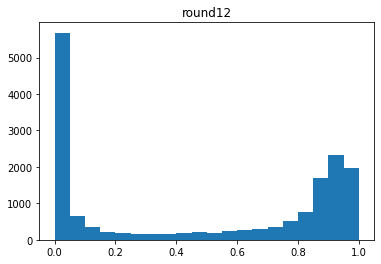

16464 unclassified features remaining
Continue with another iteration? (1=Yes, 0=No): 


 0


1/1 [==============================] - 0s 25ms/step


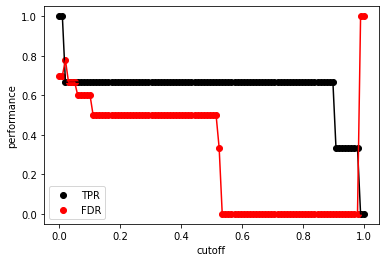

In [9]:
if __name__ == "__main__":
    integ.trainClassifierActive(X,[],[],200,1000,4,1,numVal = 10,numManualPerRound=10,inJupyter=True)

In [7]:
cutoff=0.8

In [11]:
integ.save(datadir + "active/")

In [8]:
integ.load(datadir + "active/")

In [23]:
if __name__ == "__main__":
    peak_curated,peak_scores,peak_intensities = integ.curatePeaks(raw_data,peakList,threshold=cutoff,align=True)
    peak_curated

generating EICs...
forming matrix |██████████████████████████████████████████████████| 100.0% 
aligning EICs |██████████████████████████████████████████████████| 100.0% 
4408/4408 [==============================] - 7s 2ms/step
integrating peaks...
integrating peaks |██████████████████████████████████████████████████| 100.0% 


In [24]:
peak_curated.to_csv(datadir + "peak_curated.csv")
peak_scores.to_csv(datadir + "peak_scores.csv")
peak_intensities.to_csv(datadir + "peak_intensities.csv")

In [11]:
peak_curated = pd.read_csv(datadir + "peak_curated.csv",index_col=0)
peak_scores = pd.read_csv(datadir + "peak_scores.csv",index_col=0)
peak_intensities = pd.read_csv(datadir + "peak_intensities.csv",index_col=0)

In [12]:
peak_curated

mz        rt  rt_start    rt_end  blank-1_6540.mzML  \
FT0001    52.979938  5.065533  4.959100  5.148091           0.000000   
FT0002    52.979845  4.829960  4.693100  4.865565           0.000000   
FT0003    52.979639  1.756369  1.674209  1.810926       10837.656774   
FT0004    54.976962  5.079406  5.032442  5.131516           0.000000   
FT0005    54.977004  4.967265  4.884650  4.992359         339.382945   
...             ...       ...       ...       ...                ...   
FT8293  1696.074555  0.760348  0.750980  0.769717           0.000000   
FT8294  1697.082626  0.760141  0.753100  0.767181           0.000000   
FT8295  1698.089255  0.760348  0.750980  0.769717           0.000000   
FT8296  1699.086468  0.767181  0.767181  0.767181           0.000000   
FT8297  1699.162494  6.872882  6.843596  6.910087           0.000000   

        blank-2_6540.mzML  blank-3_6540.mzML  P H-464_6540.mzML  \
FT0001           0.000000            0.00000      150837.234745   
FT0002         930.129534            0.00000       55655.981332   
FT0003        9208.201589        12363.55156       11387.833288   
FT0004           0.000000            0.00000       74036.348212   
FT0005         317.488548            0.00000       69324.270557   
...                   ...                ...                ...   
FT8293           0.000000            0.00000        1316.403455   
FT8294           0.000000            0.00000        2366.984688   
FT8295           0.000000            0.00000           0.000000   
FT8296           0.000000            0.00000           0.000000   
FT8297           0.000000            0.00000         296.367757   

        P H-469 -2 _6540.mzML  P H-471_6540.mzML  ...  \
FT0001          194413.486705      182357.676981  ...   
FT0002           63525.648336       49132.620413  ...   
FT0003            8725.272745        9047.622786  ...   
FT0004           41823.759345       51858.992980  ...   
FT0005           30759.487873       68950.167360  ...   
...                       ...                ...  ...   
FT8293               0.000000           0.000000  ...   
FT8294               0.000000           0.000000  ...   
FT8295               0.000000           0.000000  ...   
FT8296               0.000000           0.000000  ...   
FT8297            1149.545474         591.468211  ...   

        ../data/hamster_plasma/polar_neg/ms1/QC-P pool-2_6540.mzML  \
FT0001                                                0.0            
FT0002                                                0.0            
FT0003                                                0.0            
FT0004                                                0.0            
FT0005                                                0.0            
...                                                   ...            
FT8293                                                1.0            
FT8294                                                1.0            
FT8295                                                1.0            
FT8296                                                1.0            
FT8297                                                1.0            

        ../data/hamster_plasma/polar_neg/ms1/P H-488_6540.mzML  \
FT0001                                                0.0        
FT0002                                                0.0        
FT0003                                                0.0        
FT0004                                                0.0        
FT0005                                                0.0        
...                                                   ...        
FT8293                                                0.0        
FT8294                                                0.0        
FT8295                                                0.0        
FT8296                                                0.0        
FT8297                                                1.0        

        ../data/hamster_plas

In [12]:
y = integ.classifyMatrix(X)

NameError: name 'X' is not defined

c:\users\ethan\appdata\local\programs\python\python37\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


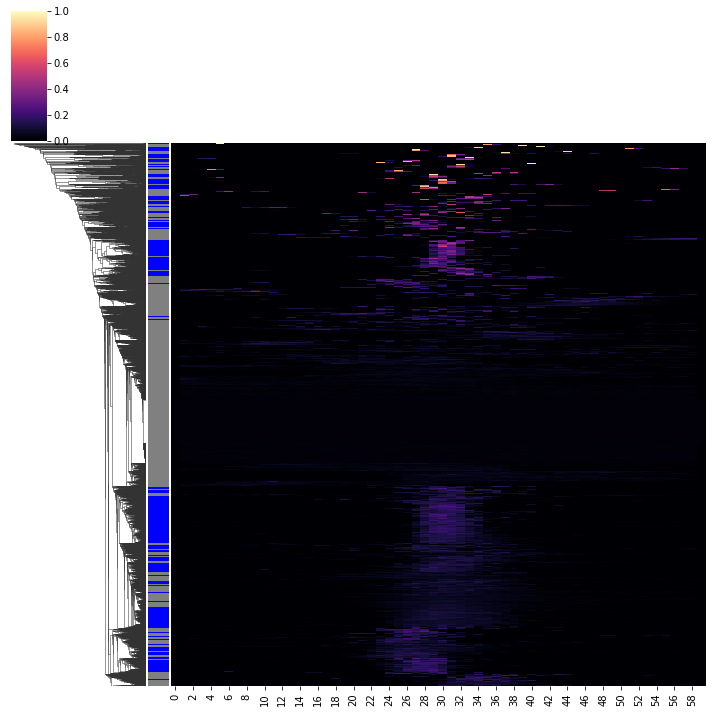

In [14]:
def tmp(val):
    if val > cutoff:
        return "blue"
    return "grey"
row_colors = [tmp(x) for x in y[:len(peakList),1]]
sb.clustermap(PeakDetective.normalizeMatrix(X[:len(peakList)]),col_cluster=False,yticklabels=False,cmap="magma",vmin=0.0,vmax=1.0,row_colors=row_colors)

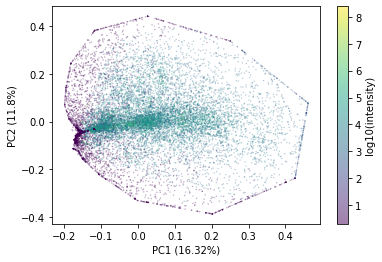

In [15]:
pca = PCA(2)
loads = pca.fit_transform(PeakDetective.normalizeMatrix(X))
plt.scatter(loads[:,0],loads[:,1],c=np.log10(np.array([np.max([2, PeakDetective.integratePeak(x)]) for x in X])),s=.1,alpha=.5)
plt.xlabel("PC1 (" + str(np.round(100*pca.explained_variance_ratio_[0],2)) + "%)")
plt.ylabel("PC2 (" + str(np.round(100*pca.explained_variance_ratio_[1],2)) + "%)")
#plt.xlim((-.5,.5))
plt.colorbar(label="log10(intensity)")

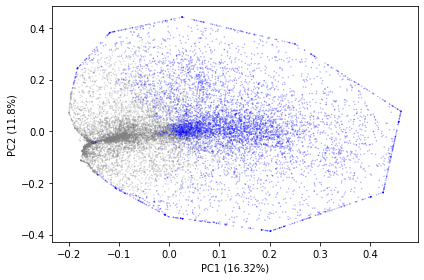

In [16]:
pca = PCA(2)
loads = pca.fit_transform(PeakDetective.normalizeMatrix(X))
colormap = LinearSegmentedColormap.from_list("test",colors=["grey", "blue"],N=256)
def getColor(v):
    if v > cutoff:
        return "blue"
    else:
        return "grey"
colors = [getColor(x) for x in y[:,1]]
#plt.scatter(loads[:,0],loads[:,1],c=y[:,1],s=.1,alpha=.5,cmap=colormap)
plt.scatter(loads[:,0],loads[:,1],c=colors,s=.1,alpha=.5)

plt.xlabel("PC1 (" + str(np.round(100*pca.explained_variance_ratio_[0],2)) + "%)")
plt.ylabel("PC2 (" + str(np.round(100*pca.explained_variance_ratio_[1],2)) + "%)")
#plt.xlim((-.5,.5))

#plt.colorbar(label="PeakDetective Score")
plt.tight_layout()
plt.savefig(datadir + "pca_pd.png",dpi=300)

Text(0, 0.5, '% of features')

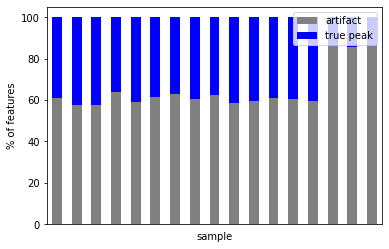

In [17]:
df = {}
for file in files:
    for index,row in peak_curated.iterrows():
        if row[datadir + file] > cutoff:
            df[len(df)] = {"sample":file,"classification":"true peak"}
        else:
            df[len(df)] = {"sample":file,"classification":"artifact"}

df = pd.DataFrame.from_dict(df,orient="index")

def aggregate(rows,columns,df):
    column_keys = df[columns].unique()
    row_keys = df[rows].unique()

    agg = { key : [ 100*len(df[(df[rows]==value) & (df[columns]==key)]) / len(df[df[rows]==value]) for value in row_keys]
               for key in column_keys }

    aggdf = pd.DataFrame(agg,index = row_keys)
    aggdf.index.rename(rows,inplace=True)

    return aggdf


aggregate('sample','classification',df).plot(kind='bar',stacked=True,color=["grey","blue"])
plt.xticks([],[])
plt.ylabel("% of features")

In [12]:
xcmsCols = [x for x in peakList.columns.values if ".mzML" in x and "D:" not in x]
xcms_peak_areas = peakList[xcmsCols]
xcms_peak_areas

blank-1_6540.mzML  blank-2_6540.mzML  blank-3_6540.mzML  \
FT0001           0.000000           0.000000            0.00000   
FT0002           0.000000         930.129534            0.00000   
FT0003       10837.656774        9208.201589        12363.55156   
FT0004           0.000000           0.000000            0.00000   
FT0005         339.382945         317.488548            0.00000   
...                   ...                ...                ...   
FT8293           0.000000           0.000000            0.00000   
FT8294           0.000000           0.000000            0.00000   
FT8295           0.000000           0.000000            0.00000   
FT8296           0.000000           0.000000            0.00000   
FT8297           0.000000           0.000000            0.00000   

        P H-464_6540.mzML  P H-469 -2 _6540.mzML  P H-471_6540.mzML  \
FT0001      150837.234745          194413.486705      182357.676981   
FT0002       55655.981332           63525.648336       49132.620413   
FT0003       11387.833288            8725.272745        9047.622786   
FT0004       74036.348212           41823.759345       51858.992980   
FT0005       69324.270557           30759.487873       68950.167360   
...                   ...                    ...                ...   
FT8293        1316.403455               0.000000           0.000000   
FT8294        2366.984688               0.000000           0.000000   
FT8295           0.000000               0.000000           0.000000   
FT8296           0.000000               0.000000           0.000000   
FT8297         296.367757            1149.545474         591.468211   

        P H-472_6540.mzML  P H-476_6540.mzML  P H-480_6540.mzML  \
FT0001        2486.967242        2419.482741        1820.433074   
FT0002       85895.599533      109236.614651       84843.231735   
FT0003        5899.952212        8375.259893        8291.012390   
FT0004       36614.956408       49015.141344       20003.029397   
FT0005       78110.782799       89538.583851       41074.662200   
...                   ...                ...                ...   
FT8293        1717.980596        4058.218594        3856.990736   
FT8294        1998.236755        4407.592237        3625.982775   
FT8295        1508.581696        3290.152508        4272.630885   
FT8296           0.000000        2929.793620        1291.343466   
FT8297         303.590024           0.000000           0.000000   

        P H-482_6540.mzML  P H-487_6540.mzML  P H-488_6540.mzML  \
FT0001      121797.502091      195846.665674      114430.629898   
FT0002       22774.304380       64173.831871      100585.428765   
FT0003       10633.587115        7078.631853        7309.740413   
FT0004       35633.679575       45166.144803       73630.910579   
FT0005       68834.907446       68240.561387       70451.410203   
...                   ...                ...                ...   
FT8293           0.000000           0.000000           0.000000   
FT8294           0.000000           0.000000           0.000000   
FT8295           0.000000           0.000000           0.000000   
FT8296           0.000000           0.000000           0.000000   
FT8297         694.828417        2165.214617        2719.982084   

        P H-507_6540.mzML  P H-514_6540.mzML  QC-P pool-2_6540.mzML  \
FT0001        1937.777705      182139.139394          114782.838173   
FT0002       63480.555059       62156.151168           84918.766147   
FT0003        6751.376184        9682.674564           11268.998269   
FT0004       43578.022167       41149.599339           37987.034083   
FT0005       62088.814024       61248.727906           72242.389613   
...                   ...                ...                    ...   
FT8293           0.000000           0.000000               0.000000   
FT8294         612.094990           0.000000            1241.825246   
FT8295           0.000000           0.000000             536.399392   
FT8296           0.000000     

In [13]:
pdCols = [x for x in peak_intensities.columns.values if ".mzML" in x]# and "D:" in x]
pd_peak_areas = peak_intensities[pdCols]
pd_peak_areas

../data/hamster_plasma/polar_neg/ms1/P H-482_6540.mzML  \
FT0001                                      104600.334172        
FT0002                                      171728.494598        
FT0003                                        1852.784121        
FT0004                                       37246.228613        
FT0005                                       52665.110387        
...                                                   ...        
FT8293                                           0.000000        
FT8294                                           0.000000        
FT8295                                           0.000000        
FT8296                                           0.000000        
FT8297                                         558.820762        

        ../data/hamster_plasma/polar_neg/ms1/P H-514_6540.mzML  \
FT0001                                      106616.519133        
FT0002                                      174484.681127        
FT0003                                        1261.889237        
FT0004                                       34022.723030        
FT0005                                       47902.799458        
...                                                   ...        
FT8293                                           0.000000        
FT8294                                           0.000000        
FT8295                                           0.000000        
FT8296                                           0.000000        
FT8297                                         401.018177        

        ../data/hamster_plasma/polar_neg/ms1/QC-P pool-3_6540.mzML  \
FT0001                                      119378.753567            
FT0002                                      187167.139051            
FT0003                                        1748.834064            
FT0004                                       42426.157674            
FT0005                                       54105.604778            
...                                                   ...            
FT8293                                         206.477925            
FT8294                                         693.108893            
FT8295                                         739.946503            
FT8296                                         555.739590            
FT8297                                         446.737947            

        ../data/hamster_plasma/polar_neg/ms1/blank-2_6540.mzML  \
FT0001                                           0.000000        
FT0002                                        1193.789534        
FT0003                                        1882.765480        
FT0004                                         309.230249        
FT0005                                         309.353945        
...                                                   ...        
FT8293                                           0.000000        
FT8294                                           0.000000        
FT8295                                           0.000000        
FT8296                                           0.000000        
FT8297                                           0.000000        

        ../data/hamster_plasma/polar_neg/ms1/QC-P pool-4_6540.mzML  \
FT0001                                      137570.693655            
FT0002                                      210969.118903            
FT0003                                        1717.690378            
FT0004                                       45853.107509            
FT0005                                       59022.967634            
...                                                   ...            
FT8293                                         141.310097            
FT8294                                         828.430215            
FT8295                                         434.692648            
FT8296                                           0.000000            
FT8297            

PearsonRResult(statistic=0.7623345475706571, pvalue=0.0)

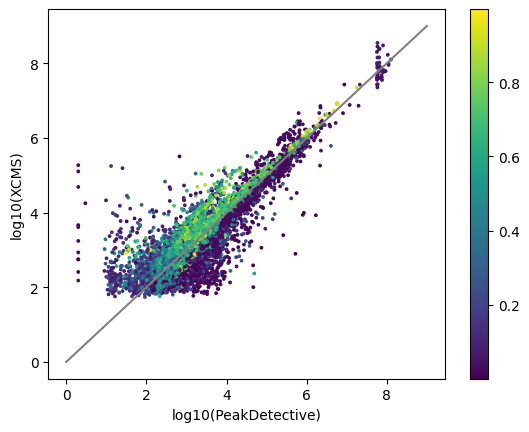

In [14]:
plt.scatter(np.log10(pd_peak_areas.values.mean(axis=1)+2),np.log10(xcms_peak_areas.values.mean(axis=1)+2),s=3,c=peak_scores[pdCols].values.mean(axis=1))
plt.plot([0,9],[0,9],color="grey")
plt.xlabel("log10(PeakDetective)")
plt.ylabel("log10(XCMS)")
plt.colorbar()
stats.pearsonr(pd_peak_areas.values.mean(axis=1),xcms_peak_areas.values.mean(axis=1))

In [9]:
if __name__ == "__main__":
    peak_scores_pd_det, peak_intensities_pd_det,rois = integ.detectPeaks(raw_data[:3], cutoff=cutoff, intensityCutoff = None,numDataPoints=3,window=0.1,plot=datadir + "/integration_plots/",align=True,detectFrac=0.5)

running ROI search |██████████████████████████████████████████████████| 100.0% 

3588  ROIs found
generating all EICs from ROIs...
forming matrix |██████████████████████████████████████████████████| 100.0% 
aligning EICs |██████████████████████████████████████████████████| 100.0% 
2368080 EICs constructed for evaluation
calculated peak areas
147381 EICs above intensity cutoff
constructed peak scores
starting classification
  46/4606 [..............................] - ETA: 5s  

2023-09-11 06:57:55.494202: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


4606/4606 [==============================] - 7s 2ms/step
done
refining retention times |██████████████████████████████████████████████████| 100.0% 
refining mzs |██████████████████████████████████████████████████| 100.0% 
generating EICs...
forming matrix |██████████████████████████████████████████████████| 100.0% 
aligning EICs |██████████████████████████████████████████████████| 100.0% 
286/286 [==============================] - 0s 2ms/step
integrating peaks...
integrating peaks |--------------------------------------------------| 0.2% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |--------------------------------------------------| 0.4% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)
/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |--------------------------------------------------| 0.4% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)
/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |--------------------------------------------------| 0.5% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)
/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |--------------------------------------------------| 0.6% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)
/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |--------------------------------------------------| 0.6% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)
/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |--------------------------------------------------| 0.7% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)
/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |--------------------------------------------------| 0.8% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |--------------------------------------------------| 0.8% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |--------------------------------------------------| 0.9% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |--------------------------------------------------| 1.0% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |--------------------------------------------------| 1.0% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)
/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |--------------------------------------------------| 1.1% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |--------------------------------------------------| 1.1% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |--------------------------------------------------| 1.3% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)
/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |--------------------------------------------------| 1.4% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)
/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |--------------------------------------------------| 1.6% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)
/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |--------------------------------------------------| 1.7% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |--------------------------------------------------| 1.9% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |█-------------------------------------------------| 2.3% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |█-------------------------------------------------| 2.7% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |█-------------------------------------------------| 2.9% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |█-------------------------------------------------| 2.9% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)
/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |█-------------------------------------------------| 3.1% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |█-------------------------------------------------| 3.1% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)
/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |█-------------------------------------------------| 3.2% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |█-------------------------------------------------| 3.3% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |█-------------------------------------------------| 3.4% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |█-------------------------------------------------| 3.5% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |█-------------------------------------------------| 3.6% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)
/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |█-------------------------------------------------| 3.8% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)
/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |█-------------------------------------------------| 3.9% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |█-------------------------------------------------| 4.0% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)
/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |██------------------------------------------------| 4.1% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |██------------------------------------------------| 4.2% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)
/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |██------------------------------------------------| 4.2% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)
/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |██------------------------------------------------| 4.4% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |██------------------------------------------------| 4.4% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |██------------------------------------------------| 4.6% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |██------------------------------------------------| 4.7% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |██------------------------------------------------| 4.8% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |██------------------------------------------------| 4.8% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)
/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |██------------------------------------------------| 4.9% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |██------------------------------------------------| 5.0% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |██------------------------------------------------| 5.0% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |██------------------------------------------------| 5.1% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |██------------------------------------------------| 5.2% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)
/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |██------------------------------------------------| 5.4% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)
/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |██------------------------------------------------| 5.4% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |██------------------------------------------------| 5.5% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)
/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |██------------------------------------------------| 5.6% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |██------------------------------------------------| 5.7% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)
/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |██------------------------------------------------| 5.7% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |██------------------------------------------------| 5.8% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)
/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |██------------------------------------------------| 5.9% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)
/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |██------------------------------------------------| 5.9% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)
/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |███-----------------------------------------------| 6.0% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)
/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |███-----------------------------------------------| 6.2% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |███-----------------------------------------------| 6.3% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)
/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |███-----------------------------------------------| 6.4% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |███-----------------------------------------------| 6.4% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)
/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |███-----------------------------------------------| 6.5% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)
/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |███-----------------------------------------------| 6.6% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)
/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |███-----------------------------------------------| 6.6% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |███-----------------------------------------------| 7.6% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |███-----------------------------------------------| 7.9% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |████----------------------------------------------| 8.3% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |████----------------------------------------------| 8.5% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |████----------------------------------------------| 8.5% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |████----------------------------------------------| 8.6% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |████----------------------------------------------| 8.7% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |████----------------------------------------------| 9.1% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)
/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |████----------------------------------------------| 9.3% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |████----------------------------------------------| 9.4% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |█████---------------------------------------------| 10.1% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)
/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |█████---------------------------------------------| 10.7% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |█████---------------------------------------------| 10.7% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)
/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |█████---------------------------------------------| 11.4% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |█████---------------------------------------------| 11.6% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)
/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |█████---------------------------------------------| 11.7% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |██████--------------------------------------------| 12.2% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |██████--------------------------------------------| 12.7% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |██████--------------------------------------------| 12.8% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |███████-------------------------------------------| 14.1% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |███████-------------------------------------------| 15.1% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |███████-------------------------------------------| 15.7% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |███████-------------------------------------------| 15.9% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |███████-------------------------------------------| 16.0% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |████████------------------------------------------| 16.6% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |████████------------------------------------------| 16.7% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |████████------------------------------------------| 17.4% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |████████------------------------------------------| 17.5% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |████████------------------------------------------| 17.8% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |████████------------------------------------------| 17.9% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |█████████-----------------------------------------| 18.2% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |█████████-----------------------------------------| 18.3% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |█████████-----------------------------------------| 19.5% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |██████████----------------------------------------| 20.3% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |██████████----------------------------------------| 21.3% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |██████████----------------------------------------| 21.6% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |███████████---------------------------------------| 22.2% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |███████████---------------------------------------| 22.3% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)
/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |███████████---------------------------------------| 23.4% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |████████████--------------------------------------| 24.1% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |████████████--------------------------------------| 25.0% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |████████████--------------------------------------| 25.6% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |█████████████-------------------------------------| 26.6% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |█████████████-------------------------------------| 26.8% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |██████████████------------------------------------| 28.5% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |██████████████------------------------------------| 29.5% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |██████████████------------------------------------| 29.6% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |███████████████-----------------------------------| 31.5% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)
/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |████████████████----------------------------------| 33.0% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |████████████████----------------------------------| 33.9% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |█████████████████---------------------------------| 34.0% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |█████████████████---------------------------------| 34.6% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |█████████████████---------------------------------| 35.9% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |██████████████████--------------------------------| 36.6% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |██████████████████--------------------------------| 36.7% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |██████████████████--------------------------------| 37.4% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |██████████████████--------------------------------| 37.6% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |██████████████████--------------------------------| 38.0% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |███████████████████-------------------------------| 38.2% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)
/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |████████████████████------------------------------| 40.1% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |████████████████████------------------------------| 40.2% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |████████████████████------------------------------| 40.4% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)
/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |████████████████████------------------------------| 40.5% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |████████████████████------------------------------| 40.9% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |████████████████████------------------------------| 41.5% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |█████████████████████-----------------------------| 42.9% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |█████████████████████-----------------------------| 43.1% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |█████████████████████-----------------------------| 43.5% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |█████████████████████-----------------------------| 43.7% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |██████████████████████----------------------------| 44.5% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |██████████████████████----------------------------| 44.6% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)
/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |██████████████████████----------------------------| 44.8% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |██████████████████████----------------------------| 45.0% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |██████████████████████----------------------------| 45.4% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |██████████████████████----------------------------| 45.6% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |██████████████████████----------------------------| 45.7% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |██████████████████████----------------------------| 45.8% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |███████████████████████---------------------------| 46.4% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |███████████████████████---------------------------| 47.0% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |███████████████████████---------------------------| 47.1% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |███████████████████████---------------------------| 47.6% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |███████████████████████---------------------------| 47.8% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |████████████████████████--------------------------| 48.3% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |████████████████████████--------------------------| 48.9% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)
/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |████████████████████████--------------------------| 49.2% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |████████████████████████--------------------------| 50.0% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |█████████████████████████-------------------------| 50.2% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |█████████████████████████-------------------------| 50.4% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |█████████████████████████-------------------------| 51.0% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |█████████████████████████-------------------------| 51.1% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)
/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |█████████████████████████-------------------------| 51.3% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |█████████████████████████-------------------------| 51.4% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)
/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |█████████████████████████-------------------------| 51.5% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |█████████████████████████-------------------------| 51.9% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |██████████████████████████------------------------| 52.1% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |██████████████████████████------------------------| 52.5% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |██████████████████████████------------------------| 53.0% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |██████████████████████████------------------------| 53.1% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |██████████████████████████------------------------| 53.4% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |██████████████████████████------------------------| 53.7% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |██████████████████████████------------------------| 53.9% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |███████████████████████████-----------------------| 54.2% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |███████████████████████████-----------------------| 54.9% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |███████████████████████████-----------------------| 55.2% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |███████████████████████████-----------------------| 55.2% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |███████████████████████████-----------------------| 55.7% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |████████████████████████████----------------------| 56.0% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |████████████████████████████----------------------| 56.1% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)
/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |████████████████████████████----------------------| 56.4% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |████████████████████████████----------------------| 56.5% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)
/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |████████████████████████████----------------------| 56.7% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |████████████████████████████----------------------| 57.1% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)
/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |████████████████████████████----------------------| 57.5% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |████████████████████████████----------------------| 57.6% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |████████████████████████████----------------------| 57.9% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |█████████████████████████████---------------------| 58.2% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |█████████████████████████████---------------------| 58.6% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |█████████████████████████████---------------------| 58.9% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |█████████████████████████████---------------------| 59.1% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |█████████████████████████████---------------------| 59.2% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |██████████████████████████████--------------------| 60.0% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |██████████████████████████████--------------------| 61.0% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |██████████████████████████████--------------------| 61.3% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)
/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |██████████████████████████████--------------------| 61.4% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |██████████████████████████████--------------------| 61.6% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)
/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |███████████████████████████████-------------------| 62.3% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)
/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |███████████████████████████████-------------------| 62.7% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)
/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |███████████████████████████████-------------------| 63.5% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |███████████████████████████████-------------------| 63.9% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |████████████████████████████████------------------| 64.2% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)
/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |████████████████████████████████------------------| 65.6% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |████████████████████████████████------------------| 65.7% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)
/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |████████████████████████████████------------------| 65.9% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |█████████████████████████████████-----------------| 66.1% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |█████████████████████████████████-----------------| 66.4% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |█████████████████████████████████-----------------| 66.6% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |█████████████████████████████████-----------------| 67.2% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)
/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |█████████████████████████████████-----------------| 67.6% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |█████████████████████████████████-----------------| 67.8% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)
/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |█████████████████████████████████-----------------| 67.9% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |██████████████████████████████████----------------| 68.0% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)
/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |██████████████████████████████████----------------| 68.2% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |██████████████████████████████████----------------| 68.4% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |██████████████████████████████████----------------| 68.5% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |██████████████████████████████████----------------| 69.1% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |██████████████████████████████████----------------| 69.1% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |███████████████████████████████████---------------| 70.3% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |███████████████████████████████████---------------| 70.4% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |███████████████████████████████████---------------| 70.7% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |███████████████████████████████████---------------| 70.8% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |███████████████████████████████████---------------| 71.0% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |███████████████████████████████████---------------| 71.8% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |████████████████████████████████████--------------| 72.5% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |████████████████████████████████████--------------| 73.9% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |█████████████████████████████████████-------------| 75.4% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |██████████████████████████████████████------------| 76.3% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |██████████████████████████████████████------------| 77.6% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |███████████████████████████████████████-----------| 78.2% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |███████████████████████████████████████-----------| 79.1% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |███████████████████████████████████████-----------| 79.9% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)
/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |████████████████████████████████████████----------| 80.6% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |████████████████████████████████████████----------| 80.9% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |█████████████████████████████████████████---------| 82.4% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |█████████████████████████████████████████---------| 82.7% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |█████████████████████████████████████████---------| 83.1% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |█████████████████████████████████████████---------| 83.3% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |██████████████████████████████████████████--------| 85.3% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |██████████████████████████████████████████--------| 85.8% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |███████████████████████████████████████████-------| 87.3% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |███████████████████████████████████████████-------| 87.5% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |████████████████████████████████████████████------| 88.5% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |████████████████████████████████████████████------| 89.0% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)
/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |████████████████████████████████████████████------| 89.2% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |████████████████████████████████████████████------| 89.7% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |█████████████████████████████████████████████-----| 90.4% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |█████████████████████████████████████████████-----| 91.9% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |██████████████████████████████████████████████----| 92.4% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |██████████████████████████████████████████████----| 93.0% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |██████████████████████████████████████████████----| 93.5% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |██████████████████████████████████████████████----| 93.9% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |███████████████████████████████████████████████---| 95.3% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |███████████████████████████████████████████████---| 96.0% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)
/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |████████████████████████████████████████████████--| 97.0% 

/Users/ethanstancliffe/anaconda3/envs/panome_bio/lib/python3.9/site-packages/PeakDetective/__init__.py:793: RuntimeWarning: invalid value encountered in divide
  tmp = norm * tmp / np.max(tmp)


integrating peaks |██████████████████████████████████████████████████| 100.0% 
537 peaks failed curation
2509  peaks found


In [13]:
peak_scores_pd_det

mz    rt  \
0       55.018944  0.98   
1       57.975851  1.72   
2       57.975765  1.72   
4       58.005930  0.92   
5       58.007045  1.70   
...           ...   ...   
3522  1652.141829  0.88   
3523  1653.151503  0.87   
3524  1654.152988  0.88   
3525  1655.161107  0.88   
3526  1656.165372  0.90   

      ../data/hamster_plasma/polar_neg/ms1/P H-482_6540.mzML  \
0                                              0.918692        
1                                              0.974380        
2                                              0.974380        
4                                              0.999810        
5                                              0.884160        
...                                                 ...        
3522                                           0.921009        
3523                                           0.914465        
3524                                           0.927080        
3525                                           0.945806        
3526                                           0.953767        

      ../data/hamster_plasma/polar_neg/ms1/P H-514_6540.mzML  \
0                                              0.854374        
1                                              0.973534        
2                                              0.973534        
4                                              0.023258        
5                                              0.911464        
...                                                 ...        
3522                                           0.909975        
3523                                           0.912563        
3524                                           0.906787        
3525                                           0.980680        
3526                                           0.944708        

      ../data/hamster_plasma/polar_neg/ms1/QC-P pool-3_6540.mzML  \
0                                              0.947217            
1                                              0.974230            
2                                              0.974230            
4                                              0.023258            
5                                              0.905005            
...                                                 ...            
3522                                           0.922113            
3523                                           0.914842            
3524                                           0.927179            
3525                                           0.937664            
3526                                           0.953104            

      ../data/hamster_plasma/polar_neg/ms1/blank-2_6540.mzML  \
0                                              0.284098        
1                                              0.999501        
2                                              0.999501        
4                                              0.023258        
5                                              0.023258        
...                                                 ...        
3522                                           0.023258        
3523                                           0.023258        
3524                                           0.023258        
3525                                           0.023258        
3526                                           0.023258        

      ../data/hamster_plasma/polar_neg/ms1/QC-P pool-4_6540.mzML  
0                                              0.970304           
1                                              0.974774           
2                                              0.974774           
4                                              0.999992           
5                                              0.916363           
...                                                 ...           
3522                                           0.929502           
3523                          

In [14]:
peak_intensities_pd_det

mz    rt  \
0       55.018944  0.98   
1       57.975851  1.72   
2       57.975765  1.72   
4       58.005930  0.92   
5       58.007045  1.70   
...           ...   ...   
3522  1652.141829  0.88   
3523  1653.151503  0.87   
3524  1654.152988  0.88   
3525  1655.161107  0.88   
3526  1656.165372  0.90   

      ../data/hamster_plasma/polar_neg/ms1/P H-482_6540.mzML  \
0                                           1351.162389        
1                                         156293.177052        
2                                         156293.177052        
4                                            665.528399        
5                                           1538.396087        
...                                                 ...        
3522                                        7318.387906        
3523                                        5598.174548        
3524                                        4824.818770        
3525                                        2781.833989        
3526                                        4059.066897        

      ../data/hamster_plasma/polar_neg/ms1/P H-514_6540.mzML  \
0                                           1266.004536        
1                                         122021.867273        
2                                         122021.867273        
4                                              0.000000        
5                                           1521.411828        
...                                                 ...        
3522                                        5399.944982        
3523                                        3942.905157        
3524                                        3266.312366        
3525                                        2317.331987        
3526                                        3673.300503        

      ../data/hamster_plasma/polar_neg/ms1/QC-P pool-3_6540.mzML  \
0                                           1116.254736            
1                                         175289.441850            
2                                         175289.441850            
4                                              0.000000            
5                                           1832.673400            
...                                                 ...            
3522                                        7584.763665            
3523                                        5266.142524            
3524                                        6125.918404            
3525                                        3000.825291            
3526                                        4302.857132            

      ../data/hamster_plasma/polar_neg/ms1/blank-2_6540.mzML  \
0                                           1159.512111        
1                                            683.119041        
2                                            683.119041        
4                                              0.000000        
5                                              0.000000        
...                                                 ...        
3522                                           0.000000        
3523                                           0.000000        
3524                                           0.000000        
3525                                           0.000000        
3526                                           0.000000        

      ../data/hamster_plasma/polar_neg/ms1/QC-P pool-4_6540.mzML  
0                                            664.038157           
1                                         174712.695001           
2                                         174712.695001           
4                                            475.862665           
5                                           2045.433282           
...                                                 ...           
3522                                        6970.905898           
3523                          

In [18]:
peak_intensities_pd_det = peak_intensities_pd_det.drop(toDrop,axis=0)

In [15]:
peak_intensities_pd_det.to_csv(datadir + "peak_intensities_pd_det.csv")
peak_scores_pd_det.to_csv(datadir + "peak_scores_pd_det.csv")
pkl.dump(rois,open(datadir+"rois.pkl","wb"))

In [16]:
peak_intensities_pd_det = pd.read_csv(datadir + "peak_intensities_pd_det.csv",index_col=0) 
peak_scores_pd_det = pd.read_csv(datadir + "peak_scores_pd_det.csv",index_col=0)
rois = pkl.load(open(datadir+"rois.pkl","rb"))

In [19]:
pdCols = [x for x in peak_intensities_pd_det.columns.values if ".mzML" in x]# and "D:" in x]# and "lank" not in x]
pdCols

['../data/hamster_plasma/polar_neg/ms1/P H-482_6540.mzML',
 '../data/hamster_plasma/polar_neg/ms1/P H-514_6540.mzML',
 '../data/hamster_plasma/polar_neg/ms1/QC-P pool-3_6540.mzML',
 '../data/hamster_plasma/polar_neg/ms1/blank-2_6540.mzML',
 '../data/hamster_plasma/polar_neg/ms1/QC-P pool-4_6540.mzML',
 '../data/hamster_plasma/polar_neg/ms1/P H-472_6540.mzML',
 '../data/hamster_plasma/polar_neg/ms1/blank-3_6540.mzML',
 '../data/hamster_plasma/polar_neg/ms1/QC-P pool-2_6540.mzML',
 '../data/hamster_plasma/polar_neg/ms1/P H-488_6540.mzML',
 '../data/hamster_plasma/polar_neg/ms1/P H-507_6540.mzML',
 '../data/hamster_plasma/polar_neg/ms1/P H-480_6540.mzML',
 '../data/hamster_plasma/polar_neg/ms1/P H-471_6540.mzML',
 '../data/hamster_plasma/polar_neg/ms1/P H-464_6540.mzML',
 '../data/hamster_plasma/polar_neg/ms1/P H-487_6540.mzML',
 '../data/hamster_plasma/polar_neg/ms1/P H-469 -2 _6540.mzML',
 '../data/hamster_plasma/polar_neg/ms1/blank-1_6540.mzML',
 '../data/hamster_plasma/polar_neg/ms1/P

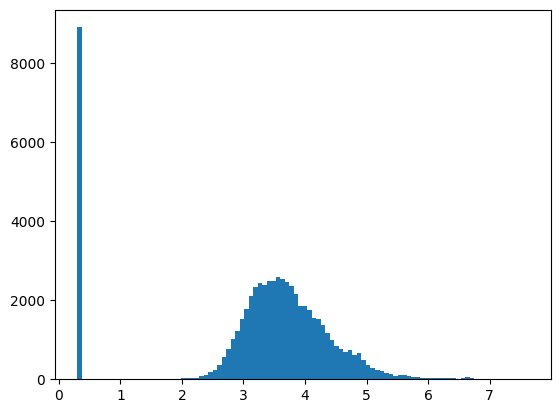

In [20]:
plt.hist(np.log10(peak_intensities_pd_det[pdCols].values.flatten()+2),bins=100)
pass

In [21]:
pd_peak_list = detection_helper.PeakList()
pd_peak_list.from_df(peak_intensities_pd_det,pdCols)
pd_peak_list.peakList

mz    rt  \
0       55.018714  0.98   
1       57.975682  1.72   
2       57.975666  1.72   
4       58.007234  1.70   
5       58.977561  1.72   
...           ...   ...   
4083  1656.169224  0.87   
4084  1657.170386  0.85   
4085  1657.170953  0.85   
4086  1672.135062  0.82   
4089  1676.144140  0.85   

      ../data/hamster_plasma/polar_neg/ms1/P H-482_6540.mzML  \
0                                            701.895625        
1                                         156293.177052        
2                                         156293.177052        
4                                           1538.396087        
5                                           3036.563002        
...                                                 ...        
4083                                        3940.977551        
4084                                        1943.647202        
4085                                        1943.647202        
4086                                         686.866330        
4089                                        2253.659040        

      ../data/hamster_plasma/polar_neg/ms1/P H-514_6540.mzML  \
0                                            691.388819        
1                                         122021.867273        
2                                         122021.867273        
4                                           1521.411828        
5                                           1934.598756        
...                                                 ...        
4083                                        3811.247491        
4084                                         626.900041        
4085                                         626.900041        
4086                                           0.000000        
4089                                         637.343642        

      ../data/hamster_plasma/polar_neg/ms1/QC-P pool-3_6540.mzML  \
0                                            425.920523            
1                                         175289.441850            
2                                         175289.441850            
4                                           1832.673400            
5                                           2621.869824            
...                                                 ...            
4083                                        4272.133279            
4084                                        1553.630561            
4085                                        1553.630561            
4086                                         872.708322            
4089                                        2382.240462            

      ../data/hamster_plasma/polar_neg/ms1/blank-2_6540.mzML  \
0                                            579.756055        
1                                            683.119041        
2                                            683.119041        
4                                              0.000000        
5                                              0.000000        
...                                                 ...        
4083                                           0.000000        
4084                                           0.000000        
4085                                           0.000000        
4086                                           0.000000        
4089                                           0.000000        

      ../data/hamster_plasma/polar_neg/ms1/QC-P pool-4_6540.mzML  \
0                                            325.402784            
1                                         174712.695001            
2                                         174712.695001            
4                                           2045.433282            
5                                           3481.252788            
...                                                 ...            
4083                                        3774.560478            
4084                  

In [22]:
pd_peak_list.imputeRowMin(pdCols)

0.14243925831202045 of values imputted


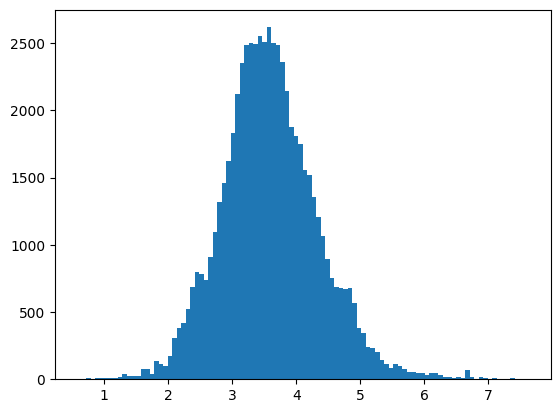

In [23]:
plt.hist(np.log10(pd_peak_list.peakList[pdCols].values.flatten()),bins=100)
pass

In [24]:
## pd_peak_list 
pd_peak_list.peakList

mz    rt  \
0       55.018714  0.98   
1       57.975682  1.72   
2       57.975666  1.72   
4       58.007234  1.70   
5       58.977561  1.72   
...           ...   ...   
4083  1656.169224  0.87   
4084  1657.170386  0.85   
4085  1657.170953  0.85   
4086  1672.135062  0.82   
4089  1676.144140  0.85   

      ../data/hamster_plasma/polar_neg/ms1/P H-482_6540.mzML  \
0                                            701.895625        
1                                         156293.177052        
2                                         156293.177052        
4                                           1538.396087        
5                                           3036.563002        
...                                                 ...        
4083                                        3940.977551        
4084                                        1943.647202        
4085                                        1943.647202        
4086                                         686.866330        
4089                                        2253.659040        

      ../data/hamster_plasma/polar_neg/ms1/P H-514_6540.mzML  \
0                                            691.388819        
1                                         122021.867273        
2                                         122021.867273        
4                                           1521.411828        
5                                           1934.598756        
...                                                 ...        
4083                                        3811.247491        
4084                                         626.900041        
4085                                         626.900041        
4086                                         267.833106        
4089                                         637.343642        

      ../data/hamster_plasma/polar_neg/ms1/QC-P pool-3_6540.mzML  \
0                                            425.920523            
1                                         175289.441850            
2                                         175289.441850            
4                                           1832.673400            
5                                           2621.869824            
...                                                 ...            
4083                                        4272.133279            
4084                                        1553.630561            
4085                                        1553.630561            
4086                                         872.708322            
4089                                        2382.240462            

      ../data/hamster_plasma/polar_neg/ms1/blank-2_6540.mzML  \
0                                            579.756055        
1                                            683.119041        
2                                            683.119041        
4                                            472.013225        
5                                            896.665242        
...                                                 ...        
4083                                        1496.514989        
4084                                         313.450020        
4085                                         313.450020        
4086                                         267.833106        
4089                                         318.671821        

      ../data/hamster_plasma/polar_neg/ms1/QC-P pool-4_6540.mzML  \
0                                            325.402784            
1                                         174712.695001            
2                                         174712.695001            
4                                           2045.433282            
5                                           3481.252788            
...                                                 ...            
4083                                        3774.560478            
4084                  

In [25]:
det = detection_helper.PeakList()
det.readXCMSPeakList(datadir+"xcms_peak_list.csv")
det.peakList

mz        rt  rt_start    rt_end  blank-1_6540.mzML  \
FT0001    52.979938  5.065533  4.959100  5.148091           0.000000   
FT0002    52.979845  4.829960  4.693100  4.865565           0.000000   
FT0003    52.979639  1.756369  1.674209  1.810926       10837.656774   
FT0004    54.976962  5.079406  5.032442  5.131516           0.000000   
FT0005    54.977004  4.967265  4.884650  4.992359         339.382945   
...             ...       ...       ...       ...                ...   
FT8293  1696.074555  0.760348  0.750980  0.769717           0.000000   
FT8294  1697.082626  0.760141  0.753100  0.767181           0.000000   
FT8295  1698.089255  0.760348  0.750980  0.769717           0.000000   
FT8296  1699.086468  0.767181  0.767181  0.767181           0.000000   
FT8297  1699.162494  6.872882  6.843596  6.910087           0.000000   

        blank-2_6540.mzML  blank-3_6540.mzML  P H-464_6540.mzML  \
FT0001           0.000000            0.00000      150837.234745   
FT0002         930.129534            0.00000       55655.981332   
FT0003        9208.201589        12363.55156       11387.833288   
FT0004           0.000000            0.00000       74036.348212   
FT0005         317.488548            0.00000       69324.270557   
...                   ...                ...                ...   
FT8293           0.000000            0.00000        1316.403455   
FT8294           0.000000            0.00000        2366.984688   
FT8295           0.000000            0.00000           0.000000   
FT8296           0.000000            0.00000           0.000000   
FT8297           0.000000            0.00000         296.367757   

        P H-469 -2 _6540.mzML  P H-471_6540.mzML  ...  P H-476_6540.mzML  \
FT0001          194413.486705      182357.676981  ...        2419.482741   
FT0002           63525.648336       49132.620413  ...      109236.614651   
FT0003            8725.272745        9047.622786  ...        8375.259893   
FT0004           41823.759345       51858.992980  ...       49015.141344   
FT0005           30759.487873       68950.167360  ...       89538.583851   
...                       ...                ...  ...                ...   
FT8293               0.000000           0.000000  ...        4058.218594   
FT8294               0.000000           0.000000  ...        4407.592237   
FT8295               0.000000           0.000000  ...        3290.152508   
FT8296               0.000000           0.000000  ...        2929.793620   
FT8297            1149.545474         591.468211  ...           0.000000   

        P H-480_6540.mzML  P H-482_6540.mzML  P H-487_6540.mzML  \
FT0001        1820.433074      121797.502091      195846.665674   
FT0002       84843.231735       22774.304380       64173.831871   
FT0003        8291.012390       10633.587115        7078.631853   
FT0004       20003.029397       35633.679575       45166.144803   
FT0005       41074.662200       68834.907446       68240.561387   
...                   ...                ...                ...   
FT8293        3856.990736           0.000000           0.000000   
FT8294        3625.982775           0.000000           0.000000   
FT8295        4272.630885           0.000000           0.000000   
FT8296        1291.343466           0.000000           0.000000   
FT8297           0.000000         694.828417        2165.214617   

        P H-488_6540.mzML  P H-507_6540.mzML  P H-514_6540.mzML  \
FT0001      114430.629898        1937.777705      182139.139394   
FT0002      100585.428765       63480.555059       62156.151168   
FT0003        7309.740413        6751.376184        9682.674564   
FT0004       73630.910579       43578.022167       41149.599339   
FT0005       70451.410203       62088.814024       61248.727906   
...                   ...                ...                ...   
FT8293           0.000000           0.000000           0.000000   
FT8294           0.000000         612.094990           0.000000   
FT8295           0.000000 

In [26]:
research_samps = [x for x in peak_scores.columns.values if ".mzML" in x]
toDrop = []
rois.sort()
for index,row in det.peakList.iterrows():
    if np.sum(peak_scores.loc[index,research_samps].values > cutoff) < float(len(research_samps)/2):# or np.sum(peak_intensities.loc[index,research_samps].values < 1000) < len(research_samps)/2 :
        toDrop.append(index)
    if 1e6 * np.abs(row["mz"]-PeakDetective.take_closest(rois,row["mz"]))/row["mz"] > ms1ppm:
        pass
        #toDrop.append(index)
det.peakList = det.peakList.drop(toDrop,axis=0)
det.peakList

mz         rt   rt_start     rt_end  blank-1_6540.mzML  \
FT0003    52.979639   1.756369   1.674209   1.810926       10837.656774   
FT0010    57.034480   0.953673   0.922369   1.001612      258491.589936   
FT0011    56.995922  13.330191  13.252383  13.446531      202150.447314   
FT0012    56.995680  13.199834  13.126038  13.243473      137778.110029   
FT0013    56.996018  13.054014  13.020373  13.055117       80249.592542   
...             ...        ...        ...        ...                ...   
FT8284  1685.993159   0.456061   0.453850   0.469943        4708.816342   
FT8285  1685.994118   0.154583   0.134914   0.221072        4751.980473   
FT8286  1687.124988   6.909916   6.843596   6.943891           0.000000   
FT8289  1689.158485   6.859461   6.857317   6.919152           0.000000   
FT8297  1699.162494   6.872882   6.843596   6.910087           0.000000   

        blank-2_6540.mzML  blank-3_6540.mzML  P H-464_6540.mzML  \
FT0003        9208.201589       12363.551560       1.138783e+04   
FT0010      264086.086068      250030.490449       2.434569e+05   
FT0011        2183.621489      195728.657266       1.054116e+06   
FT0012      110385.841653      148519.106712       8.688820e+05   
FT0013       69210.134466       77375.300216       3.769472e+05   
...                   ...                ...                ...   
FT8284        6374.384473        5363.522037       6.564676e+03   
FT8285       12009.467125        5562.361977       3.783626e+03   
FT8286           0.000000           0.000000       2.604296e+03   
FT8289           0.000000           0.000000       0.000000e+00   
FT8297           0.000000           0.000000       2.963678e+02   

        P H-469 -2 _6540.mzML  P H-471_6540.mzML  ...  P H-476_6540.mzML  \
FT0003           8.725273e+03       9.047623e+03  ...       8.375260e+03   
FT0010           2.372035e+05       2.570292e+05  ...       3.466859e+03   
FT0011           6.340897e+05       1.115575e+06  ...       5.626025e+05   
FT0012           1.055941e+06       8.133475e+05  ...       1.024035e+06   
FT0013           7.288392e+05       3.674017e+05  ...       4.698638e+05   
...                       ...                ...  ...                ...   
FT8284           5.807497e+03       6.824891e+03  ...       5.811971e+03   
FT8285           4.516244e+03       4.805513e+03  ...       4.188064e+03   
FT8286           2.768085e+03       2.381764e+03  ...       0.000000e+00   
FT8289           2.552787e+02       0.000000e+00  ...       0.000000e+00   
FT8297           1.149545e+03       5.914682e+02  ...       0.000000e+00   

        P H-480_6540.mzML  P H-482_6540.mzML  P H-487_6540.mzML  \
FT0003        8291.012390       1.063359e+04       7.078632e+03   
FT0010      237496.396545       2.577472e+05       2.743992e+05   
FT0011      358239.203038       1.501525e+04       1.184705e+04   
FT0012      669458.524242       1.131419e+06       1.064348e+06   
FT0013      936903.172332       7.112154e+05       1.135220e+04   
...                   ...                ...                ...   
FT8284        6111.351616       5.901560e+03       6.634124e+03   
FT8285        6022.685174       3.894465e+03       5.442316e+03   
FT8286           0.000000       1.377043e+03       4.197668e+03   
FT8289           0.000000       1.048839e+03       1.980170e+03   
FT8297           0.000000       6.948284e+02       2.165215e+03   

        P H-488_6540.mzML  P H-507_6540.mzML  P H-514_6540.mzML  \
FT0003       7.309740e+03       6.751376e+03       9.682675e+03   
FT0010       4.650187e+03       4.918520e+03       5.174832e+03   
FT0011       4.367926e+05       1.216111e+06       1.144687e+04   
FT0012       8.830316e+05       9.972839e+05       1.137301e+06   
FT0013       1.017491e+06       5.869718e+05       6.802531e+05   
...                   ...                ...                ...   
FT8284       6.925869e+03       6.899049e+03       4.982892e+03   
FT8285       5.539559e+03       5.498474e+03       5.4170

In [27]:
#get overlap 
overlap,_ = detection_helper.mergePeakLists([pd_peak_list.peakList,det.peakList],["PeakDetective","XCMS"],ms1ppm,0.25)
overlap

index           mz        rt  PeakDetective  XCMS
0          0    55.018714  0.980000              1     0
1          1    57.975682  1.720000              1     1
2          2    57.975666  1.720000              1     0
3          4    58.007234  1.700000              1     1
4          5    58.977561  1.720000              1     1
...      ...          ...       ...            ...   ...
5621  FT8284  1685.993159  0.456061              0     1
5622  FT8285  1685.994118  0.154583              0     1
5623  FT8286  1687.124988  6.909916              0     1
5624  FT8289  1689.158485  6.859461              0     1
5625  FT8297  1699.162494  6.872882              0     1

[5626 rows x 5 columns]

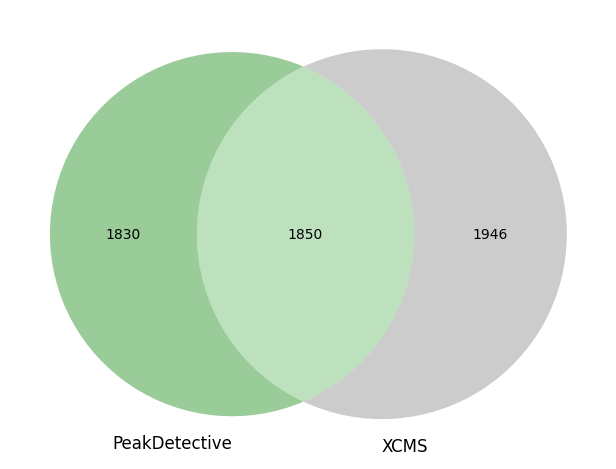

In [28]:
venn2([set(overlap[overlap["PeakDetective"] > 0.5].index.values),set(overlap[overlap["XCMS"] > 0.5].index.values)],set_labels=["PeakDetective","XCMS"],set_colors=["green","grey"])
plt.tight_layout()
plt.savefig(datadir + "venn_feats.png",dpi=300)

In [29]:
pd_only_feats = overlap[(overlap["PeakDetective"] > 0.5) & (overlap["XCMS"] < 0.5)].sort_values(by="mz").set_index("index")
pd_only_feats

mz    rt  PeakDetective  XCMS
index                                        
0        55.018714  0.98              1     0
2        57.975666  1.72              1     0
7        58.977352  1.72              1     0
8        58.978050  1.70              1     0
11       59.046288  1.58              1     0
...            ...   ...            ...   ...
4062   1644.113326  0.82              1     0
4063   1644.113596  0.82              1     0
4072   1649.673453  6.85              1     0
4080   1653.169276  6.85              1     0
4085   1657.170953  0.85              1     0

[1830 rows x 4 columns]

In [30]:
xcms_only_feats = overlap[(overlap["PeakDetective"] < 0.5) & (overlap["XCMS"] > 0.5)].sort_values(by="mz").set_index("index")
xcms_only_feats

mz         rt  PeakDetective  XCMS
index                                              
FT0003    52.979639   1.756369              0     1
FT0014    56.995720   0.645003              0     1
FT0011    56.995922  13.330191              0     1
FT0013    56.996018  13.054014              0     1
FT0010    57.034480   0.953673              0     1
...             ...        ...            ...   ...
FT8284  1685.993159   0.456061              0     1
FT8285  1685.994118   0.154583              0     1
FT8286  1687.124988   6.909916              0     1
FT8289  1689.158485   6.859461              0     1
FT8297  1699.162494   6.872882              0     1

[1946 rows x 4 columns]

In [31]:
shared_feats = overlap[(overlap["PeakDetective"] > 0.5) & (overlap["XCMS"] > 0.5)].sort_values(by="mz").set_index("index")
shared_feats

mz    rt  PeakDetective  XCMS
index                                        
1        57.975682  1.72              1     1
4        58.007234  1.70              1     1
5        58.977561  1.72              1     1
10       59.046401  1.58              1     1
12       59.971197  1.73              1     1
...            ...   ...            ...   ...
4082   1655.160913  0.88              1     1
4083   1656.169224  0.87              1     1
4084   1657.170386  0.85              1     1
4086   1672.135062  0.82              1     1
4089   1676.144140  0.85              1     1

[1850 rows x 4 columns]

In [32]:
if __name__ == "__main__":
    X_pd_only = integ.makeDataMatrix(raw_data[:1],pd_only_feats["mz"],pd_only_feats["rt"],align=False)
    X_xcms_only = integ.makeDataMatrix(raw_data[:1],xcms_only_feats["mz"],xcms_only_feats["rt"],align=False)
    X_shared = integ.makeDataMatrix(raw_data[:1],shared_feats["mz"],shared_feats["rt"],align=False)

forming matrix |██████████████████████████████████████████████████| 100.0% 
forming matrix |██████████████████████████████████████████████████| 100.0% 
forming matrix |██████████████████████████████████████████████████| 100.0% 


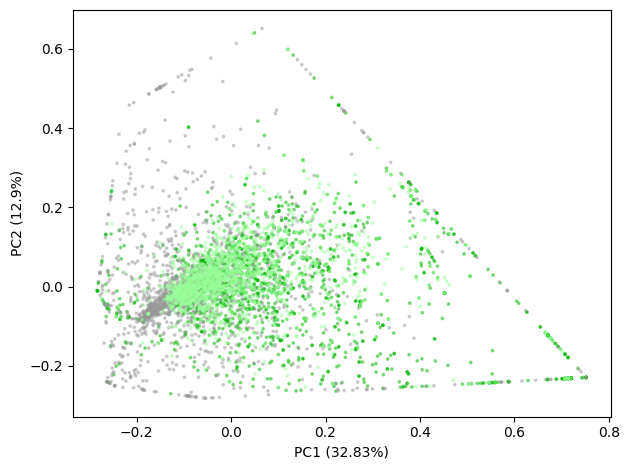

In [33]:
colors = [(0,0.7,0) for _ in X_pd_only] + [(0.6,0.6,0.6) for _ in X_xcms_only] + [(0.6,1.0,0.6) for _ in X_shared]
X_cat = PeakDetective.normalizeMatrix(np.concatenate((X_pd_only,X_xcms_only,X_shared),axis=0))
pca = PCA(2)
loads = pca.fit_transform(X_cat)
plt.scatter(loads[:,0],loads[:,1],c=colors,s=3,alpha=.4)

plt.xlabel("PC1 (" + str(np.round(100*pca.explained_variance_ratio_[0],2)) + "%)")
plt.ylabel("PC2 (" + str(np.round(100*pca.explained_variance_ratio_[1],2)) + "%)")
plt.tight_layout()
plt.savefig(datadir + "pca_feattype.png",dpi=300)

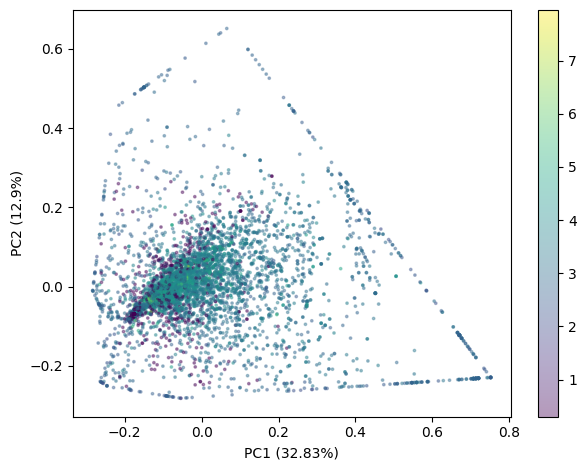

In [34]:
colors = np.concatenate((np.log10(np.array([np.max([2, PeakDetective.integratePeak(x)]) for x in X_pd_only])),np.log10(np.array([np.max([2, PeakDetective.integratePeak(x)]) for x in X_xcms_only])),np.log10(np.array([np.max([2, PeakDetective.integratePeak(x)]) for x in X_shared]))))
X_cat = PeakDetective.normalizeMatrix(np.concatenate((X_pd_only,X_xcms_only,X_shared),axis=0))
pca = PCA(2)
loads = pca.fit_transform(X_cat)
plt.scatter(loads[:,0],loads[:,1],c=colors,s=3,alpha=.4)

plt.xlabel("PC1 (" + str(np.round(100*pca.explained_variance_ratio_[0],2)) + "%)")
plt.ylabel("PC2 (" + str(np.round(100*pca.explained_variance_ratio_[1],2)) + "%)")
plt.colorbar()
plt.tight_layout()
plt.savefig(datadir + "pca_intensity_feat_type.png",dpi=300)


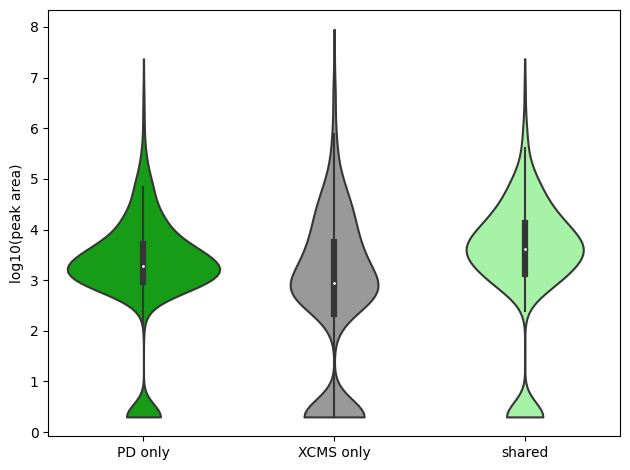

In [35]:
plt_dict = {}

for x in X_pd_only:
    plt_dict[len(plt_dict)] = {"feature type":"PD only","log10(peak area)":np.log10(np.max([2, PeakDetective.integratePeak(x)]))}
for x in X_xcms_only:
    plt_dict[len(plt_dict)] = {"feature type":"XCMS only","log10(peak area)":np.log10(np.max([2, PeakDetective.integratePeak(x)]))}
for x in X_shared:
    plt_dict[len(plt_dict)] = {"feature type":"shared","log10(peak area)":np.log10(np.max([2, PeakDetective.integratePeak(x)]))}

sb.violinplot(data=pd.DataFrame.from_dict(plt_dict,orient="index"),x="feature type",y="log10(peak area)",alpha=0.4,cut=0,palette={"PD only":(0,0.7,0),"XCMS only":(0.6,0.6,0.6),"shared":(0.6,1.0,0.6)})
plt.xlabel("")
plt.tight_layout()
plt.savefig(datadir + "intensity_violin.png",dpi=300)

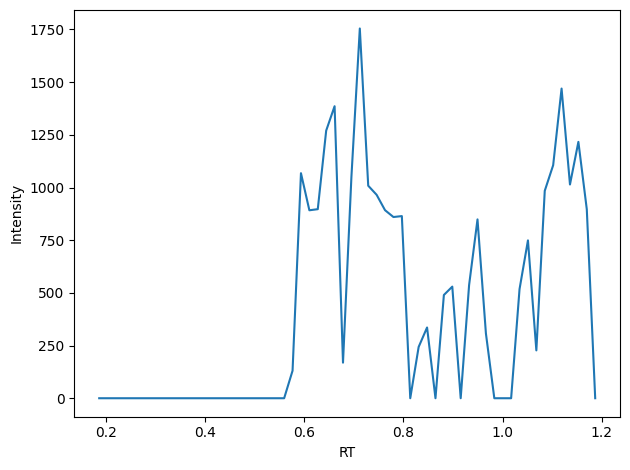

In [38]:
ind = rd.choice(range(len(xcms_only_feats)))
row = xcms_only_feats.iloc[ind,:]
plot_overlayedEIC(raw_data[:1],row["mz"],row["rt"]-.5,row["rt"] + .5,resolution=resolution,alpha=1.0)
plt.xlabel("RT")
plt.ylabel("Intensity")
plt.tight_layout()
plt.savefig(datadir + "XCMS_example_only.png",dpi=300)

In [39]:
allPdFeats = overlap[overlap["PeakDetective"] > 0.5].sort_values(by="mz").set_index("index")
allPdFeats

mz    rt  PeakDetective  XCMS
index                                        
0        55.018714  0.98              1     0
2        57.975666  1.72              1     0
1        57.975682  1.72              1     1
4        58.007234  1.70              1     1
7        58.977352  1.72              1     0
...            ...   ...            ...   ...
4083   1656.169224  0.87              1     1
4084   1657.170386  0.85              1     1
4085   1657.170953  0.85              1     0
4086   1672.135062  0.82              1     1
4089   1676.144140  0.85              1     1

[3680 rows x 4 columns]

In [40]:
pd_peak_list.backgroundSubtract(["lank"],["QC"],3)
pd_peak_list.peakList

1587 background features found


mz    rt  \
1       57.975682  1.72   
2       57.975666  1.72   
4       58.007234  1.70   
5       58.977561  1.72   
7       58.977352  1.72   
...           ...   ...   
4081  1654.156280  0.85   
4084  1657.170386  0.85   
4085  1657.170953  0.85   
4086  1672.135062  0.82   
4089  1676.144140  0.85   

      ../data/hamster_plasma/polar_neg/ms1/P H-482_6540.mzML  \
1                                         156293.177052        
2                                         156293.177052        
4                                           1538.396087        
5                                           3036.563002        
7                                           3036.563002        
...                                                 ...        
4081                                        6774.718596        
4084                                        1943.647202        
4085                                        1943.647202        
4086                                         686.866330        
4089                                        2253.659040        

      ../data/hamster_plasma/polar_neg/ms1/P H-514_6540.mzML  \
1                                         122021.867273        
2                                         122021.867273        
4                                           1521.411828        
5                                           1934.598756        
7                                           1934.598756        
...                                                 ...        
4081                                        4579.385370        
4084                                         626.900041        
4085                                         626.900041        
4086                                         267.833106        
4089                                         637.343642        

      ../data/hamster_plasma/polar_neg/ms1/QC-P pool-3_6540.mzML  \
1                                         175289.441850            
2                                         175289.441850            
4                                           1832.673400            
5                                           2621.869824            
7                                           2621.869824            
...                                                 ...            
4081                                        8613.806558            
4084                                        1553.630561            
4085                                        1553.630561            
4086                                         872.708322            
4089                                        2382.240462            

      ../data/hamster_plasma/polar_neg/ms1/blank-2_6540.mzML  \
1                                            683.119041        
2                                            683.119041        
4                                            472.013225        
5                                            896.665242        
7                                            896.665242        
...                                                 ...        
4081                                        2289.692685        
4084                                         313.450020        
4085                                         313.450020        
4086                                         267.833106        
4089                                         318.671821        

      ../data/hamster_plasma/polar_neg/ms1/QC-P pool-4_6540.mzML  \
1                                         174712.695001            
2                                         174712.695001            
4                                           2045.433282            
5                                           3481.252788            
7                                           2794.805102            
...                                                 ...            
4081                                        5894.992424            
4084                  

In [41]:
backgroundFeats = list(set(allPdFeats.index.values) - set(pd_peak_list.peakList.index.values))
print(backgroundFeats[:5],len(backgroundFeats))

[0, 10, 11, 12, 13] 1587


In [42]:
research_samps = [x for x in pd_peak_list.sampleCols if "QC" not in x and "lank" not in x]
research_samps

['../data/hamster_plasma/polar_neg/ms1/P H-482_6540.mzML',
 '../data/hamster_plasma/polar_neg/ms1/P H-514_6540.mzML',
 '../data/hamster_plasma/polar_neg/ms1/P H-472_6540.mzML',
 '../data/hamster_plasma/polar_neg/ms1/P H-488_6540.mzML',
 '../data/hamster_plasma/polar_neg/ms1/P H-507_6540.mzML',
 '../data/hamster_plasma/polar_neg/ms1/P H-480_6540.mzML',
 '../data/hamster_plasma/polar_neg/ms1/P H-471_6540.mzML',
 '../data/hamster_plasma/polar_neg/ms1/P H-464_6540.mzML',
 '../data/hamster_plasma/polar_neg/ms1/P H-487_6540.mzML',
 '../data/hamster_plasma/polar_neg/ms1/P H-469 -2 _6540.mzML',
 '../data/hamster_plasma/polar_neg/ms1/P H-476_6540.mzML']

In [43]:
if __name__ == "__main__":
    pd_peak_list.removeRedundancy(0.5,0.5,"negative",ms1ppm,5,sampleCols=research_samps)


grouping peaks |██████████████████████████████████████████████████| 100.0% 1005 peak groups found
running mz.unity |--------------------------------------------------| 0.9% 

Loading required package: ggplot2
Loading required package: ggplot2
Loading required package: ggplot2
Loading required package: ggplot2
Loading required package: ggplot2
Loading required package: magrittr
Loading required package: magrittr
Loading required package: magrittr
Loading required package: magrittr
Loading required package: magrittr
Loading required package: igraph
Loading required package: igraph
Loading required package: igraph
Loading required package: igraph
Loading required package: igraph

Attaching package: ‘igraph’


Attaching package: ‘igraph’


Attaching package: ‘igraph’


Attaching package: ‘igraph’


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following ob

running mz.unity |█-------------------------------------------------| 3.6% 

Loading required package: ggplot2
Loading required package: ggplot2
Loading required package: ggplot2
Loading required package: ggplot2
Loading required package: ggplot2
Loading required package: magrittr
Loading required package: magrittr
Loading required package: igraph
Loading required package: igraph
Loading required package: magrittr
Loading required package: magrittr
Loading required package: igraph
Loading required package: igraph
Loading required package: magrittr
Loading required package: igraph

Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘igraph’


Attaching package: ‘dplyr’

The following objects are masked from ‘package:igraph’:

    as_data_frame, group

running mz.unity |██------------------------------------------------| 4.8% 

Loading required package: magrittr
Loading required package: magrittr
Loading required package: magrittr
Loading required package: igraph
Loading required package: magrittr
Loading required package: igraph
Loading required package: igraph
Loading required package: magrittr
Loading required package: igraph
Loading required package: igraph

Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘igraph’


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spec

running mz.unity |██------------------------------------------------| 5.9% 

Loading required package: magrittr
Loading required package: magrittr
Loading required package: magrittr
Loading required package: igraph
Loading required package: magrittr
Loading required package: magrittr
Loading required package: igraph
Loading required package: igraph
Loading required package: igraph
Loading required package: igraph

Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘igraph’


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

The following object is masked from ‘package:base’:

    union


Attaching package: ‘igraph’


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spec

running mz.unity |███-----------------------------------------------| 7.5% 

Loading required package: magrittr
Loading required package: magrittr
Loading required package: igraph
Loading required package: magrittr
Loading required package: magrittr
Loading required package: magrittr
Loading required package: igraph
Loading required package: igraph
Loading required package: igraph
Loading required package: igraph

Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘igraph’


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

The following objects are masked from ‘package:stats’:

    decompose, spectrum


Attaching package: ‘igr

running mz.unity |████----------------------------------------------| 9.7% 

Loading required package: magrittr
Loading required package: magrittr
Loading required package: magrittr
Loading required package: igraph
Loading required package: igraph
Loading required package: igraph
Loading required package: magrittr
Loading required package: igraph
Loading required package: magrittr
Loading required package: igraph

Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘igraph’


Attaching package: ‘dplyr’

The following objects are masked from ‘package:igraph’:

    as_data_frame, 

running mz.unity |█████---------------------------------------------| 11.0% 

Loading required package: magrittr
Loading required package: magrittr
Loading required package: igraph
Loading required package: magrittr
Loading required package: igraph
Loading required package: magrittr
Loading required package: igraph
Loading required package: igraph
Loading required package: magrittr
Loading required package: igraph

Attaching package: ‘igraph’


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

The following object is masked from ‘package:base’:

    union


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is 

running mz.unity |██████--------------------------------------------| 12.4% 

Loading required package: magrittr
Loading required package: magrittr
Loading required package: magrittr
Loading required package: igraph
Loading required package: magrittr
Loading required package: igraph
Loading required package: igraph
Loading required package: igraph
Loading required package: magrittr
Loading required package: igraph

Attaching package: ‘igraph’


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

The following object is masked from ‘package:base’:

    union


Attaching package: ‘igraph’


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

The following object is 

running mz.unity |██████--------------------------------------------| 13.2% 

Loading required package: magrittr
Loading required package: igraph
Loading required package: magrittr
Loading required package: igraph
Loading required package: magrittr
Loading required package: igraph
Loading required package: magrittr
Loading required package: igraph
Loading required package: magrittr
Loading required package: igraph

Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘dplyr’

The following objects are masked from ‘package:igraph’:

    as_data_frame, groups, union

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Warning message:
NAs 

running mz.unity |███████-------------------------------------------| 14.5% 

Loading required package: magrittr
Loading required package: igraph
Loading required package: magrittr
Loading required package: igraph
Loading required package: magrittr
Loading required package: magrittr
Loading required package: igraph
Loading required package: igraph
Loading required package: magrittr
Loading required package: igraph

Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘igraph’


Attaching package: ‘dplyr’

The following objects are masked from ‘package:igraph’:

    as_data_frame, groups, union

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following objects are masked from ‘package:stats’:

    filter, lag

The following object is masked from ‘package:base’:

    union

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘

running mz.unity |████████------------------------------------------| 16.0% 

Loading required package: ggplot2
Loading required package: magrittr
Loading required package: igraph
Loading required package: magrittr
Loading required package: magrittr
Loading required package: igraph
Loading required package: igraph

Attaching package: ‘igraph’

Loading required package: magrittr
The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Loading required package: igraph

Attaching package: ‘igraph’

Loading required package: magrittr
The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Loading required package: igraph

Attaching package: ‘dplyr’

The following objects are masked from ‘package:igraph’:

    as_data_fra

running mz.unity |████████------------------------------------------| 17.6% 

Loading required package: ggplot2
Loading required package: ggplot2
Loading required package: ggplot2
Loading required package: magrittr
Loading required package: igraph
Loading required package: magrittr
Loading required package: magrittr
Loading required package: igraph
Loading required package: igraph

Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Loading required package: magrittr

Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘dplyr’

The following objects are masked from ‘package:igraph’:

    as_data_frame, groups, union

The following 

running mz.unity |█████████-----------------------------------------| 19.0% 

Loading required package: ggplot2
Loading required package: ggplot2
Loading required package: magrittr
Loading required package: magrittr
Loading required package: igraph
Loading required package: igraph
Loading required package: magrittr
Loading required package: igraph
Loading required package: magrittr
Loading required package: igraph

Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘dplyr’

The following objects are masked from ‘package:igraph’:

    as_data_frame, groups, union

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Warning message:
NAs 

running mz.unity |██████████----------------------------------------| 21.9% 

Loading required package: ggplot2
Loading required package: ggplot2
Loading required package: ggplot2
Loading required package: ggplot2
Loading required package: ggplot2
Loading required package: magrittr
Loading required package: magrittr
Loading required package: igraph
Loading required package: igraph
Loading required package: magrittr
Loading required package: magrittr
Loading required package: igraph

Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Loading required package: igraph

Attaching package: ‘dplyr’

The following objects are masked from ‘package:igraph’:

    as_data_frame, groups, union

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘igraph’

Warning message:
NAs introduced by coercion 
The following objec

running mz.unity |███████████---------------------------------------| 23.1% 

Loading required package: ggplot2
Loading required package: ggplot2
Loading required package: ggplot2
Loading required package: ggplot2
Loading required package: ggplot2
Loading required package: magrittr
Loading required package: igraph
Loading required package: magrittr
Loading required package: igraph
Loading required package: magrittr
Loading required package: igraph
Loading required package: magrittr
Loading required package: igraph

Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘dplyr’

The 

running mz.unity |████████████--------------------------------------| 24.5% 

Loading required package: ggplot2
Loading required package: ggplot2
Loading required package: ggplot2
Loading required package: ggplot2
Loading required package: ggplot2
Loading required package: magrittr
Loading required package: magrittr
Loading required package: magrittr
Loading required package: igraph
Loading required package: igraph
Loading required package: igraph
Loading required package: magrittr
Loading required package: igraph

Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum


Attaching package: ‘igraph’

The following object is masked from ‘package:base’:

    union

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘dplyr’

The 

running mz.unity |█████████████-------------------------------------| 26.3% 

Loading required package: ggplot2
Loading required package: ggplot2
Loading required package: magrittr
Loading required package: igraph
Loading required package: magrittr
Loading required package: igraph
Loading required package: magrittr
Loading required package: igraph

Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Loading required package: magrittr
Loading required package: igraph

Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘dplyr’

The following objects are masked from ‘package:igraph’:

    as_data_frame, groups, union

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Warning message:
NAs 

running mz.unity |██████████████------------------------------------| 28.1% 

Loading required package: ggplot2
Loading required package: ggplot2
Loading required package: ggplot2
Loading required package: ggplot2
Loading required package: ggplot2
Loading required package: magrittr
Loading required package: magrittr
Loading required package: magrittr
Loading required package: igraph
Loading required package: igraph
Loading required package: igraph
Loading required package: magrittr
Loading required package: igraph

Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘igraph’


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Loading required package: magritt

running mz.unity |██████████████------------------------------------| 29.6% 

Loading required package: ggplot2
Loading required package: magrittr
Loading required package: igraph
Loading required package: magrittr
Loading required package: igraph
Loading required package: magrittr
Loading required package: magrittr
Loading required package: igraph
Loading required package: igraph

Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘dplyr’

The following objects are masked from ‘package:igraph’:

    as_data_frame, groups, union

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Warning message:
NAs introduced by coercion 

Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Loading re

running mz.unity |███████████████-----------------------------------| 30.9% 

Loading required package: ggplot2
Loading required package: magrittr
Loading required package: magrittr
Loading required package: magrittr
Loading required package: igraph
Loading required package: igraph
Loading required package: igraph
Loading required package: magrittr
Loading required package: igraph

Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Loading required package: magrittr

Attaching package: ‘igraph’


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

The following object is masked from ‘package:base’:

    union

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is

running mz.unity |████████████████----------------------------------| 32.8% 

Loading required package: magrittr
Loading required package: igraph
Loading required package: magrittr
Loading required package: magrittr
Loading required package: igraph
Loading required package: igraph
Loading required package: magrittr
Loading required package: igraph
Loading required package: magrittr
Loading required package: igraph

Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘igraph’


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘dplyr’

The following objects are masked from ‘package:igraph’:

    as_data_frame, groups, union

The following o

running mz.unity |█████████████████---------------------------------| 35.6% 

Loading required package: magrittr
Loading required package: igraph
Loading required package: magrittr
Loading required package: magrittr
Loading required package: igraph
Loading required package: igraph
Loading required package: magrittr
Loading required package: igraph
Loading required package: magrittr
Loading required package: igraph

Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘dplyr’

The following objects are masked from ‘package:igraph’:

    as_data_frame, groups, union

The following o

running mz.unity |██████████████████--------------------------------| 36.8% 

Loading required package: magrittr
Loading required package: igraph
Loading required package: magrittr
Loading required package: magrittr
Loading required package: igraph
Loading required package: igraph
Loading required package: magrittr
Loading required package: magrittr
Loading required package: igraph
Loading required package: igraph

Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘igraph’


Attaching package: ‘dplyr’

The following objects are masked from ‘package:igraph’:

    as_data_frame, groups, union

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following objects are masked from ‘package:stats’:

    filter, lag

The following object is masked from ‘package:base’:

    union

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Warning message:
NAs 

running mz.unity |███████████████████-------------------------------| 38.2% 

Loading required package: magrittr
Loading required package: igraph
Loading required package: magrittr
Loading required package: igraph
Loading required package: magrittr
Loading required package: igraph
Loading required package: magrittr
Loading required package: magrittr
Loading required package: igraph
Loading required package: igraph

Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘igraph’


Attaching package: ‘dplyr’

The following objects are masked from ‘package:igraph’:

    as_data_frame, groups, union

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following objects are masked from ‘package:stats’:

    filter, lag

The following object is masked from ‘package:base’:

    union

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Warning message:
NAs 

running mz.unity |████████████████████------------------------------| 40.5% 

Loading required package: magrittr
Loading required package: magrittr
Loading required package: igraph
Loading required package: magrittr
Loading required package: igraph
Loading required package: igraph
Loading required package: magrittr
Loading required package: igraph
Loading required package: magrittr
Loading required package: igraph

Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘dplyr’

The following objects are masked from ‘package:igraph’:

    as_data_frame, groups, union

The following o

running mz.unity |█████████████████████-----------------------------| 42.3% 

Loading required package: magrittr
Loading required package: magrittr
Loading required package: igraph
Loading required package: igraph
Loading required package: magrittr
Loading required package: magrittr
Loading required package: magrittr
Loading required package: igraph
Loading required package: igraph
Loading required package: igraph

Attaching package: ‘igraph’


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

The following object is masked from ‘package:base’:

    union


Attaching package: ‘igraph’


Attaching package: ‘igraph’


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

The following objects are masked from ‘package:stats’:

    decompose, spec

running mz.unity |█████████████████████-----------------------------| 43.8% 

Loading required package: magrittr
Loading required package: magrittr
Loading required package: igraph
Loading required package: igraph
Loading required package: magrittr
Loading required package: igraph
Loading required package: magrittr
Loading required package: magrittr
Loading required package: igraph
Loading required package: igraph

Attaching package: ‘igraph’


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘dplyr’

The following objects are masked from ‘package:igraph’:

    as_data_frame, groups, union

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘

running mz.unity |██████████████████████----------------------------| 44.8% 

Loading required package: magrittr
Loading required package: igraph
Loading required package: magrittr
Loading required package: magrittr
Loading required package: igraph
Loading required package: igraph
Loading required package: magrittr
Loading required package: magrittr
Loading required package: igraph
Loading required package: igraph

Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘dplyr’

The following objects are masked from ‘package:igraph’:

    as_data_frame, groups, union

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Warning message:
NAs introduced by coercion 

Attaching package: ‘igraph’


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The follow

running mz.unity |███████████████████████---------------------------| 46.2% 

Loading required package: magrittr
Loading required package: magrittr
Loading required package: magrittr
Loading required package: igraph
Loading required package: igraph
Loading required package: igraph
Loading required package: magrittr
Loading required package: magrittr
Loading required package: igraph
Loading required package: igraph

Attaching package: ‘igraph’


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘dplyr’

The following objects are masked from ‘package:igraph’:

    as_data_frame, groups, union

The following o

running mz.unity |███████████████████████---------------------------| 47.2% 

Loading required package: magrittr
Loading required package: igraph
Loading required package: magrittr
Loading required package: igraph
Loading required package: magrittr
Loading required package: igraph
Loading required package: magrittr
Loading required package: igraph

Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Loading required package: magrittr

Attaching package: ‘dplyr’


Attaching package: ‘igraph’

The following objects are masked from ‘package:igraph’:

    as_data_frame, groups, union

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Warning message:
NAs introduced by coercion 
The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Loading r

running mz.unity |████████████████████████--------------------------| 49.2% 

Loading required package: ggplot2
Loading required package: magrittr
Loading required package: igraph
Loading required package: magrittr
Loading required package: igraph
Loading required package: magrittr
Loading required package: igraph
Loading required package: magrittr
Loading required package: igraph
Loading required package: magrittr
Loading required package: igraph

Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘igraph’


Attaching package: ‘dplyr’

The following objects are masked from ‘package:igraph’:

    as_data_frame, groups, union

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

The following objects are masked from ‘package:stats’:

    decompose, spectrum

Warning message:
NAs introduced by coercion 
The fo

running mz.unity |█████████████████████████-------------------------| 51.0% 

Loading required package: magrittr
Loading required package: igraph
Loading required package: magrittr
Loading required package: magrittr
Loading required package: igraph
Loading required package: igraph
Loading required package: magrittr
Loading required package: magrittr
Loading required package: igraph
Loading required package: igraph

Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘igraph’


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘dplyr’

The following objects are masked from ‘package:igraph’:

    as_data_frame, groups, union

The following o

running mz.unity |██████████████████████████------------------------| 53.0% 

Loading required package: magrittr
Loading required package: magrittr
Loading required package: igraph
Loading required package: magrittr
Loading required package: igraph
Loading required package: igraph
Loading required package: magrittr
Loading required package: magrittr
Loading required package: igraph
Loading required package: igraph

Attaching package: ‘igraph’


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘dplyr’


Attaching package: ‘dplyr’

The following objects are masked from ‘package:igraph’:

    as_data_frame, g

running mz.unity |███████████████████████████-----------------------| 55.8% 

Loading required package: magrittr
Loading required package: igraph
Loading required package: magrittr
Loading required package: igraph
Loading required package: magrittr
Loading required package: magrittr
Loading required package: igraph
Loading required package: igraph
Loading required package: magrittr

Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Loading required package: igraph

Attaching package: ‘igraph’


Attaching package: ‘dplyr’

The following objects are masked from ‘package:igraph’:

    as_data_frame, groups, union

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Warning message:
NAs introduced by coercion 
The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘pac

running mz.unity |████████████████████████████----------------------| 57.2% 

Loading required package: magrittr
Loading required package: igraph
Loading required package: magrittr
Loading required package: igraph
Loading required package: magrittr
Loading required package: igraph
Loading required package: magrittr
Loading required package: magrittr
Loading required package: igraph
Loading required package: igraph

Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘dplyr’

The following objects are masked from ‘package:igraph’:

    as_data_frame, groups, union

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Warning message:
NAs 

running mz.unity |████████████████████████████----------------------| 57.8% 

Loading required package: magrittr
Loading required package: igraph
Loading required package: magrittr
Loading required package: igraph
Loading required package: magrittr
Loading required package: igraph
Loading required package: magrittr
Loading required package: igraph

Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘igraph’

Loading required package: magrittr
The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Loading required package: igraph

Attaching package: ‘dplyr’

The following objects are masked from ‘package:igraph’:

    as_data_frame, groups, union

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Warning message:
NAs 

running mz.unity |█████████████████████████████---------------------| 58.8% 

Loading required package: ggplot2
Loading required package: magrittr
Loading required package: igraph
Loading required package: magrittr
Loading required package: igraph
Loading required package: magrittr
Loading required package: igraph
Loading required package: magrittr

Attaching package: ‘igraph’

Loading required package: igraph
The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘igraph’

Loading required package: magrittr
The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Loading required package: igraph

Attaching package: ‘dplyr’

The following objects are masked from ‘package:igraph’:

    as_data_frame, groups, union

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, sete

running mz.unity |█████████████████████████████---------------------| 59.5% 

Loading required package: magrittr
Loading required package: igraph
Loading required package: magrittr
Loading required package: igraph
Loading required package: magrittr
Loading required package: igraph
Loading required package: magrittr
Loading required package: igraph

Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Loading required package: magrittr
Loading required package: igraph

Attaching package: ‘dplyr’

The following objects are masked from ‘package:igraph’:

    as_data_frame, groups, union

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Warning message:
NAs introduced by coercion 

Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘pac

running mz.unity |██████████████████████████████--------------------| 60.8% 

Loading required package: magrittr
Loading required package: igraph
Loading required package: magrittr
Loading required package: igraph
Loading required package: magrittr
Loading required package: igraph

Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Loading required package: magrittr
Loading required package: magrittr
Loading required package: igraph
Loading required package: igraph

Attaching package: ‘dplyr’

The following objects are masked from ‘package:igraph’:

    as_data_frame, groups, union

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Warning message:
NAs introduced by coercion 

Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘pac

running mz.unity |██████████████████████████████--------------------| 61.6% 

Loading required package: magrittr
Loading required package: magrittr
Loading required package: igraph
Loading required package: igraph
Loading required package: magrittr
Loading required package: igraph

Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

Loading required package: magrittr
The following object is masked from ‘package:base’:

    union


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Loading required package: igraph

Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘dplyr’

The following objects are masked from ‘package:igraph’:

    as_data_frame, groups, union

Loading required package: magrittr
The following objects are masked from ‘package:s

running mz.unity |███████████████████████████████-------------------| 63.3% 

Loading required package: ggplot2
Loading required package: ggplot2
Loading required package: magrittr
Loading required package: magrittr
Loading required package: igraph
Loading required package: igraph
Loading required package: magrittr
Loading required package: igraph
Loading required package: magrittr
Loading required package: magrittr

Attaching package: ‘igraph’


Attaching package: ‘igraph’

Loading required package: igraph
Loading required package: igraph
The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

The following object is masked from ‘package:base’:

    union


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘dplyr’

The following objects are masked from 

running mz.unity |████████████████████████████████------------------| 64.4% 

Loading required package: magrittr
Loading required package: magrittr
Loading required package: magrittr
Loading required package: igraph
Loading required package: igraph
Loading required package: igraph
Loading required package: magrittr
Loading required package: igraph
Loading required package: magrittr
Loading required package: igraph

Attaching package: ‘igraph’


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘dplyr’


Attaching package: ‘dplyr’

The following objects are masked from ‘package:igraph’:

    as_data_frame, g

running mz.unity |████████████████████████████████------------------| 66.0% 

Loading required package: magrittr
Loading required package: igraph
Loading required package: magrittr
Loading required package: magrittr
Loading required package: igraph
Loading required package: igraph
Loading required package: magrittr
Loading required package: magrittr
Loading required package: igraph
Loading required package: igraph

Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘dplyr’


Attaching package: ‘igraph’

The following objects are masked from ‘package:igraph’:

    as_data_frame, groups, union

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Warning message:
NAs introduced by coercion 
The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘pac

running mz.unity |█████████████████████████████████-----------------| 66.8% 

Loading required package: magrittr
Loading required package: igraph
Loading required package: magrittr
Loading required package: magrittr
Loading required package: igraph
Loading required package: igraph
Loading required package: magrittr
Loading required package: igraph
Loading required package: magrittr

Attaching package: ‘igraph’

Loading required package: igraph
The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘dplyr’

The following objects are masked from ‘package:igraph’:

    as_data_frame, groups, union

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘igraph’

Warning message:
NAs introduced by coercion 

Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The follow

running mz.unity |█████████████████████████████████-----------------| 67.9% 

Loading required package: magrittr
Loading required package: igraph
Loading required package: magrittr
Loading required package: igraph
Loading required package: magrittr
Loading required package: magrittr
Loading required package: igraph
Loading required package: igraph
Loading required package: magrittr
Loading required package: igraph

Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘dplyr’

The following objects are masked from ‘package:igraph’:

    as_data_frame, groups, union

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Warning message:
NAs 

running mz.unity |███████████████████████████████████---------------| 70.3% 

Loading required package: magrittr
Loading required package: magrittr
Loading required package: igraph
Loading required package: magrittr
Loading required package: igraph
Loading required package: magrittr
Loading required package: igraph
Loading required package: magrittr
Loading required package: igraph
Loading required package: igraph

Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum


Attaching package: ‘igraph’

The following object is masked from ‘package:base’:

    union

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘igraph’


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spec

running mz.unity |███████████████████████████████████---------------| 71.3% 

Loading required package: magrittr
Loading required package: igraph
Loading required package: magrittr
Loading required package: igraph
Loading required package: magrittr
Loading required package: igraph
Loading required package: magrittr

Attaching package: ‘igraph’

Loading required package: igraph
The following objects are masked from ‘package:stats’:

    decompose, spectrum

Loading required package: magrittr
The following object is masked from ‘package:base’:

    union

Loading required package: igraph

Attaching package: ‘dplyr’

The following objects are masked from ‘package:igraph’:

    as_data_frame, groups, union

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Warning message:
NAs introduced by coercion 

Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘pac

running mz.unity |████████████████████████████████████--------------| 72.2% 

Loading required package: magrittr
Loading required package: igraph
Loading required package: magrittr
Loading required package: igraph
Loading required package: magrittr
Loading required package: igraph
Loading required package: magrittr
Loading required package: igraph

Attaching package: ‘igraph’

Loading required package: magrittr
The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Loading required package: igraph

Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘dplyr’

The following objects are masked from ‘package:igraph’:

    as_data_frame, groups, union

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Warning message:
NAs 

running mz.unity |████████████████████████████████████--------------| 73.6% 

Loading required package: magrittr
Loading required package: igraph
Loading required package: magrittr
Loading required package: magrittr
Loading required package: magrittr
Loading required package: igraph
Loading required package: igraph
Loading required package: igraph
Loading required package: magrittr

Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Loading required package: igraph

Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘igraph’


Attaching package: ‘dplyr’

The following objects are masked from ‘package:igraph’:

    as_data_frame, groups, union

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The fo

running mz.unity |█████████████████████████████████████-------------| 74.3% 

Loading required package: magrittr
Loading required package: magrittr
Loading required package: magrittr
Loading required package: igraph
Loading required package: igraph
Loading required package: igraph
Loading required package: magrittr
Loading required package: magrittr
Loading required package: igraph
Loading required package: igraph

Attaching package: ‘igraph’


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘dplyr’

The following objects are masked from ‘package:igraph’:

    as_data_frame, groups, union

The following o

running mz.unity |█████████████████████████████████████-------------| 75.3% 

Loading required package: magrittr
Loading required package: magrittr
Loading required package: igraph
Loading required package: igraph
Loading required package: magrittr
Loading required package: magrittr
Loading required package: magrittr
Loading required package: igraph
Loading required package: igraph
Loading required package: igraph

Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘igraph’


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spec

running mz.unity |██████████████████████████████████████------------| 77.3% 

Loading required package: magrittr
Loading required package: igraph
Loading required package: magrittr
Loading required package: magrittr
Loading required package: igraph
Loading required package: igraph
Loading required package: magrittr
Loading required package: magrittr
Loading required package: igraph
Loading required package: igraph

Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘dplyr’

The following objects are masked from ‘package:igraph’:

    as_data_frame, groups, union

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Warning message:
NAs introduced by coercion 

Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘pac

running mz.unity |███████████████████████████████████████-----------| 79.3% 

Loading required package: magrittr
Loading required package: igraph
Loading required package: magrittr
Loading required package: magrittr
Loading required package: magrittr
Loading required package: igraph
Loading required package: igraph
Loading required package: igraph
Loading required package: magrittr
Loading required package: igraph

Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘igraph’


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘dplyr’

The following objects are masked from ‘package:igraph’:

    as_data_frame, 

running mz.unity |████████████████████████████████████████----------| 81.1% 

Loading required package: magrittr
Loading required package: magrittr
Loading required package: magrittr
Loading required package: igraph
Loading required package: igraph
Loading required package: igraph
Loading required package: magrittr
Loading required package: igraph
Loading required package: magrittr
Loading required package: igraph

Attaching package: ‘igraph’


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum


Attaching package: ‘igraph’

The following object is masked from ‘package:base’:

    union

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

The following object is masked from ‘package:base’:

    union


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is 

running mz.unity |█████████████████████████████████████████---------| 82.7% 

Loading required package: magrittr
Loading required package: magrittr
Loading required package: igraph
Loading required package: igraph
Loading required package: magrittr
Loading required package: igraph
Loading required package: magrittr
Loading required package: igraph
Loading required package: magrittr
Loading required package: igraph

Attaching package: ‘igraph’


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘dplyr’

The following objects are masked from ‘package:igraph’:

    as_data_frame, groups, union

The following o

running mz.unity |█████████████████████████████████████████---------| 83.7% 

Loading required package: magrittr
Loading required package: magrittr
Loading required package: igraph
Loading required package: igraph
Loading required package: magrittr
Loading required package: igraph
Loading required package: magrittr
Loading required package: igraph

Attaching package: ‘igraph’


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Loading required package: magrittr
Loading required package: igraph

Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘dplyr’


Attaching package: ‘dplyr’

The following objects are masked from ‘package:igraph’:

    as_data_frame, g

running mz.unity |██████████████████████████████████████████--------| 84.7% 

Loading required package: magrittr
Loading required package: igraph
Loading required package: magrittr
Loading required package: igraph
Loading required package: magrittr

Attaching package: ‘igraph’

Loading required package: igraph
The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘dplyr’

The following objects are masked from ‘package:igraph’:

    as_data_frame, groups, union

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Warning message:
NAs introduced by coercion 
Loading required package: magrittr
Loading required package: igraph
Loading required package: magrittr
Loading required package: igraph

Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘pac

running mz.unity |███████████████████████████████████████████-------| 86.7% 

Loading required package: ggplot2
Loading required package: ggplot2
Loading required package: magrittr
Loading required package: igraph
Loading required package: magrittr
Loading required package: magrittr
Loading required package: igraph
Loading required package: igraph
Loading required package: magrittr
Loading required package: igraph

Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘igraph’


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

The following object is masked from ‘package:base’:

    union


Attaching package: ‘dplyr’

The following objects are masked from ‘package:igraph’:

    as_data_frame, groups, union

The following o

running mz.unity |███████████████████████████████████████████-------| 87.4% 

Loading required package: ggplot2
Loading required package: magrittr
Loading required package: magrittr
Loading required package: igraph
Loading required package: igraph
Loading required package: magrittr
Loading required package: igraph
Loading required package: magrittr
Loading required package: igraph

Attaching package: ‘igraph’


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘dplyr’

The following objects are masked from ‘package:igraph’:

    as_data_frame, groups, union

The following objects are masked from ‘package:st

running mz.unity |████████████████████████████████████████████------| 88.4% 

Loading required package: ggplot2
Loading required package: magrittr
Loading required package: igraph
Loading required package: magrittr
Loading required package: magrittr
Loading required package: igraph
Loading required package: magrittr
Loading required package: igraph
Loading required package: igraph

Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘dplyr’

The following objects are masked from ‘package:igraph’:

    as_data_frame, groups, union

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Warning message:
NAs introduced by coercion 

Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching

running mz.unity |████████████████████████████████████████████------| 89.2% 

Loading required package: ggplot2
Loading required package: magrittr
Loading required package: igraph
Loading required package: magrittr
Loading required package: magrittr
Loading required package: magrittr
Loading required package: igraph
Loading required package: igraph
Loading required package: igraph

Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘dplyr’

The following objects are masked from ‘package:igraph’:

    as_data_frame, groups, union

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Warning message:
NAs introduced by coercion 
Loading required package: magrittr

Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘pa

running mz.unity |████████████████████████████████████████████------| 89.9% 

Loading required package: ggplot2
Loading required package: magrittr
Loading required package: igraph
Loading required package: magrittr
Loading required package: igraph
Loading required package: magrittr
Loading required package: magrittr
Loading required package: igraph
Loading required package: igraph

Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘dplyr’

The following objects are masked from ‘package:igraph’:

    as_data_frame, groups, union

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Warning message:
NAs introduced by coercion 

Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching

running mz.unity |█████████████████████████████████████████████-----| 90.7% 

Loading required package: ggplot2
Loading required package: magrittr
Loading required package: magrittr
Loading required package: magrittr
Loading required package: magrittr
Loading required package: igraph
Loading required package: igraph
Loading required package: igraph
Loading required package: igraph

Attaching package: ‘igraph’


Attaching package: ‘igraph’


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following objects are masked from ‘package:stats’:

    decompose, spectrum


Attaching package: ‘igraph’

The following object is masked from ‘package:base’:

    union

The following object is masked from ‘package:base’:

    union

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    u

running mz.unity |█████████████████████████████████████████████-----| 91.5% 

Loading required package: ggplot2
Loading required package: magrittr
Loading required package: igraph
Loading required package: magrittr
Loading required package: igraph
Loading required package: magrittr
Loading required package: magrittr
Loading required package: igraph
Loading required package: igraph

Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘dplyr’

The following objects are masked from ‘package:igraph’:

    as_data_frame, groups, union

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Warning message:
NAs introduced by coercion 

Attaching

running mz.unity |██████████████████████████████████████████████----| 92.7% 

Loading required package: ggplot2
Loading required package: magrittr
Loading required package: igraph
Loading required package: magrittr
Loading required package: magrittr
Loading required package: magrittr
Loading required package: igraph
Loading required package: igraph
Loading required package: igraph

Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘dplyr’

The following objects are masked from ‘package:igraph’:

    as_data_frame, groups, union

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Warning message:
NAs introduced by coercion 

Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Loading re

running mz.unity |██████████████████████████████████████████████----| 93.5% 

Loading required package: ggplot2
Loading required package: magrittr
Loading required package: magrittr
Loading required package: magrittr
Loading required package: igraph
Loading required package: igraph
Loading required package: igraph
Loading required package: magrittr
Loading required package: igraph
Loading required package: magrittr

Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘igraph’


Attaching package: ‘igraph’

Loading required package: igraph
The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘dplyr’

The following objects are masked from ‘package:igraph’:

    as_data_fra

running mz.unity |███████████████████████████████████████████████---| 94.4% 

Loading required package: magrittr
Loading required package: magrittr
Loading required package: igraph
Loading required package: magrittr
Loading required package: igraph
Loading required package: igraph
Loading required package: magrittr
Loading required package: igraph

Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘dplyr’

The following objects are masked from ‘package:igraph’:

    as_data_frame, groups, union

The following objects are masked from ‘package:stats’:

    filter, lag

The follow

running mz.unity |███████████████████████████████████████████████---| 95.3% 

Loading required package: magrittr
Loading required package: magrittr
Loading required package: igraph
Loading required package: igraph
Loading required package: magrittr
Loading required package: igraph
Loading required package: magrittr
Loading required package: igraph

Attaching package: ‘igraph’


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘dplyr’

The following objects are masked from ‘package:igraph’:

    as_data_frame, groups, union

The following objects are masked from ‘package:stats’:

    filter, lag

The follow

running mz.unity |███████████████████████████████████████████████---| 95.9% 

Loading required package: magrittr
Loading required package: magrittr
Loading required package: igraph
Loading required package: magrittr
Loading required package: magrittr
Loading required package: igraph
Loading required package: igraph
Loading required package: igraph

Attaching package: ‘igraph’


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘igraph’


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

The following object is masked from ‘package:base’:

    union


Attaching package: ‘dplyr’


running mz.unity |████████████████████████████████████████████████--| 96.7% 

Loading required package: magrittr
Loading required package: magrittr
Loading required package: magrittr
Loading required package: igraph
Loading required package: magrittr
Loading required package: igraph
Loading required package: igraph
Loading required package: igraph

Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘igraph’


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

The following object is masked from ‘package:base’:

    union

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘dplyr’


running mz.unity |████████████████████████████████████████████████--| 97.8% 

Loading required package: magrittr
Loading required package: igraph
Loading required package: magrittr
Loading required package: magrittr
Loading required package: igraph
Loading required package: igraph

Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘igraph’


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘dplyr’

The following objects are masked from ‘package:igraph’:

    as_data_frame, groups, union

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff,

running mz.unity |█████████████████████████████████████████████████-| 98.3% 

Loading required package: magrittr
Loading required package: igraph

Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘dplyr’

The following objects are masked from ‘package:igraph’:

    as_data_frame, groups, union

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Warning message:
NAs introduced by coercion 


running mz.unity |█████████████████████████████████████████████████-| 98.5% 

Loading required package: ggplot2
Loading required package: magrittr
Loading required package: igraph

Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘dplyr’

The following objects are masked from ‘package:igraph’:

    as_data_frame, groups, union

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Warning message:
NAs introduced by coercion 
Loading required package: ggplot2


running mz.unity |█████████████████████████████████████████████████-| 98.7% 

Loading required package: magrittr
Loading required package: igraph

Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘dplyr’

The following objects are masked from ‘package:igraph’:

    as_data_frame, groups, union

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Warning message:
NAs introduced by coercion 
Loading required package: ggplot2


running mz.unity |█████████████████████████████████████████████████-| 98.8% 

Loading required package: magrittr
Loading required package: igraph

Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘dplyr’

The following objects are masked from ‘package:igraph’:

    as_data_frame, groups, union

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Warning message:
NAs introduced by coercion 
Loading required package: ggplot2


running mz.unity |█████████████████████████████████████████████████-| 99.2% 

Loading required package: magrittr
Loading required package: igraph

Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘dplyr’

The following objects are masked from ‘package:igraph’:

    as_data_frame, groups, union

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Warning message:
NAs introduced by coercion 
Loading required package: ggplot2


running mz.unity |█████████████████████████████████████████████████-| 99.5% 

Loading required package: magrittr
Loading required package: igraph

Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘dplyr’

The following objects are masked from ‘package:igraph’:

    as_data_frame, groups, union

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Warning message:
NAs introduced by coercion 
Loading required package: ggplot2


running mz.unity |█████████████████████████████████████████████████-| 99.6% 

Loading required package: magrittr
Loading required package: igraph

Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘dplyr’

The following objects are masked from ‘package:igraph’:

    as_data_frame, groups, union

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Warning message:
NAs introduced by coercion 
Loading required package: ggplot2


running mz.unity |█████████████████████████████████████████████████-| 99.8% 

Loading required package: magrittr
Loading required package: igraph

Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘dplyr’

The following objects are masked from ‘package:igraph’:

    as_data_frame, groups, union

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Warning message:
NAs introduced by coercion 


running mz.unity |██████████████████████████████████████████████████| 100.0% 
1445 redundant features found


In [44]:
degenFeats = list(set(allPdFeats.index.values) - set(pd_peak_list.peakList.index.values) - set(backgroundFeats))
print(degenFeats[:5],len(degenFeats))

[1, 2, 5, 7, 8] 1445


In [45]:
pd_peak_list.logTransform(pdCols)

In [46]:
pd_feats = pd_peak_list.peakList[pd_peak_list.sampleCols]
pd_feats = pd_feats.rename(mapper={x:x.replace(datadir,"") for x in pd_feats.columns.values},axis=1)
pd_feats

P H-482_6540.mzML  P H-514_6540.mzML  QC-P pool-3_6540.mzML  \
4             10.587211          10.571195              10.839734   
20            11.361621          11.351640              10.554088   
21            11.361621          11.351640              10.554088   
63            10.473014           8.813902              10.690742   
87             9.527217           9.467953              10.449461   
...                 ...                ...                    ...   
4073          11.587116          10.612377              11.736949   
4075          10.812948           9.583088              10.877817   
4081          12.725945          12.160938              13.072435   
4086           9.423886           8.065190               9.769356   
4089          11.138054           9.315928              11.218103   

      blank-2_6540.mzML  QC-P pool-4_6540.mzML  P H-472_6540.mzML  \
4              8.882683              10.998191          11.009328   
20             9.259568              10.259568           9.259568   
21             9.259568              10.259568           9.259568   
63             7.813902               7.813902           7.813902   
87             5.215080               5.215080           8.747921   
...                 ...                    ...                ...   
4073           9.612377              11.227267          11.727515   
4075           8.583088              10.811399          11.318664   
4081          11.160938              12.525274          12.891976   
4086           8.065190              10.147088           9.701220   
4089           8.315928              11.363132          10.386091   

      blank-3_6540.mzML  QC-P pool-2_6540.mzML  P H-488_6540.mzML  \
4              8.882683              10.931461          11.179787   
20             9.259568              11.872983          11.458357   
21             9.259568              11.872983          11.458357   
63             7.813902               7.813902           7.813902   
87             5.215080              10.506230           6.215080   
...                 ...                    ...                ...   
4073           9.612377              11.982631          11.821482   
4075           8.583088              10.873661          10.503727   
4081          11.160938              13.241188          13.269710   
4086           8.065190               9.721904           9.211858   
4089           8.315928              11.315656          11.557661   

      P H-507_6540.mzML  P H-480_6540.mzML  P H-471_6540.mzML  \
4             10.481080          10.888783          10.225424   
20            10.347397          11.534078          11.441187   
21            10.347397          11.534078          11.441187   
63             7.813902           7.813902          10.668216   
87             5.215080           9.171144           5.215080   
...                 ...                ...                ...   
4073          11.566190          12.278394          11.317647   
4075          10.963345          11.620386          10.823146   
4081          12.756523          12.751789          12.757413   
4086           9.632173           9.742500           9.065190   
4089          10.804127          10.624160          11.096797   

      P H-464_6540.mzML  P H-487_6540.mzML  P H-469 -2 _6540.mzML  \
4             10.504262          10.967199              10.793238   
20            10.472584          11.901790              11.486512   
21            10.472584          11.901790              11.486512   
63             7.813902          10.509989               7.813902   
87             5.215080           9.907702               5.215080   
...                 ...                ...                    ...   
4073          11.528945          11.984602              11.749809   
4075          11.275352          11.348296              10.474153   
4081          13.141337          12.615991              13.100907   
4086          10.132295          10.640203      

In [47]:
pd_feats = pd_peak_list.peakList[pd_peak_list.sampleCols]
pd_feats = pd_feats.rename(mapper={x:x.replace(datadir,"") for x in pd_feats.columns.values},axis=1)
pd_feats

P H-482_6540.mzML  P H-514_6540.mzML  QC-P pool-3_6540.mzML  \
4             10.587211          10.571195              10.839734   
20            11.361621          11.351640              10.554088   
21            11.361621          11.351640              10.554088   
63            10.473014           8.813902              10.690742   
87             9.527217           9.467953              10.449461   
...                 ...                ...                    ...   
4073          11.587116          10.612377              11.736949   
4075          10.812948           9.583088              10.877817   
4081          12.725945          12.160938              13.072435   
4086           9.423886           8.065190               9.769356   
4089          11.138054           9.315928              11.218103   

      blank-2_6540.mzML  QC-P pool-4_6540.mzML  P H-472_6540.mzML  \
4              8.882683              10.998191          11.009328   
20             9.259568              10.259568           9.259568   
21             9.259568              10.259568           9.259568   
63             7.813902               7.813902           7.813902   
87             5.215080               5.215080           8.747921   
...                 ...                    ...                ...   
4073           9.612377              11.227267          11.727515   
4075           8.583088              10.811399          11.318664   
4081          11.160938              12.525274          12.891976   
4086           8.065190              10.147088           9.701220   
4089           8.315928              11.363132          10.386091   

      blank-3_6540.mzML  QC-P pool-2_6540.mzML  P H-488_6540.mzML  \
4              8.882683              10.931461          11.179787   
20             9.259568              11.872983          11.458357   
21             9.259568              11.872983          11.458357   
63             7.813902               7.813902           7.813902   
87             5.215080              10.506230           6.215080   
...                 ...                    ...                ...   
4073           9.612377              11.982631          11.821482   
4075           8.583088              10.873661          10.503727   
4081          11.160938              13.241188          13.269710   
4086           8.065190               9.721904           9.211858   
4089           8.315928              11.315656          11.557661   

      P H-507_6540.mzML  P H-480_6540.mzML  P H-471_6540.mzML  \
4             10.481080          10.888783          10.225424   
20            10.347397          11.534078          11.441187   
21            10.347397          11.534078          11.441187   
63             7.813902           7.813902          10.668216   
87             5.215080           9.171144           5.215080   
...                 ...                ...                ...   
4073          11.566190          12.278394          11.317647   
4075          10.963345          11.620386          10.823146   
4081          12.756523          12.751789          12.757413   
4086           9.632173           9.742500           9.065190   
4089          10.804127          10.624160          11.096797   

      P H-464_6540.mzML  P H-487_6540.mzML  P H-469 -2 _6540.mzML  \
4             10.504262          10.967199              10.793238   
20            10.472584          11.901790              11.486512   
21            10.472584          11.901790              11.486512   
63             7.813902          10.509989               7.813902   
87             5.215080           9.907702               5.215080   
...                 ...                ...                    ...   
4073          11.528945          11.984602              11.749809   
4075          11.275352          11.348296              10.474153   
4081          13.141337          12.615991              13.100907   
4086          10.132295          10.640203      

In [48]:
sampleInfo = pd.read_csv(datadir + "../../config/metadata.csv",index_col=0)
sampleInfo

group                 lipid_pos                lipid_neg  \
sample_name                                                                  
blank1            blank      pblank-2_lipids.mzML      blank-2_lipids.mzML   
blank2            blank      pblank-3_lipids.mzML      blank-3_lipids.mzML   
blank3            blank      pblank-4_lipids.mzML      blank-4_lipids.mzML   
P H-464            Mock      pP H-464_lipids.mzML      P H-464_lipids.mzML   
P H-469 -2   SARS-CoV-2  pP H-469 -2 _lipids.mzML  P H-469 -2 _lipids.mzML   
P H-471      SARS-CoV-2      pP H-471_lipids.mzML      P H-471_lipids.mzML   
P H-472            Mock      pP H-472_lipids.mzML      P H-472_lipids.mzML   
P H-476            Mock      pP H-476_lipids.mzML      P H-476_lipids.mzML   
P H-480            Mock      pP H-480_lipids.mzML      P H-480_lipids.mzML   
P H-482            Mock      pP H-482_lipids.mzML      P H-482_lipids.mzML   
P H-487      SARS-CoV-2      pP H-487_lipids.mzML      P H-487_lipids.mzML   
P H-488      SARS-CoV-2      pP H-488_lipids.mzML      P H-488_lipids.mzML   
P H-507            Mock      pP H-507_lipids.mzML      P H-507_lipids.mzML   
P H-514      SARS-CoV-2      pP H-514_lipids.mzML      P H-514_lipids.mzML   
qc1                  qc  pQC-P pool-2_lipids.mzML  QC-P pool-2_lipids.mzML   
qc2                  qc  pQC-P pool-3_lipids.mzML  QC-P pool-3_lipids.mzML   
qc3                  qc  pQC-P pool-4_lipids.mzML  QC-P pool-4_lipids.mzML   

                         polar_neg               polar_pos  
sample_name                                                 
blank1           blank-1_6540.mzML      pblank-1_6540.mzML  
blank2           blank-2_6540.mzML      pblank-2_6540.mzML  
blank3           blank-3_6540.mzML      pblank-3_6540.mzML  
P H-464          P H-464_6540.mzML      pP H-464_6540.mzML  
P H-469 -2   P H-469 -2 _6540.mzML  pP H-469 -2 _6540.mzML  
P H-471          P H-471_6540.mzML      pP H-471_6540.mzML  
P H-472          P H-472_6540.mzML      pP H-472_6540.mzML  
P H-476          P H-476_6540.mzML      pP H-476_6540.mzML  
P H-480          P H-480_6540.mzML      pP H-480_6540.mzML  
P H-482          P H-482_6540.mzML      pP H-482_6540.mzML  
P H-487          P H-487_6540.mzML      pP H-487_6540.mzML  
P H-488          P H-488_6540.mzML      pP H-488_6540.mzML  
P H-507          P H-507_6540.mzML      pP H-507_6540.mzML  
P H-514          P H-514_6540.mzML      pP H-514_6540.mzML  
qc1          QC-P pool-2_6540.mzML  pQC-P pool-2_6540.mzML  
qc2          QC-P pool-3_6540.mzML  pQC-P pool-3_6540.mzML  
qc3          QC-P pool-4_6540.mzML  pQC-P pool-4_6540.mzML

In [49]:
groups = ["Mock","SARS-CoV-2"]
samples = [sampleInfo[sampleInfo["group"] == group]["polar_neg"].values for group in groups]
names = [[group+"_"+str(rep) for rep in range(len(samp))] for group,samp in zip(groups,samples)] 

In [50]:
sigMetsPD = []
for index,row in pd_feats.iterrows():
    p,stat = stats.ttest_ind(row[samples[0]],row[samples[1]],equal_var=False)
    if p <  0.05/len(pd_feats) and np.abs(np.mean(row[samples[1]])-np.mean(row[samples[0]])) > 0.5:
        sigMetsPD.append(index)
pd_feats.loc[sigMetsPD,:]

/var/folders/_k/p9rcssm500n8hvdj57m0gpsw0000gn/T/ipykernel_26367/2433518306.py:3: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  p,stat = stats.ttest_ind(row[samples[0]],row[samples[1]],equal_var=False)
/var/folders/_k/p9rcssm500n8hvdj57m0gpsw0000gn/T/ipykernel_26367/2433518306.py:3: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  p,stat = stats.ttest_ind(row[samples[0]],row[samples[1]],equal_var=False)


P H-482_6540.mzML  P H-514_6540.mzML  QC-P pool-3_6540.mzML  \
20            11.361621          11.351640              10.554088   
21            11.361621          11.351640              10.554088   
314           10.979306          10.518787              11.012953   
320            9.591789           2.873937              10.388978   
364           14.269595          14.226337              14.240677   
...                 ...                ...                    ...   
2941          10.563136           9.622185               9.976228   
3072          11.744515          13.158272              11.167733   
3244          11.514729          15.325330              13.161434   
3246           8.988720          13.793241              11.933351   
3487          11.430538          11.313247              11.995241   

      blank-2_6540.mzML  QC-P pool-4_6540.mzML  P H-472_6540.mzML  \
20             9.259568              10.259568           9.259568   
21             9.259568              10.259568           9.259568   
314            7.243417              11.739843           8.243417   
320            2.873937               6.936856           3.873937   
364            8.455231              14.163248          13.837164   
...                 ...                    ...                ...   
2941           6.124413              10.463567           9.783654   
3072           7.812955              11.231274          11.544656   
3244           6.849870              13.206679          14.197410   
3246           7.988720              12.179792          12.913701   
3487           9.632630              11.936791           8.632630   

      blank-3_6540.mzML  QC-P pool-2_6540.mzML  P H-488_6540.mzML  \
20             9.259568              11.872983          11.458357   
21             9.259568              11.872983          11.458357   
314            7.243417              11.442139          11.548198   
320            2.873937               2.873937           8.339154   
364            7.455231              14.067926          14.088725   
...                 ...                    ...                ...   
2941           6.124413              10.712667           9.451539   
3072           7.812955              11.511433          10.341776   
3244           6.849870              13.168415          15.114596   
3246           7.988720              11.549343          13.843388   
3487           8.632630              12.101629          11.266528   

      P H-507_6540.mzML  P H-480_6540.mzML  P H-471_6540.mzML  \
20            10.347397          11.534078          11.441187   
21            10.347397          11.534078          11.441187   
314            9.765827           9.588976          11.993139   
320            2.873937           2.873937          10.003054   
364           13.789118          14.058075          14.377029   
...                 ...                ...                ...   
2941           9.664043          10.540672          10.838246   
3072          12.870064           7.812955          10.372091   
3244          11.371600          10.445053          14.649916   
3246           9.392348          10.335080          13.437946   
3487           8.632630          12.198824          11.724581   

      P H-464_6540.mzML  P H-487_6540.mzML  P H-469 -2 _6540.mzML  \
20            10.472584          11.901790              11.486512   
21            10.472584          11.901790              11.486512   
314           10.372036          11.918372              11.018850   
320            2.873937           2.873937               2.873937   
364           13.697452          16.322923              13.867748   
...                 ...                ...                    ...   
2941           7.124413          10.807933              10.774873   
3072           7.812955           8.812955              11.003642   
3244          11.949201          15.112497              15.062133   
3246          10.993893          13.567246      

In [51]:
nonSigMets = [x for x in pd_feats.index.values if x not in sigMetsPD]

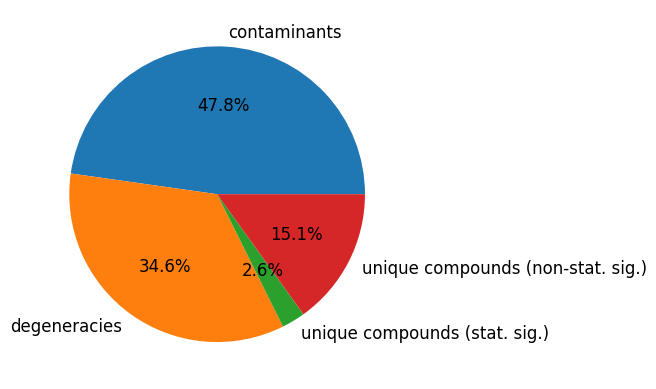

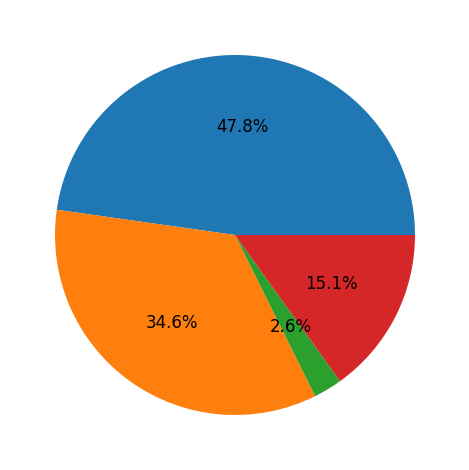

In [52]:
plt.pie([len([x for x in backgroundFeats if x in pd_only_feats.index.values]),
         len([x for x in degenFeats if x in pd_only_feats.index.values]),
         len([x for x in sigMetsPD if x in pd_only_feats.index.values]),
         len([x for x in nonSigMets if x in pd_only_feats.index.values])],
        labels=["contaminants","degeneracies","unique compounds (stat. sig.)","unique compounds (non-stat. sig.)"],autopct='%1.1f%%',textprops={"fontsize":12})#,colors=["yellow","grey","green","blue"])

plt.figure()
plt.pie([len([x for x in backgroundFeats if x in pd_only_feats.index.values]),
         len([x for x in degenFeats if x in pd_only_feats.index.values]),
         len([x for x in sigMetsPD if x in pd_only_feats.index.values]),
         len([x for x in nonSigMets if x in pd_only_feats.index.values])],
        autopct='%1.1f%%',textprops={"fontsize":12})#,colors=["yellow","grey","green","blue"])
plt.tight_layout()
plt.savefig(datadir + "pie_chart.png",dpi=300)

In [51]:
# research_samps = [x for x in det.sampleCols if "QC" not in x and "lank" not in x]
# research_samps

In [187]:
# det.imputeRowMin(det.sampleCols)

In [188]:
# det.backgroundSubtract(["lank"],["QC"],3)
# det.peakList

In [189]:
# if __name__ == "__main__":
#     det.removeRedundancy(0.9,0.5,"negative",10,ms1ppm,sampleCols=research_samps)

In [190]:
# det.logTransform(det.sampleCols)

In [191]:
# xcms_peaks_filt = det.peakList[det.sampleCols]
# xcms_peaks_filt

In [209]:
# sigMetsXCMS = []
# for index,row in xcms_peaks_filt.iterrows():
#     p,stat = stats.ttest_ind(row[samples[0]],row[samples[1]],equal_var=False)
    
#     if p <  0.05 and np.abs(np.mean(row[samples[1]])-np.mean(row[samples[0]])) > 1.0:
#         sigMetsXCMS.append(index)
# xcms_peaks_filt.loc[sigMetsXCMS,:]

In [53]:
def plot_overlayedEIC(rawdatas,mz,rt_start,rt_end,resolution=60,smoothing=0,alpha=0.3,colors=None):
    ts = np.linspace(rt_start,rt_end,resolution)
    for x,data in enumerate(rawdatas):
        s = data.interpolate_data(mz,rt_start,rt_end)
        ints  = [np.max([x,0]) for x in s(ts)]
        if colors is None:
            plt.plot(ts,ints,alpha=alpha)
        else:
            plt.plot(ts,ints,alpha=alpha,color=colors[x])

In [54]:
tmpRawData = []
colors = []
for samps,color in zip(samples,["red","blue"]):
    for x in samps:
        for y in raw_data:
            if x in y.filename:
                tmpRawData.append(y)
                colors.append(color)
                print(x,y.filename)

P H-464_6540.mzML ../data/hamster_plasma/polar_neg/ms1/P H-464_6540.mzML
P H-472_6540.mzML ../data/hamster_plasma/polar_neg/ms1/P H-472_6540.mzML
P H-476_6540.mzML ../data/hamster_plasma/polar_neg/ms1/P H-476_6540.mzML
P H-480_6540.mzML ../data/hamster_plasma/polar_neg/ms1/P H-480_6540.mzML
P H-482_6540.mzML ../data/hamster_plasma/polar_neg/ms1/P H-482_6540.mzML
P H-507_6540.mzML ../data/hamster_plasma/polar_neg/ms1/P H-507_6540.mzML
P H-469 -2 _6540.mzML ../data/hamster_plasma/polar_neg/ms1/P H-469 -2 _6540.mzML
P H-471_6540.mzML ../data/hamster_plasma/polar_neg/ms1/P H-471_6540.mzML
P H-487_6540.mzML ../data/hamster_plasma/polar_neg/ms1/P H-487_6540.mzML
P H-488_6540.mzML ../data/hamster_plasma/polar_neg/ms1/P H-488_6540.mzML
P H-514_6540.mzML ../data/hamster_plasma/polar_neg/ms1/P H-514_6540.mzML


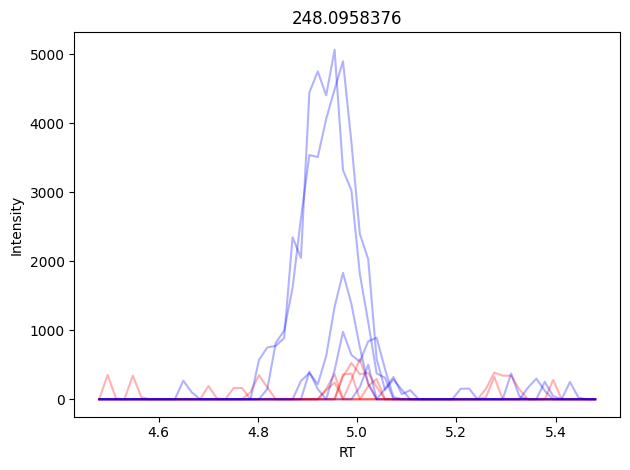

In [66]:
ind = rd.choice([x for x in sigMetsPD if x in pd_only_feats.index.values])
mz = pd_peak_list.peakList.at[ind,"mz"]
rt = pd_peak_list.peakList.at[ind,"rt"]
rt_start = rt-0.5
rt_end = rt+0.5
plot_overlayedEIC(tmpRawData,mz,rt_start,rt_end,resolution=60,alpha=0.3,colors=colors)
plt.title(mz)
plt.xlabel("RT")
plt.ylabel("Intensity")
plt.tight_layout()
plt.savefig(datadir + "example_pd_sig_feat.png",dpi=300)

/var/folders/_k/p9rcssm500n8hvdj57m0gpsw0000gn/T/ipykernel_26367/1843814430.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


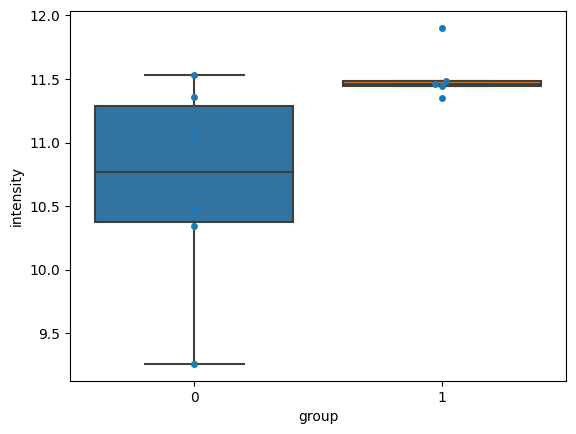

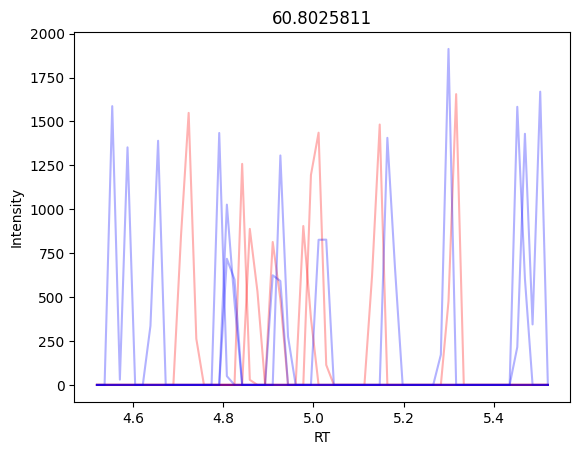

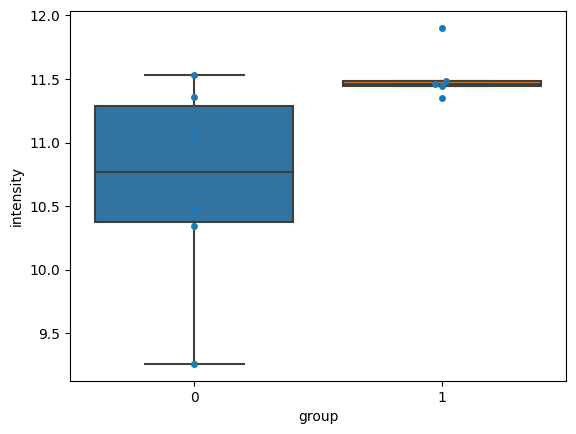

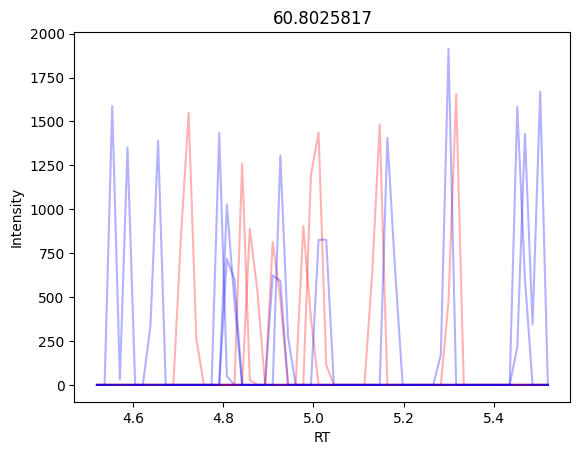

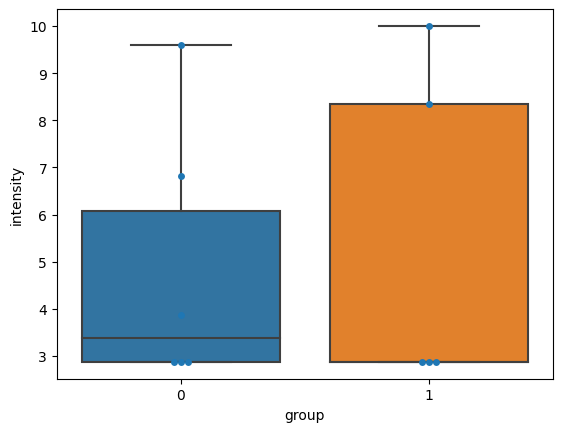

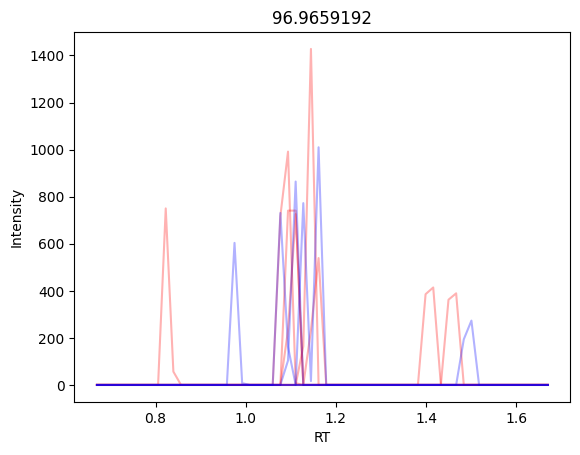

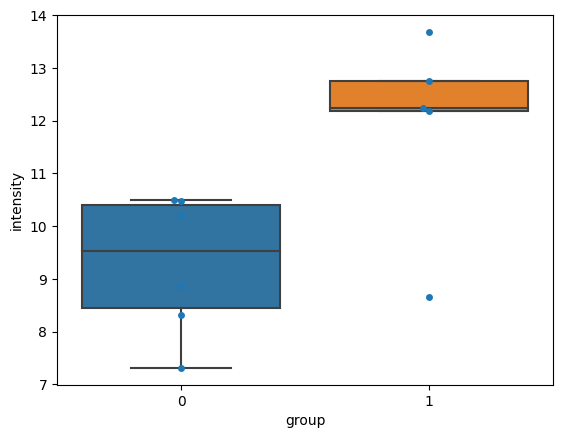

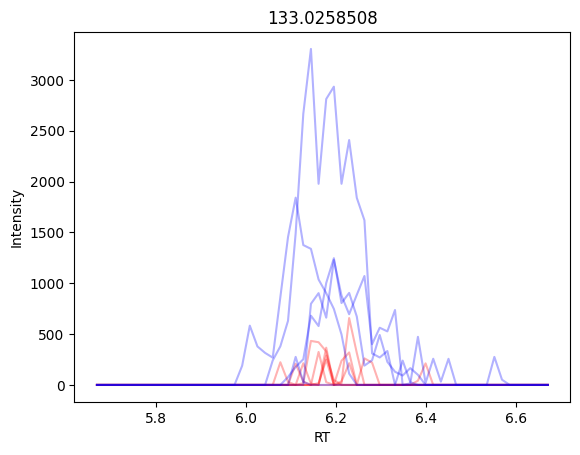

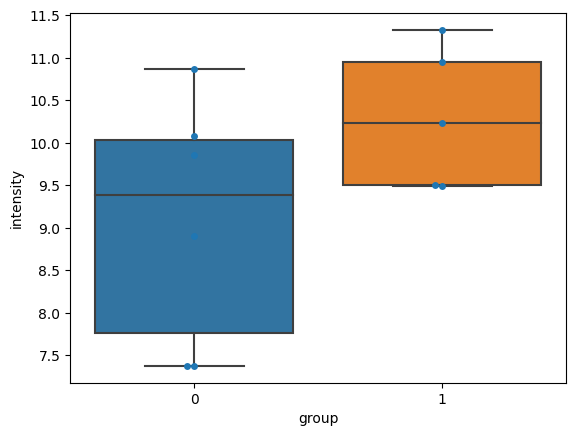

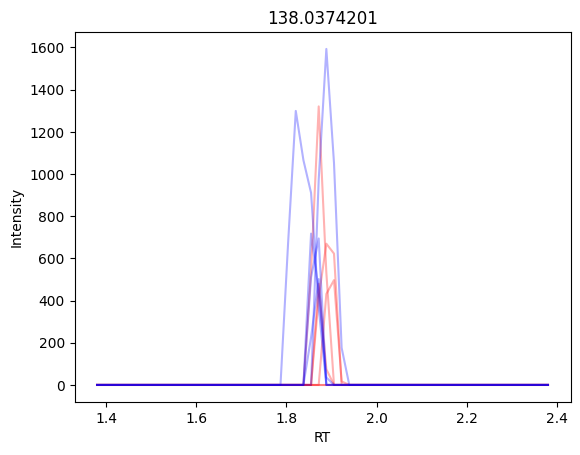

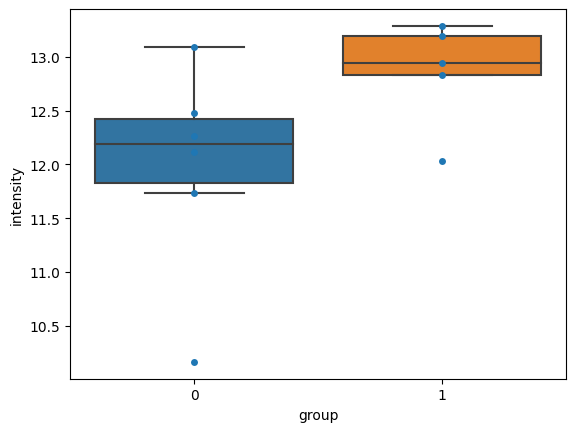

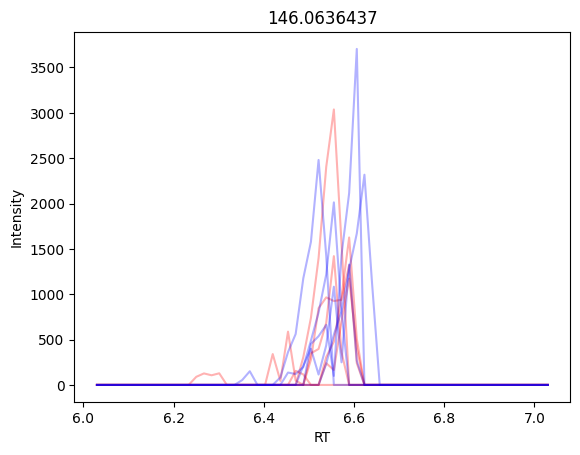

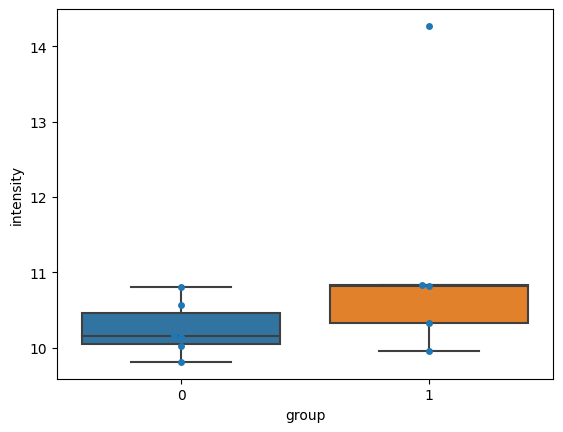

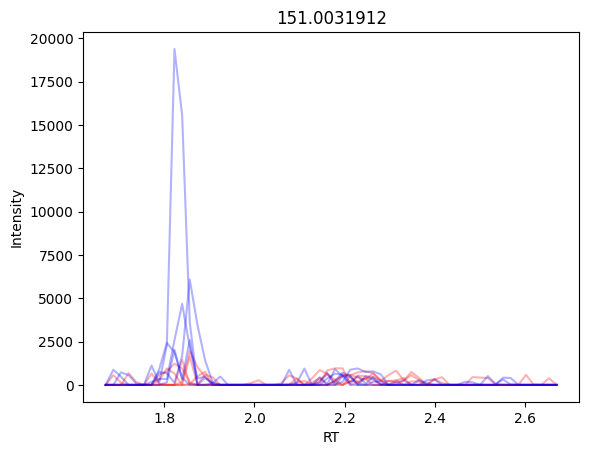

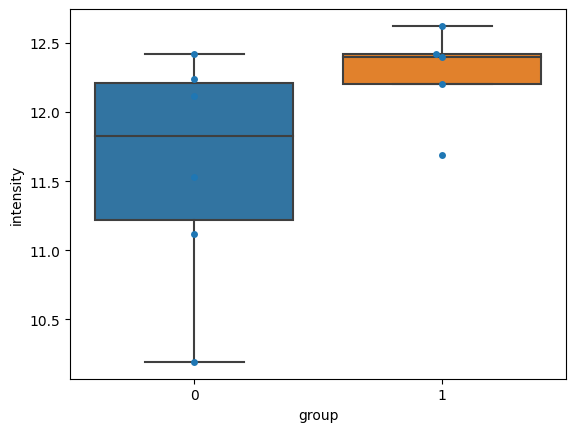

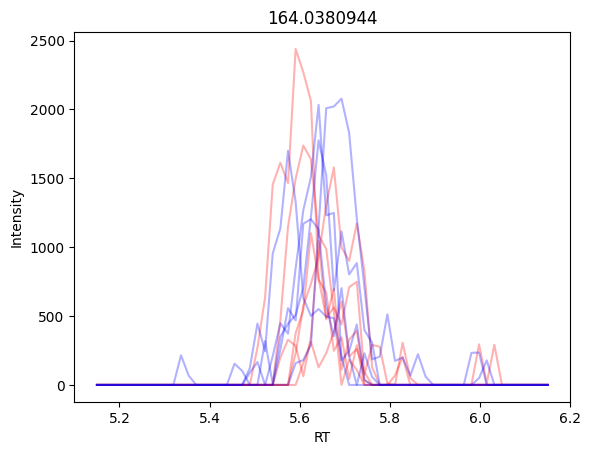

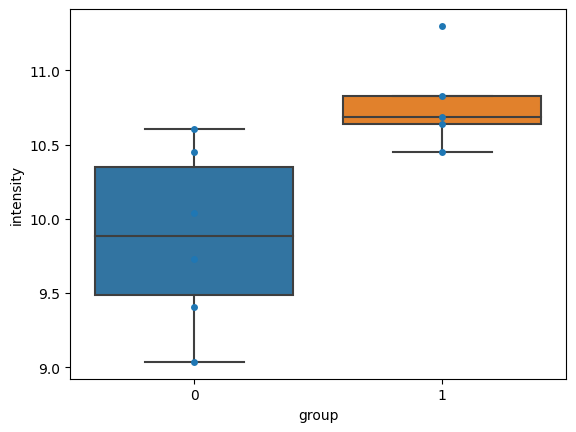

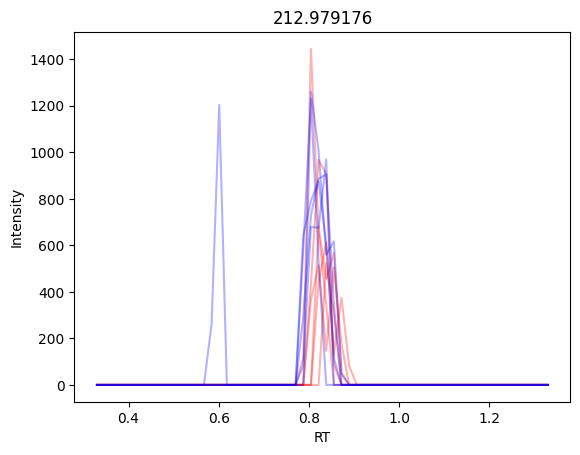

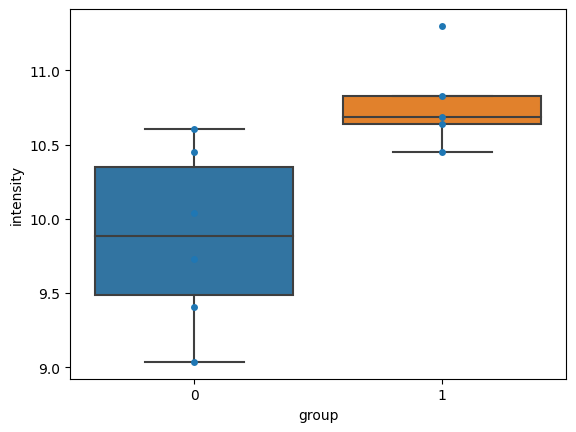

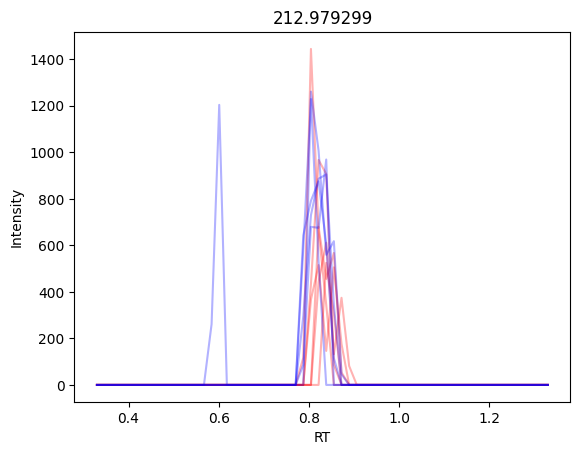

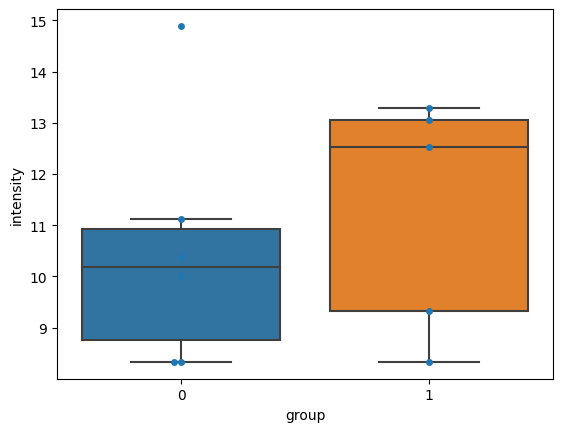

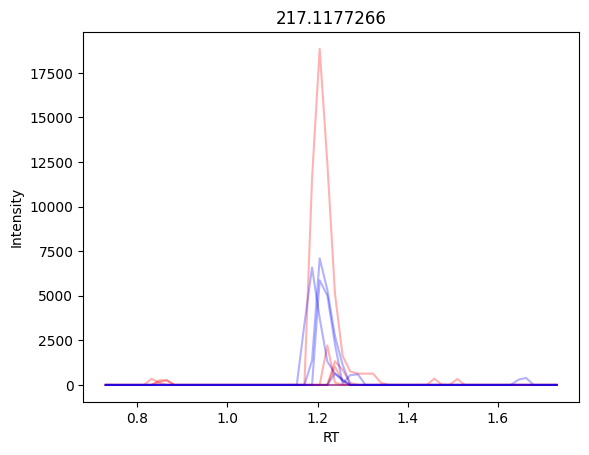

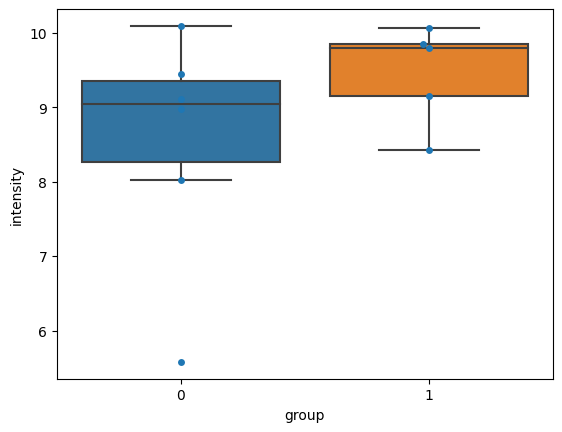

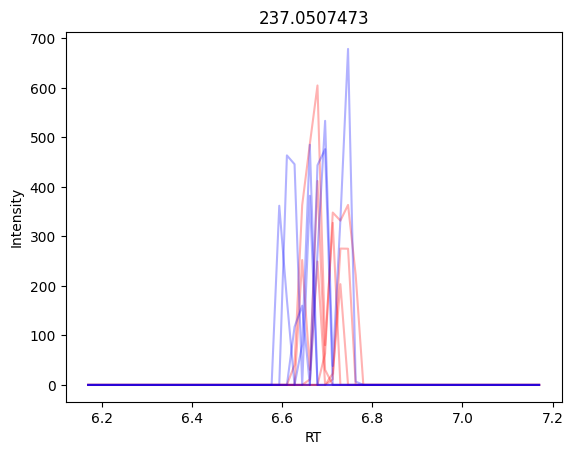

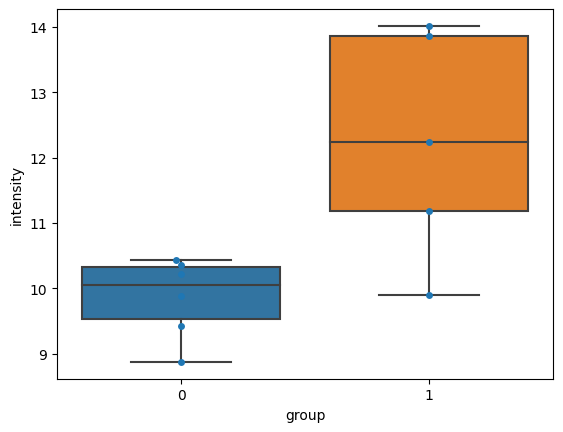

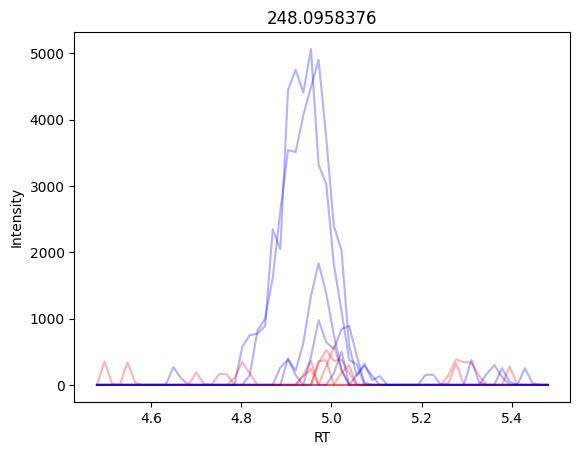

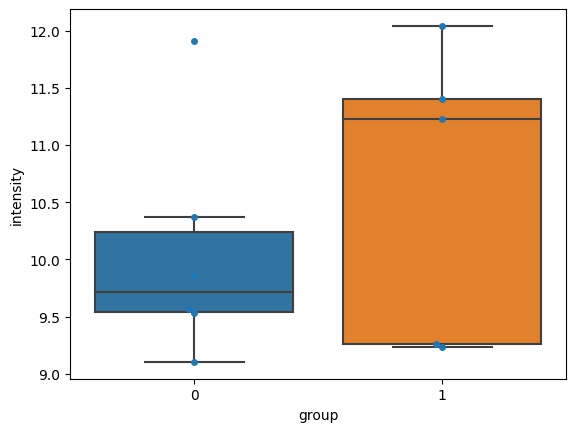

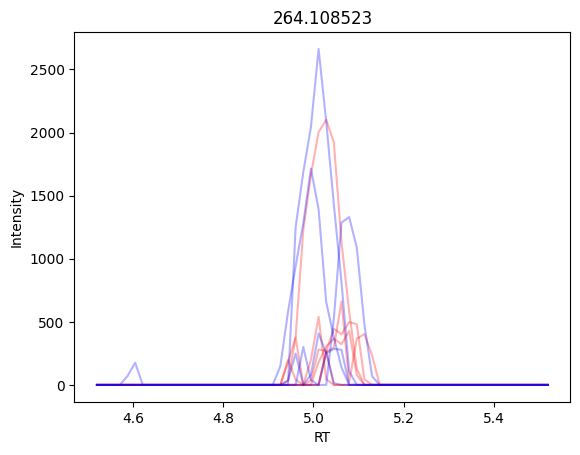

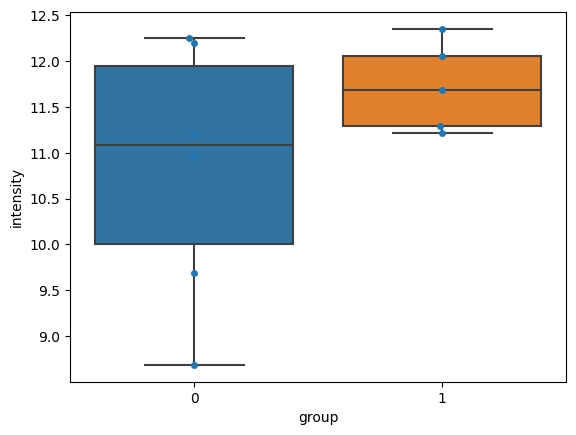

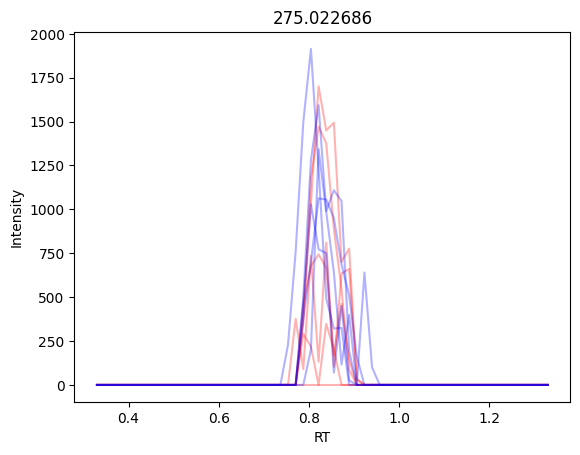

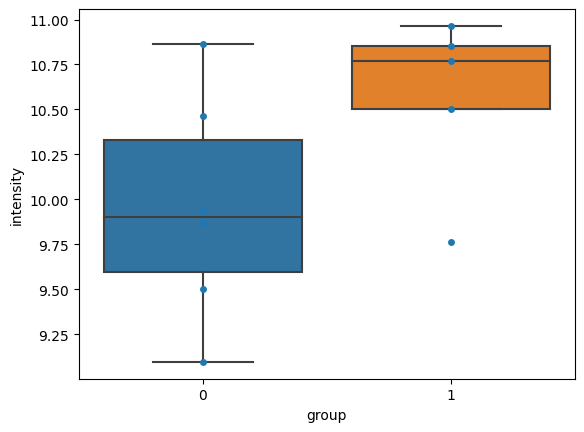

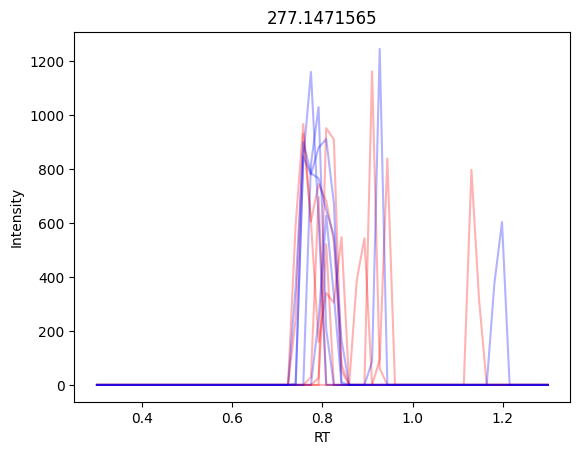

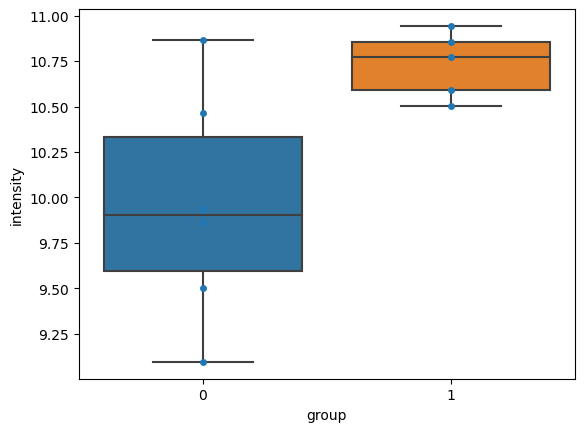

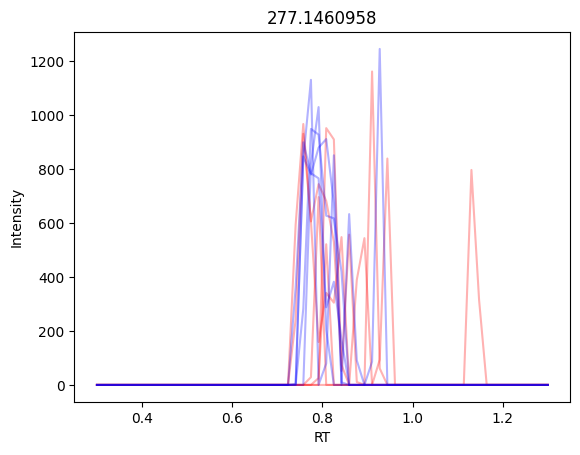

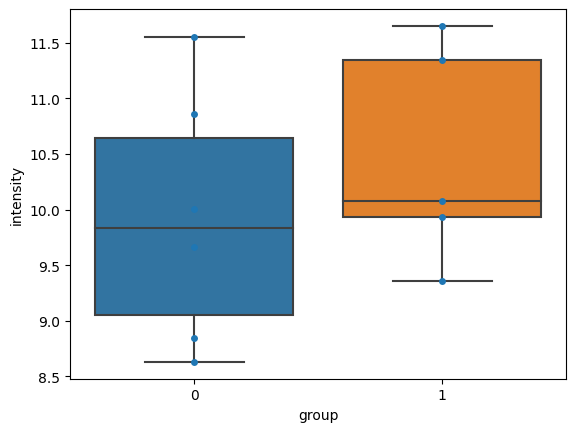

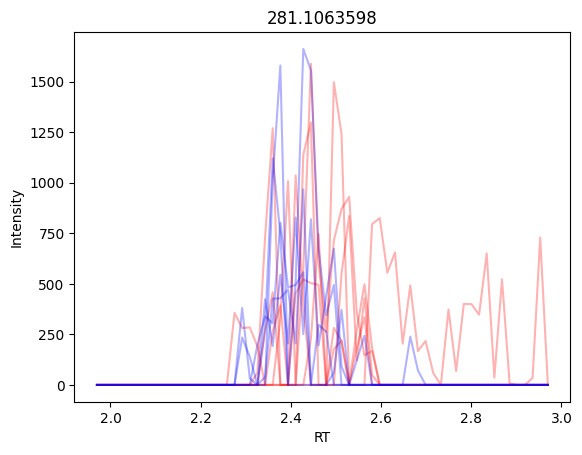

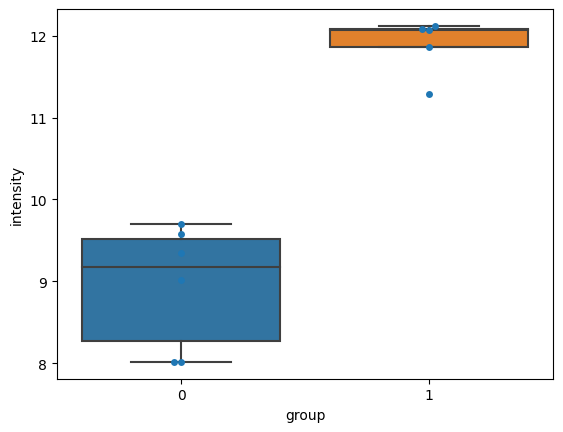

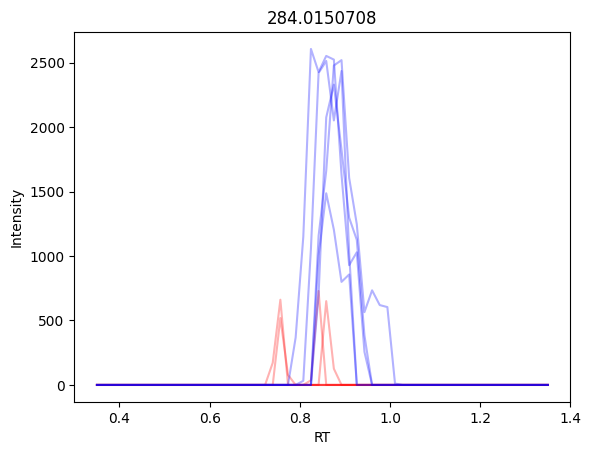

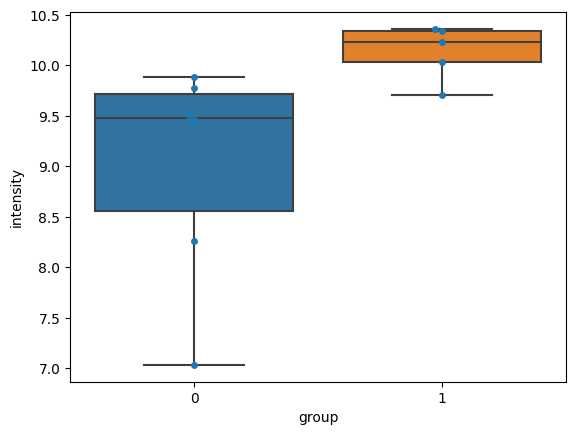

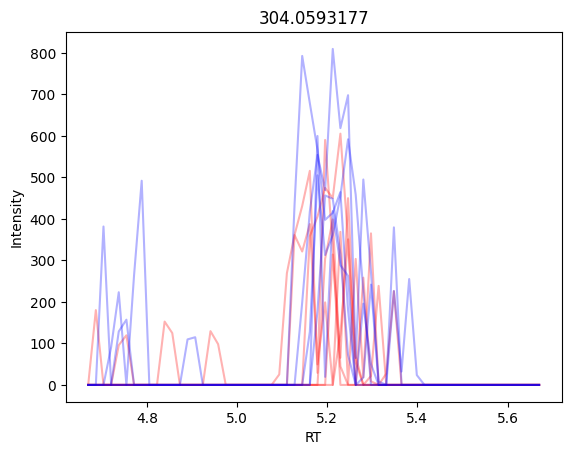

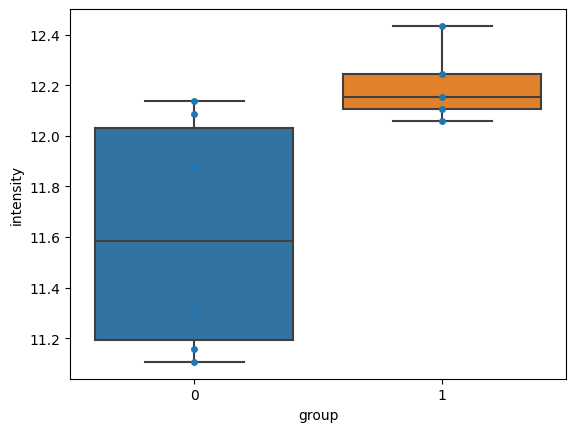

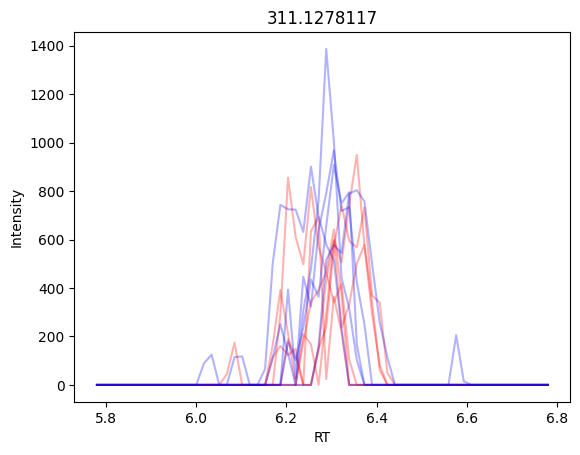

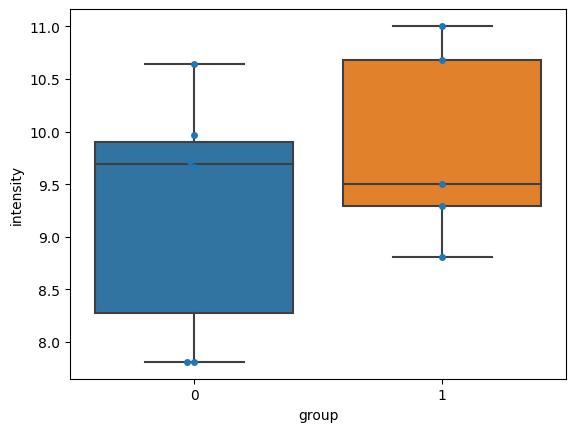

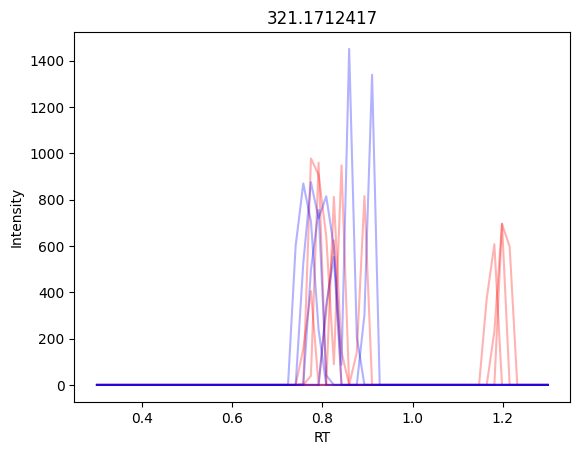

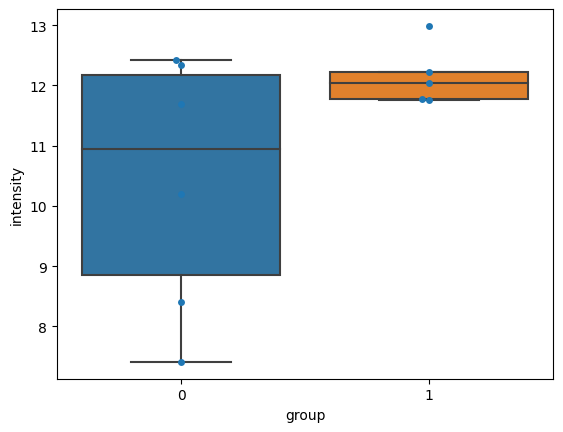

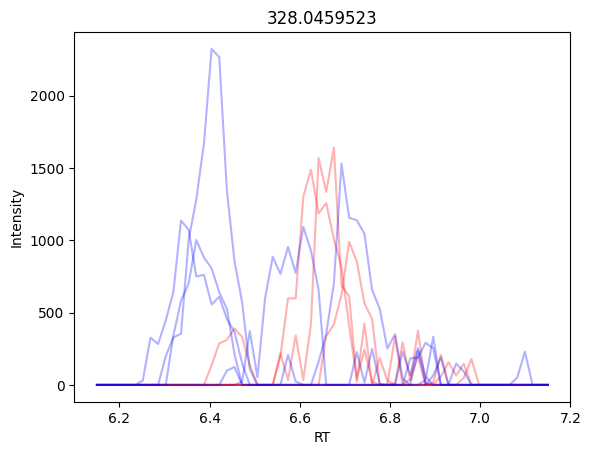

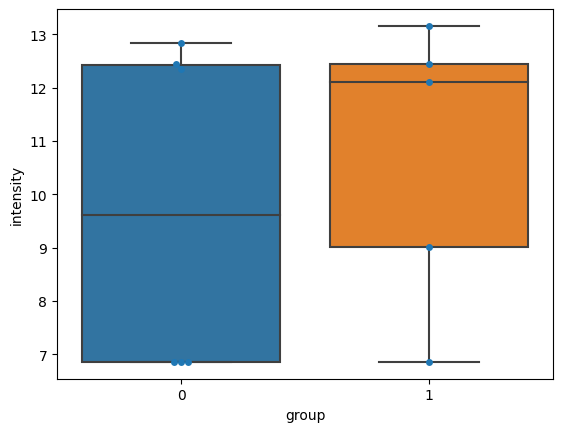

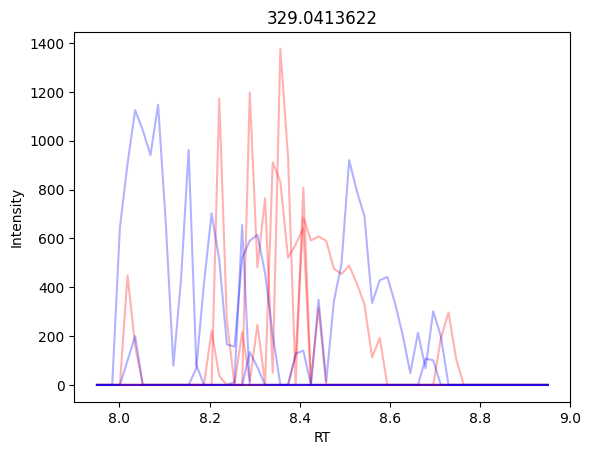

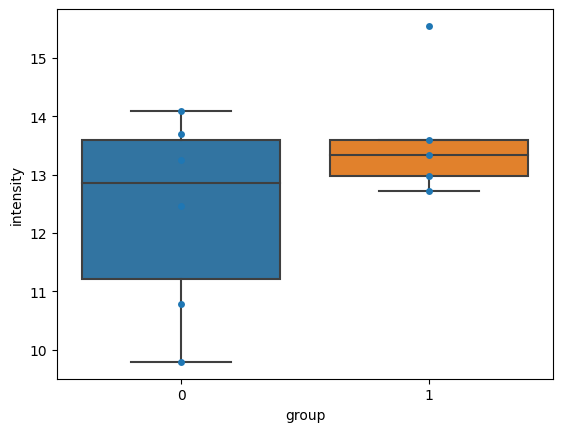

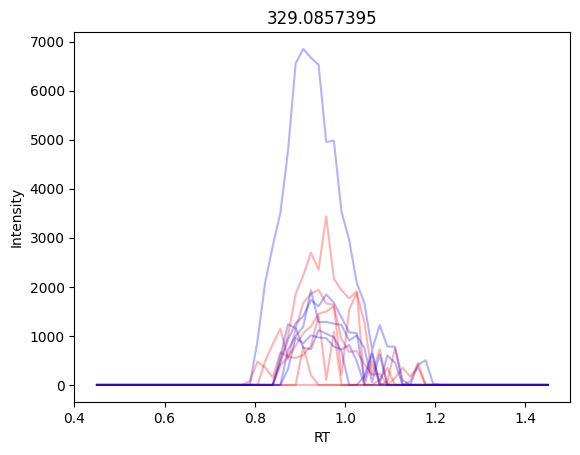

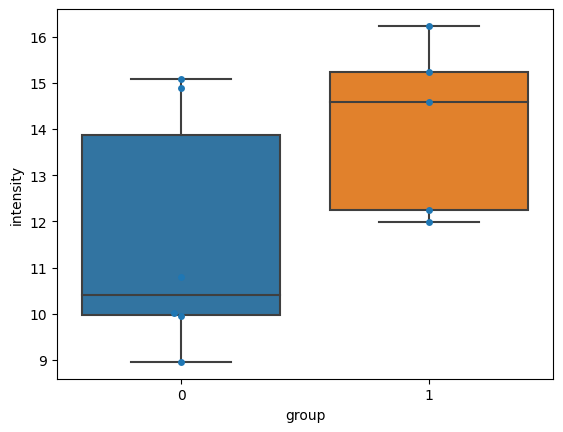

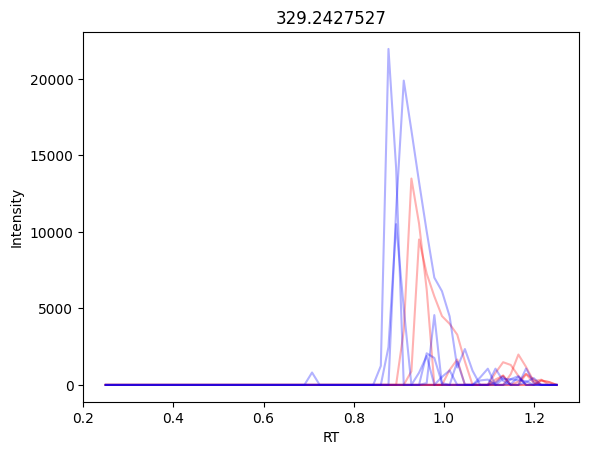

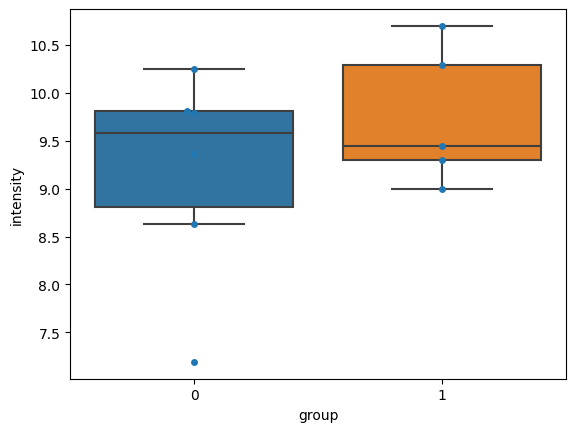

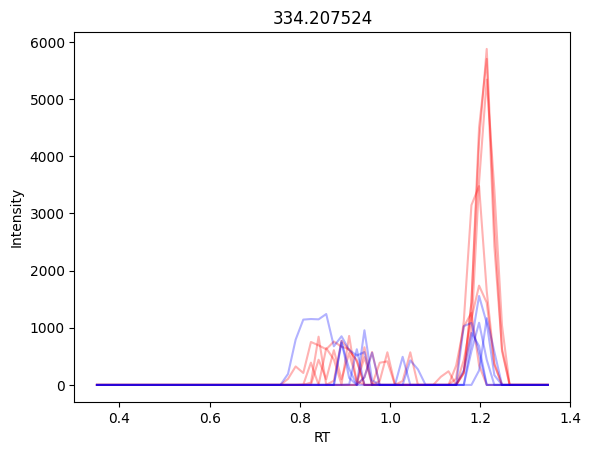

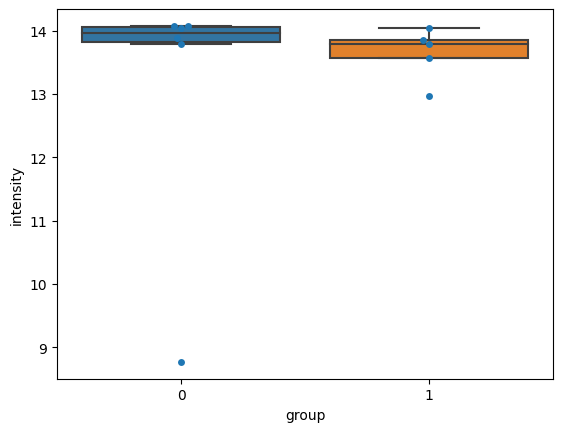

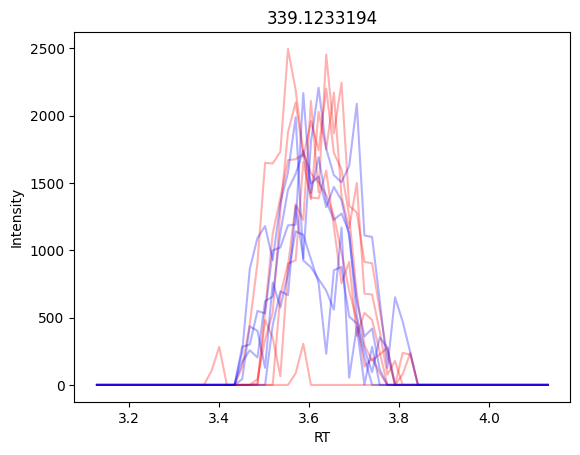

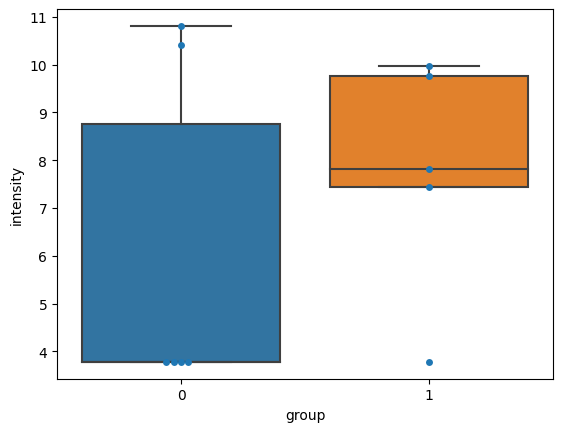

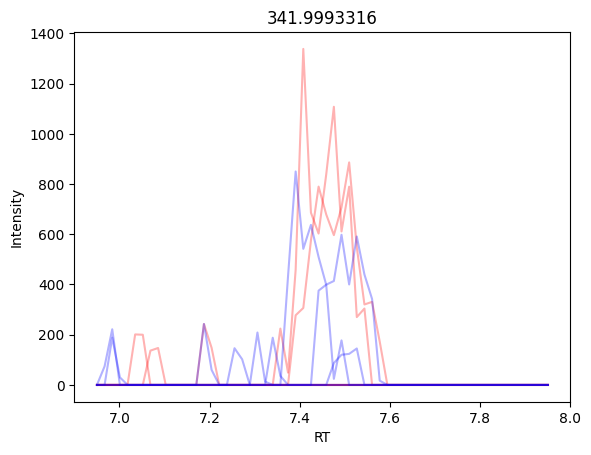

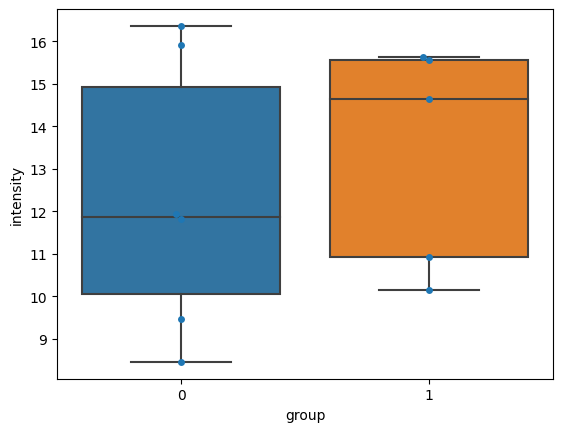

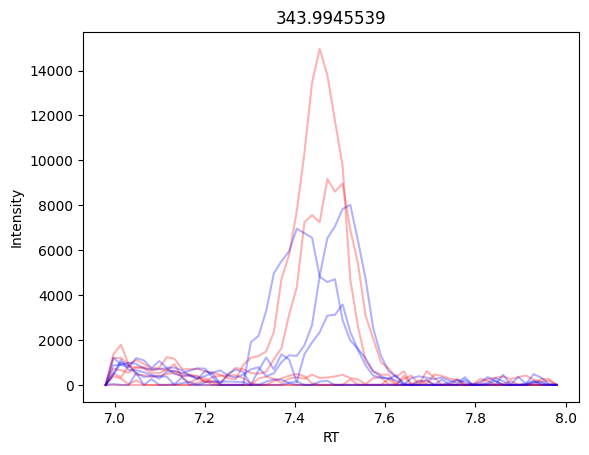

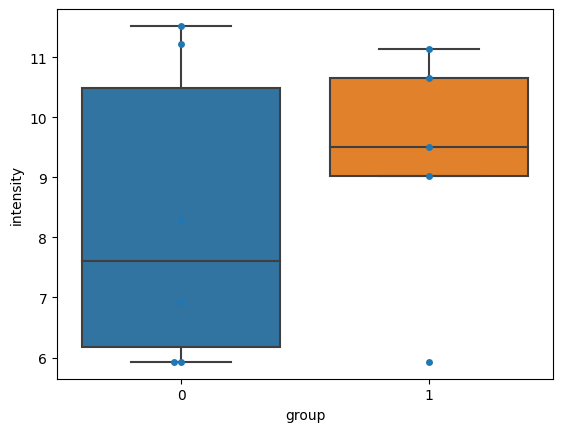

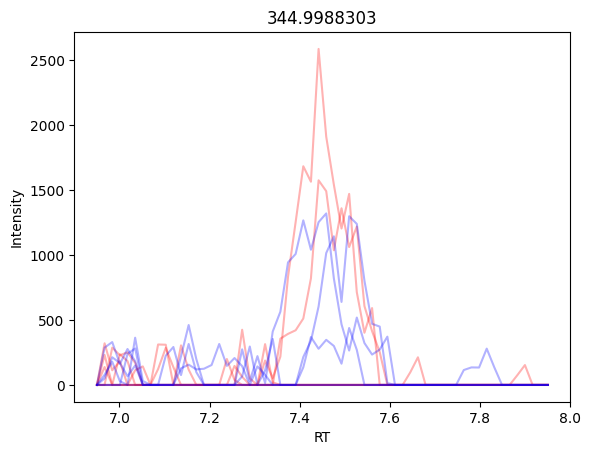

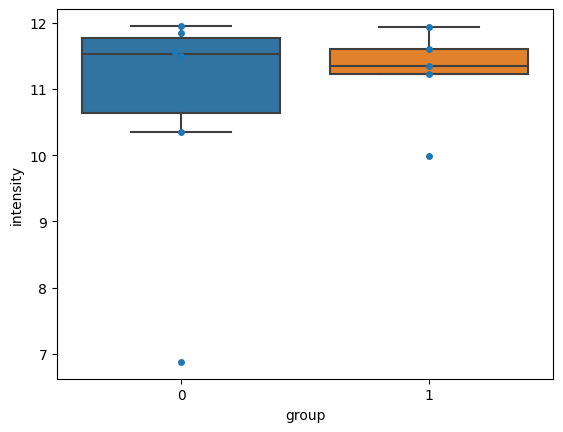

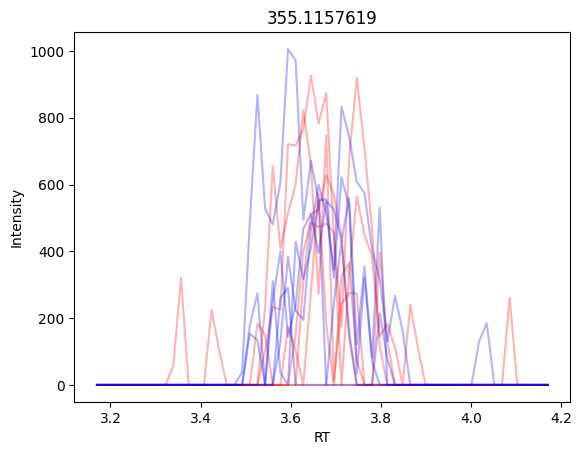

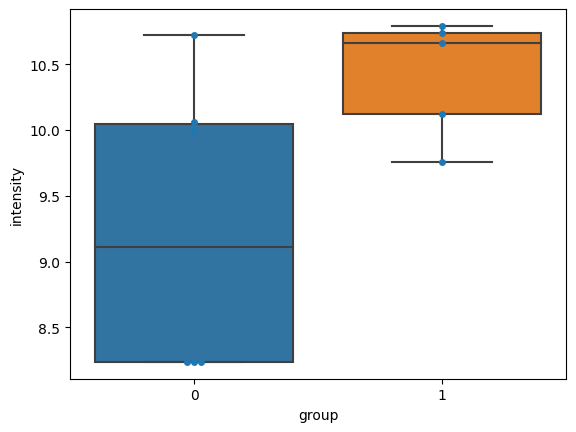

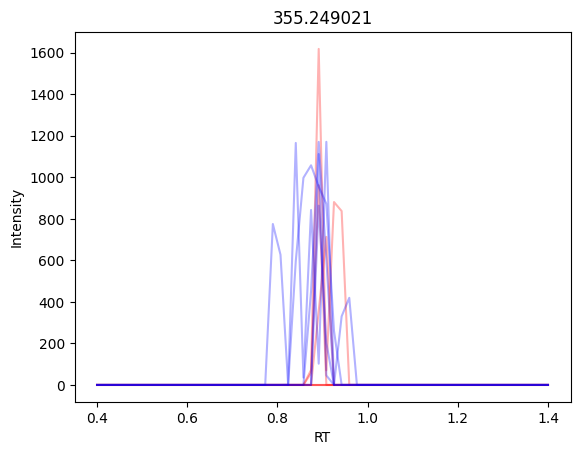

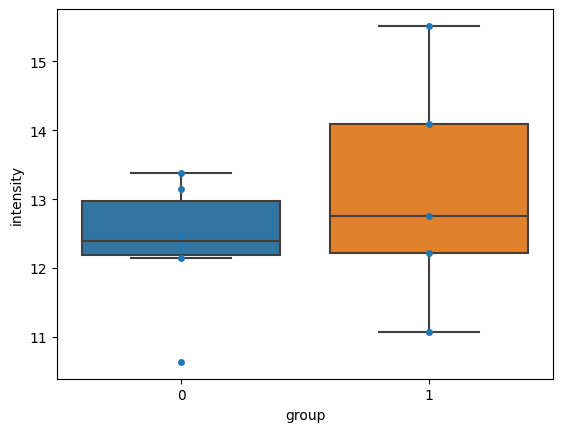

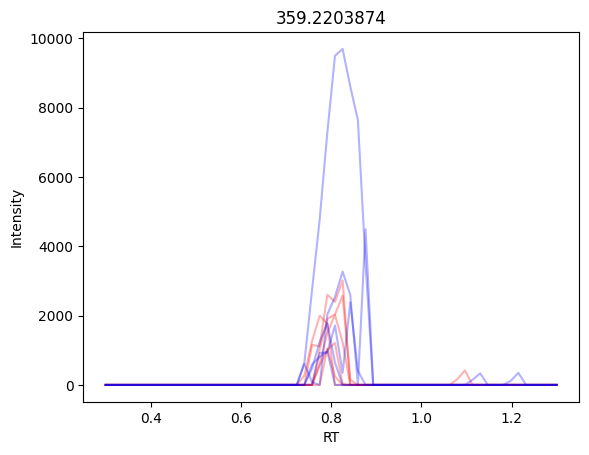

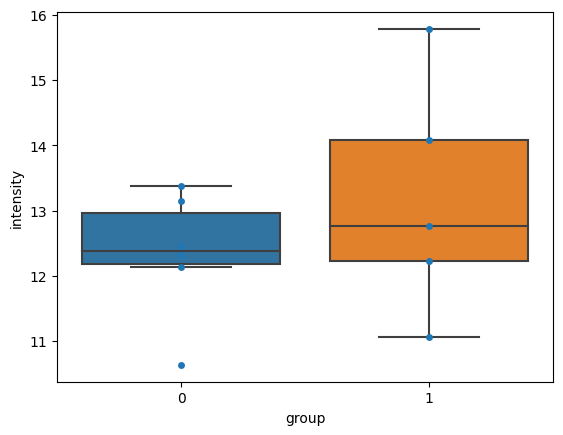

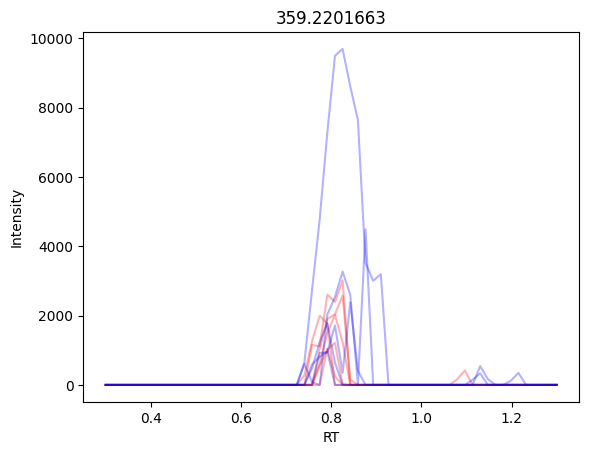

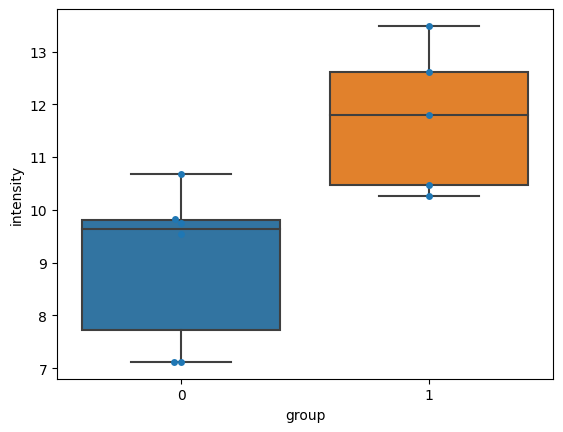

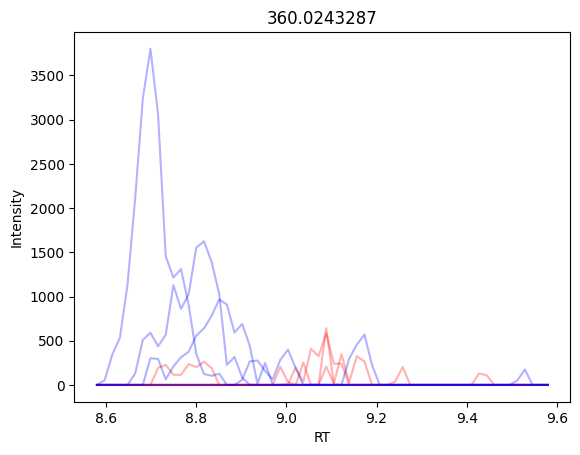

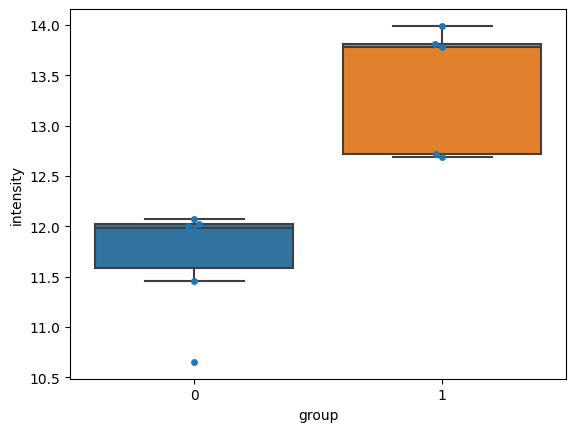

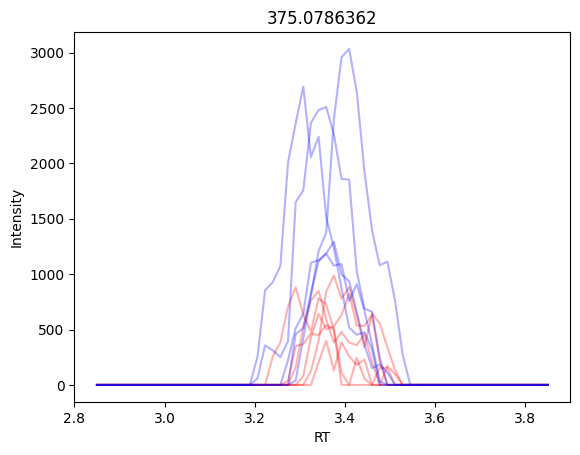

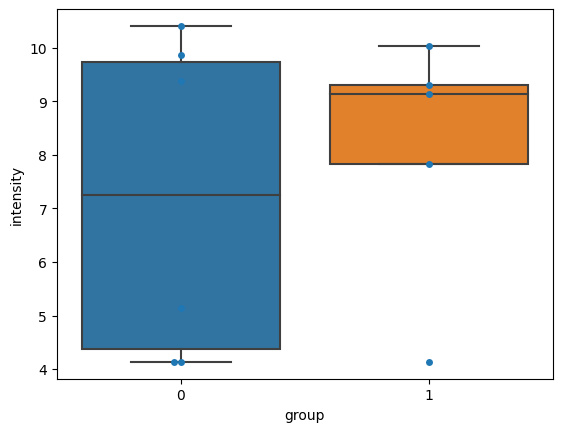

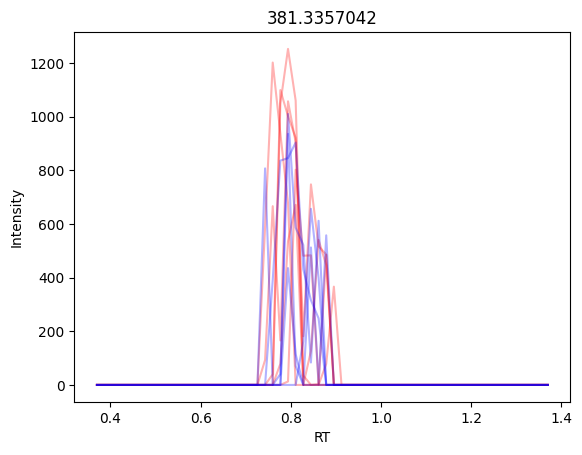

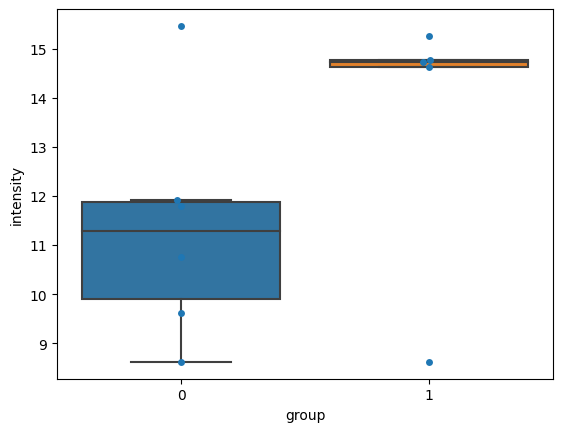

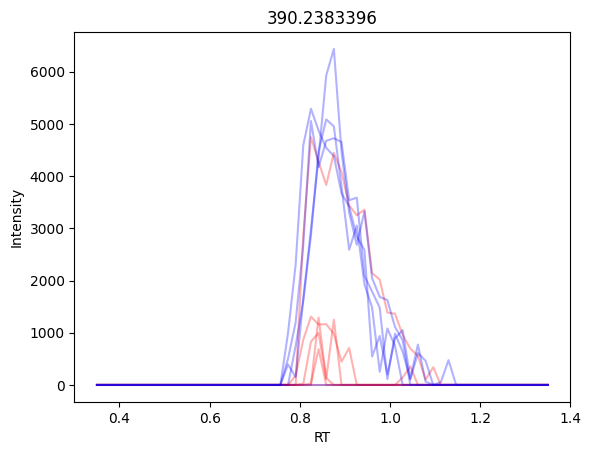

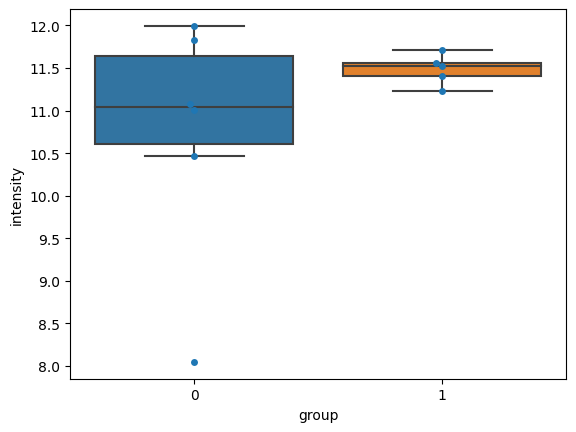

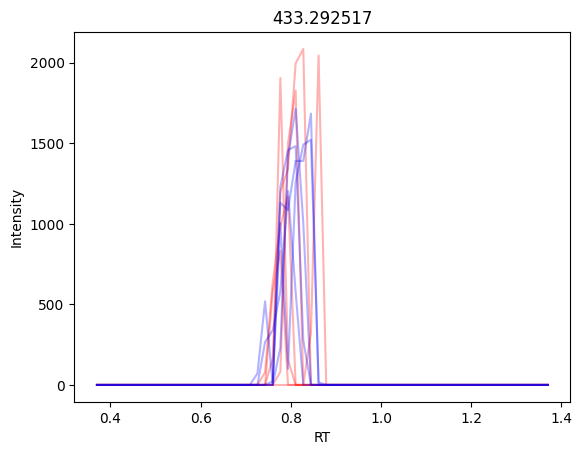

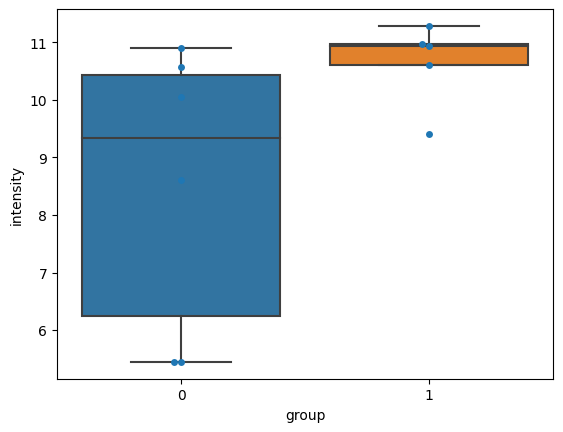

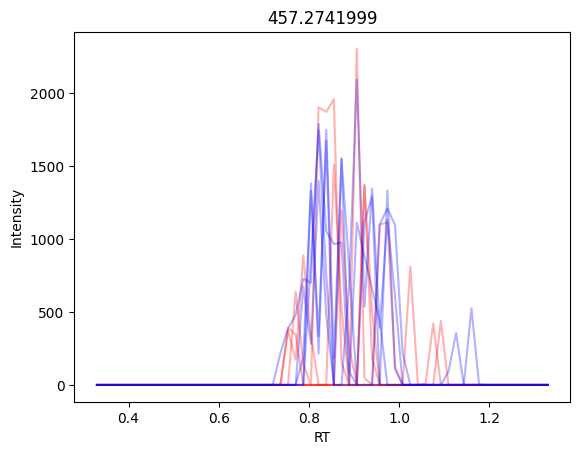

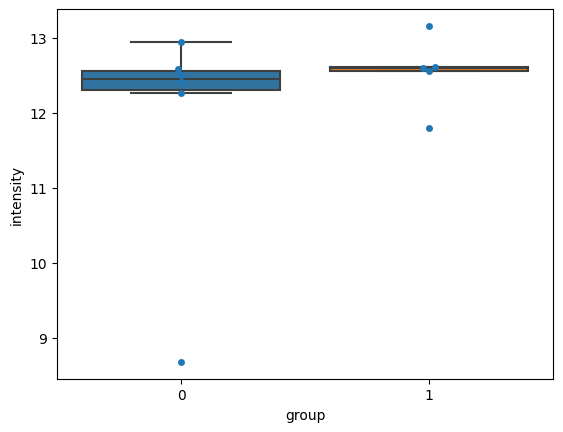

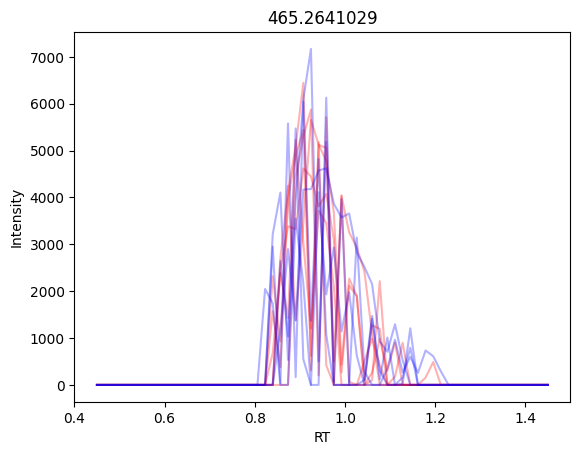

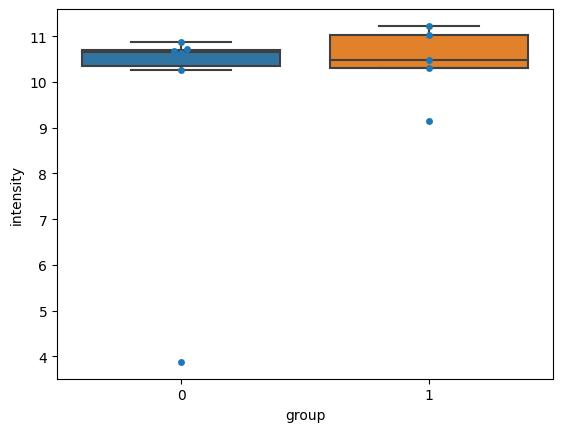

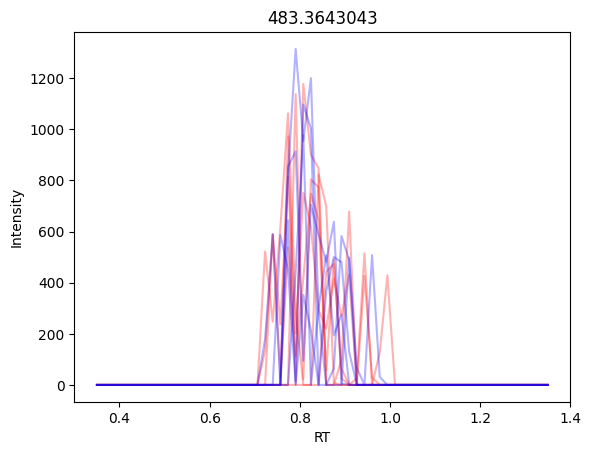

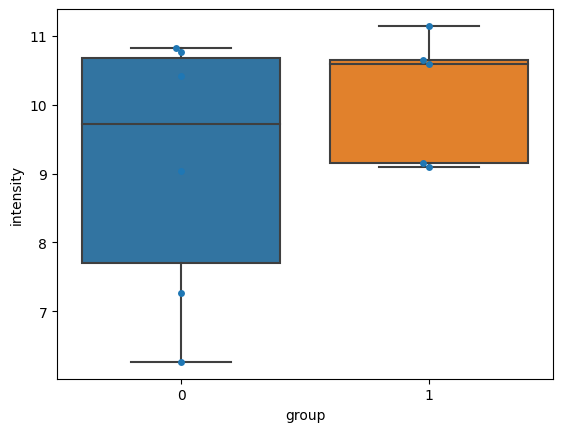

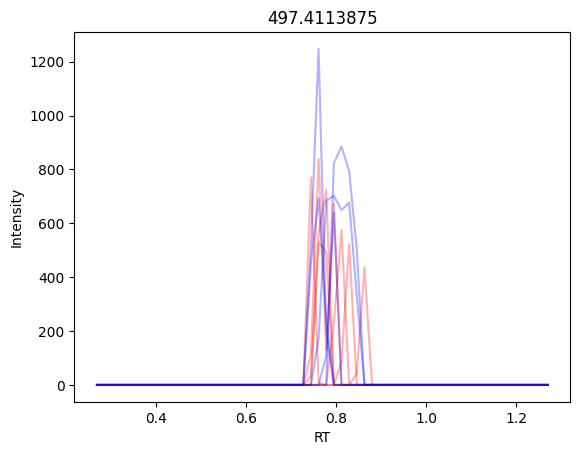

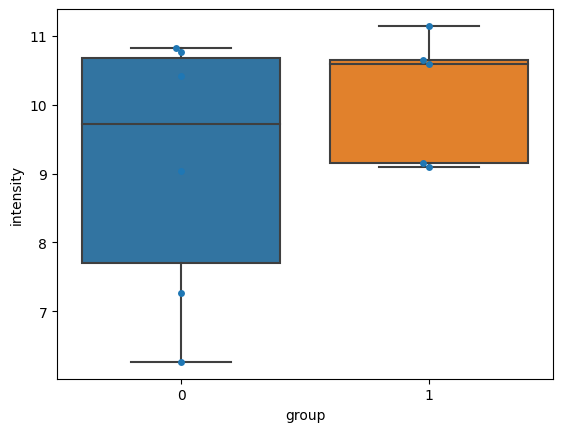

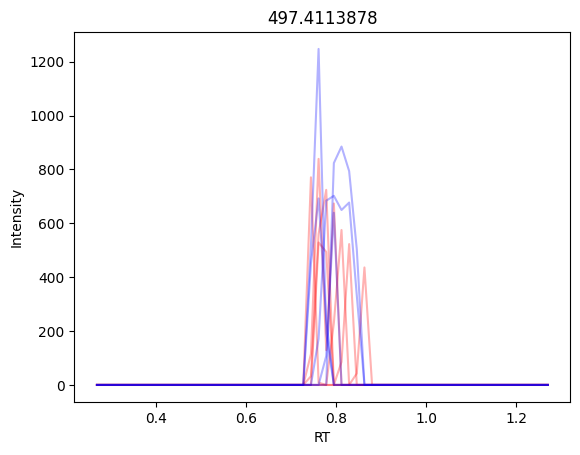

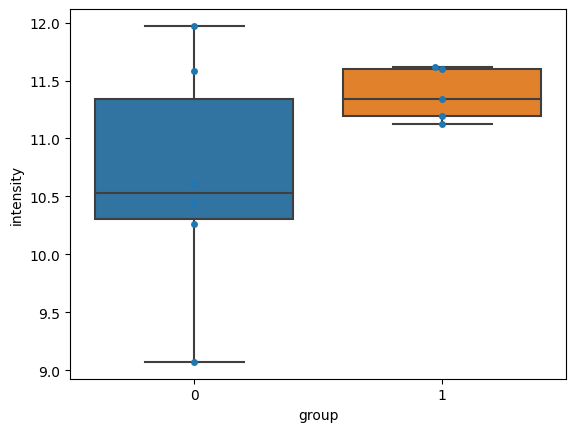

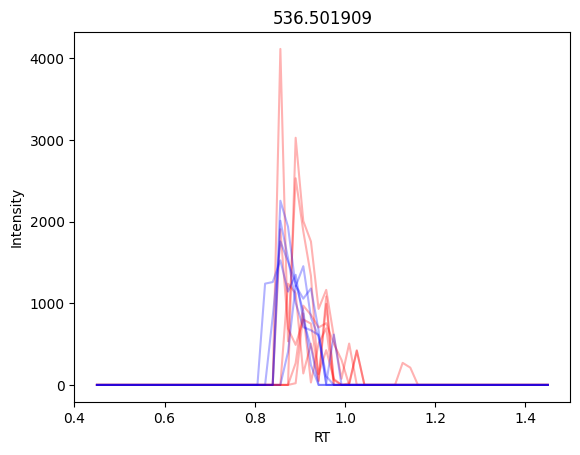

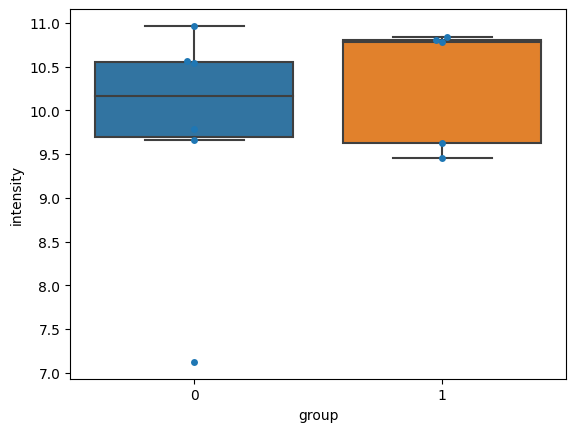

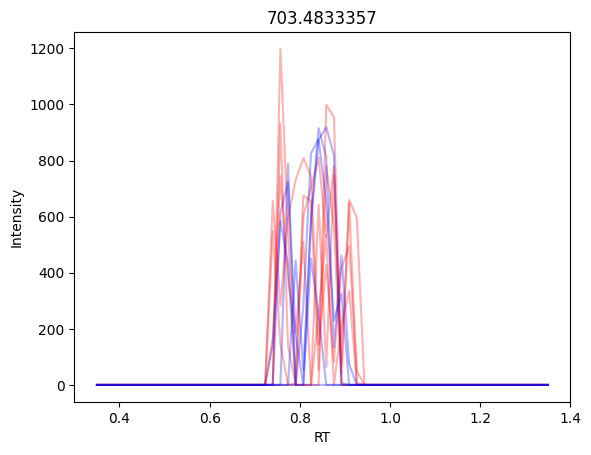

In [69]:
for index,row in pd_feats.loc[[x for x in sigMetsPD if x in pd_only_feats.index.values],:].iterrows():
    plt_df = {}
    for x,samp in enumerate(samples):
        for s in samp:
            plt_df[len(plt_df)] = {"sample":s,"intensity":row[s],"group":x}
    plt_df = pd.DataFrame.from_dict(plt_df,orient="index")
    plt.figure()
    sb.boxplot(data=plt_df,x="group",y="intensity",fliersize=0)
    sb.swarmplot(data=plt_df,x="group",y="intensity")

    mz = pd_peak_list.peakList.at[index,"mz"]
    rt = pd_peak_list.peakList.at[index,"rt"]
    rt_start = rt-0.5
    rt_end = rt+0.5
    plt.figure()
    plot_overlayedEIC(tmpRawData,mz,rt_start,rt_end,resolution=60,alpha=0.3,colors=colors)
    plt.title(mz)
    plt.xlabel("RT")
    plt.ylabel("Intensity")    
    

    

In [109]:
np.power(2,11)

2048